In [ ]:
# your code here
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from time import time
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Conv1D , Dropout
from keras.layers import MaxPooling1D , GlobalMaxPooling1D
from keras.layers import Flatten , Dense , Input ,concatenate , Activation
from keras.layers import Dense, Dropout, LSTM, Bidirectional , SimpleRNN
from keras.regularizers import l2 ,L1L2
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras import regularizers
from keras.optimizers import adam_v2

In [ ]:
import nltk
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 

def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("(#[A-Za-z0-9_]+)","", token)
        token = re.sub(r'[0-9]+', '', token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

LookupError: ignored

In [ ]:
# Defnining a handy function in order to plot various models accuracy and loss progress
import matplotlib as mpl

def plot_acc_loss(history):
  mpl.rcParams['figure.figsize'] = (12, 10)
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Load Dataset1

In [ ]:
tweets_df1 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df1.shape

(6000, 3)

In [ ]:
tweets_df1.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
print('Negative : {}'.format(tweets_df1.loc[tweets_df1.label == 1 ,'label'].count()))
print('Neuteral : {}'.format(tweets_df1.loc[tweets_df1.label == 2 ,'label'].count()))
print('Positive : {}'.format(tweets_df1.loc[tweets_df1.label == 3 ,'label'].count()))

Negative : 420
Neuteral : 3680
Positive : 1900


In [ ]:
tweets_df1.drop(columns=["tweet_id" ],inplace=True)

In [ ]:
tweets_df1 = tweets_df1.dropna()

In [ ]:
tweets_df1.head()

label                                         tweet_text
0      1  4,000 a day dying from the so called Covid-19 ...
1      2  Pranam message for today manifested in Dhyan b...
2      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3      1  Confirmation that Chinese #vaccines "dont hav...
4      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.loc[tweets_df1['label'] == 1, 'label'] = 0
tweets_df1.loc[tweets_df1['label'] == 2, 'label'] = 1
tweets_df1.loc[tweets_df1['label'] == 3, 'label'] = 2

In [ ]:
# Count samples per class
import sklearn
classes_zero = tweets_df1[tweets_df1['label'] == 0]
classes_one = tweets_df1[tweets_df1['label'] == 1]
classes_two = tweets_df1[tweets_df1['label'] == 2]

# Convert parts into NumPy arrays for weight computation
zero_numpy = classes_zero['label'].to_numpy()
one_numpy = classes_one['label'].to_numpy()
two_numpy = classes_two['label'].to_numpy()
all_together = np.concatenate((zero_numpy, one_numpy,two_numpy))
unique_classes = np.unique(all_together)


# Compute weights
weights = sklearn.utils.compute_class_weight(class_weight = "balanced", classes= unique_classes, y= all_together)
print(weights)
class_weight = {0: weights[0], 1: weights[1] ,2:weights[2]}

[4.76190476 0.54347826 1.05263158]


# Prerocess Dataset1
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words and lemmatize word

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data1 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df1['tweet_text'].tolist()
Y = tweets_df1['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data1.append((tk.tokenize(x), y))

In [ ]:
cleaned_tokens_list1 = []

# Removing noise from all the data
for tokens, label in data1:
    cleaned_tokens_list1.append((remove_noise(tokens), label))

import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'wb') as fp:
        pickle.dump(cleaned_tokens_list1, fp)

In [ ]:
sentences_array1 = [s[0] for s in cleaned_tokens_list1]
sentences1 = []

for s in sentences_array1 :
  sentence = ' '.join(map(str ,s))
  sentences1.append(sentence)

print(sentences1[0])
print(sentences_array1[0])

day die call covid vaccine report
['day', 'die', 'call', 'covid', 'vaccine', 'report']


# Load Dataset2

In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2.head()

user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(395683, 1)

In [ ]:
tweets_df2.head()

text
0  Australia to Manufacture Covid-19 Vaccine and ...
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...
2  Deaths due to COVID-19 in Affected Countries\n...
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...
4  @michellegrattan @ConversationEDU This is what...

# Preprocess Dataset2
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words and lemmatize word

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise(tokens))

import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['australia', 'manufacture', 'covid', 'vaccine', 'give', 'citizens', 'free', 'cost', 'afp', 'quote', 'prime', 'minister']


# Load Dataset3

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

# Preprocess Dataset3
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words and lemmatize word

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['folk', 'say', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm']


# Load Dataset4

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

# Preprocess Dataset4
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words and lemmatize word

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['covid', 'denial', 'inaction', 'many', 'political', 'world', 'leader', 'create', 'tsunami', 'anti-vaccine', 'mask', 'refusal', 'many', 'lockdown', 'keep', 'football', 'live', 'make', 'near', 'impossible', 'stop', 'variant', 'around', 'fox', 'propaganda']


# Combine datasets for word2vec

In [ ]:
train_data = sentences_array1 + sentences_array2 + sentences_array3 + sentences_array4
len(train_data)

1387864

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec', 'wb') as fp:
        pickle.dump(train_data, fp)

# Learn Word2vec
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words and lemmatize word

In [ ]:
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()
print('Number of cores in this device {}'.format(cores))

Number of cores in this device 2


In [ ]:
docs_num = len(train_data)
tokens_num = sum([len(x) for x in train_data])
print('Number of all tweets {}'.format(docs_num))
print('Number of all Tokens {}'.format(tokens_num))

Number of all tweets 1387864
Number of all Tokens 18451141


In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=300 , alpha=0.03 , workers=cores-1)
w2v_model.build_vocab(train_data)

CPU times: user 38.1 s, sys: 770 ms, total: 38.9 s
Wall time: 38.7 s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  196512


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 20)



CPU times: user 15min 48s, sys: 3.49 s, total: 15min 51s
Wall time: 15min 41s


(328621424, 369022820)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d.model")

# Prepare train and test dataset
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words and lemmatize word

In [ ]:
tweets_df = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df.shape

(6000, 3)

In [ ]:
tweets_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df.drop(columns=["tweet_id"],inplace=True)

In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.loc[tweets_df['label'] == 1, 'label'] = 0
tweets_df.loc[tweets_df['label'] == 2, 'label'] = 1
tweets_df.loc[tweets_df['label'] == 3, 'label'] = 2

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df['tweet_text'].tolist()
Y = tweets_df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 0.9466221332550049


[(['4,000',
   'a',
   'day',
   'dying',
   'from',
   'the',
   'so',
   'called',
   'Covid',
   '-',
   '19',
   '\x93',
   'vaccine',
   '\x94',
   '@DailyBeast',
   'reports',
   '.',
   '#vaccine',
   '#PfizerVaccine',
   '#Moderna',
   'https://t.co/p1nQWWZpk4'],
  0),
 (['Pranam',
   'message',
   'for',
   'today',
   'manifested',
   'in',
   'Dhyan',
   'by',
   '@meenapranam',
   '#truth',
   '#love',
   '#karm',
   '#light',
   '#nature',
   '#consciousness',
   '#FridayThoughts',
   '#fridaymorning',
   '#CoronavirusIndia',
   '#COVID19India',
   '#',
   '?',
   '?',
   '?',
   '_',
   '?',
   '?',
   '?',
   '#navratri',
   '#Thane',
   '#AmbedkarJayanti2021',
   '#ModiJi',
   '#NarendraModi',
   '#SecondCOVIDWave',
   '#Covaxin',
   'https://t.co/bQNoMVowJg'],
  1),
 (['Hyderabad-based',
   '?',
   '@BharatBiotech',
   '?',
   'has',
   'sought',
   'funds',
   'from',
   'the',
   'government',
   'to',
   'ramp',
   'up',
   'production',
   'of',
   'its',
   'indig

In [ ]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['4,000', 'a', 'day', 'die', 'from', 'the', 'so', 'call', 'Covid', '-', '19', '\x93', 'vaccine', '\x94', '@DailyBeast', 'report', '.', '#vaccine', '#PfizerVaccine', '#Moderna', 'https://t.co/p1nQWWZpk4']


In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("(#[A-Za-z0-9_]+)","", token)
        token = re.sub(r'[0-9]+', '', token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['day', 'die', 'call', 'covid', 'vaccine', 'report']


In [ ]:
cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

In [ ]:
sentences_array = [s[0] for s in cleaned_tokens_list]
sentences = []

for s in sentences_array :
  sentence = ' '.join(map(str ,s))
  sentences.append(sentence)

print(sentences[0])
print(sentences_array[0])

day die call covid vaccine report
['day', 'die', 'call', 'covid', 'vaccine', 'report']


In [ ]:
# find number of unique words i train list
all_train_word = []

for i in range(len(sentences_array)) :
  all_train_word += sentences_array[i]

print('all words in dataset1 number (after preprocess): {}'.format(len(all_train_word)))

uniqueWords = [] 
for i in all_train_word:
  if not i in uniqueWords:
      uniqueWords.append(i)


print('unique words in dataset1 number (after preprocess): {}'.format(len(uniqueWords)))

all words in dataset1 number (after preprocess): 68892
unique words in dataset1 number (after preprocess): 9032


In [ ]:
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

max_len: 32


In [ ]:
Y = np.zeros((len(cleaned_tokens_list), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    Y[i] = label

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [ ]:
X_sequences = tokenizer.texts_to_sequences(sentences)
X_sequences[2]

[1035, 825, 581, 339, 79, 638, 81, 1036, 117, 5, 1, 88, 736, 581, 408, 638]

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X_sequences,maxlen=max_len ,padding='post')
X_padded = np.array(X_padded)
X_padded[2]

array([1035,  825,  581,  339,   79,  638,   81, 1036,  117,    5,    1,
         88,  736,  581,  408,  638,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train.shape)
print(Y_train.shape)

(4800, 32)
(4800,)


In [ ]:
# Python program to store list to file using pickle module
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec', 'wb') as fp:
        pickle.dump(X_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtestVec', 'wb') as fp:
        pickle.dump(X_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec', 'wb') as fp:
        pickle.dump(Y_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec', 'wb') as fp:
        pickle.dump(Y_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec', 'rb') as fp:
#         X_train =  pickle.load(fp)
         
# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec', 'rb') as fp:
#         X_test =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec', 'rb') as fp:
#         Y_train =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec', 'rb') as fp:
#         Y_test =  pickle.load(fp)

# Make Embedding Matrix

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d.model")

In [ ]:
EMBEDDING_DIM=300
vocabulary_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

i = 0
for word,i in tokenizer.word_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
         pass
        
       
    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)


(8816, 300)
[ 9.76937354e-01  1.62516966e-01  8.97192478e-01  2.53277373e+00
  1.77905333e+00  2.35359240e+00 -6.52156115e-01 -5.28585970e-01
  2.57295465e+00  2.14553738e+00 -1.94837916e+00 -7.49472603e-02
  4.91319984e-01  2.05509043e+00  1.68623954e-01 -2.73101598e-01
  9.79469299e-01  1.10412681e+00 -9.57584858e-01  1.43601751e+00
 -6.26464307e-01  9.31007341e-02 -1.67835593e+00  8.82157564e-01
 -8.01708624e-02  1.52599406e+00  1.88499570e+00  5.59036553e-01
 -2.77712613e-01 -1.22104311e+00  8.98642018e-02 -2.30187583e+00
  5.25135398e-01  7.22067118e-01  8.76473486e-01 -1.14101648e+00
 -1.30934525e+00  3.91175389e-01  4.26736385e-01  2.48199368e+00
 -9.81058739e-03 -8.38718176e-01  1.33952057e+00 -1.93091393e+00
 -1.08426225e+00  1.51331818e+00  2.05362916e+00  9.75329220e-01
  1.08689249e+00 -2.20889419e-01  2.95490801e-01 -2.84071773e-01
 -1.68926907e+00  7.29163885e-02 -7.68336236e-01  1.12872946e+00
 -1.60241473e+00 -8.89172927e-02 -4.83110875e-01  9.10038173e-01
  1.36365461e

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

In [ ]:
zero_rows_UNK = np.where(~embedding_matrix.any(axis=1))[0]
len(zero_rows_UNK)

93

# CNN1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 4.7600 - accuracy: 0.6109 - val_loss: 3.3145 - val_accuracy: 0.6979
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 2.5248 - accuracy: 0.6831 - val_loss: 1.8763 - val_accuracy: 0.7188
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.5275 - accuracy: 0.7164 - val_loss: 1.2813 - val_accuracy: 0.7208
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0978 - accuracy: 0.7260 - val_loss: 1.0049 - val_accuracy: 0.7208
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8960 - accuracy: 0.7466 - val_loss: 0.9285 - val_accuracy: 0.7104
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8041 - accuracy: 0.7596 - val_loss: 0.8805 - val_accuracy: 0.7198
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7452 - accuracy: 0.7753 - val_loss: 0.8896 - val_accuracy: 0.7260
Epoch 8/10
60/60 [=

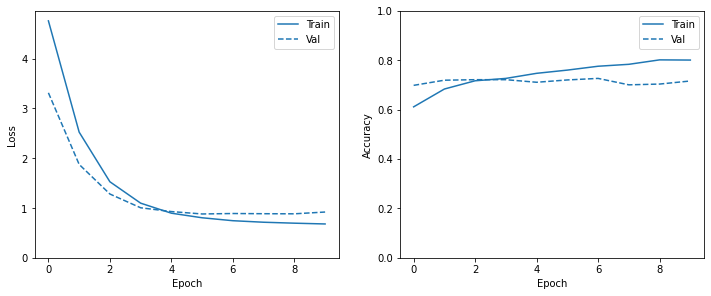

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7
              precision    recall  f1-score   support

           0       0.44      0.08      0.14        84
           1       0.74      0.82      0.78       736
           2       0.62      0.60      0.61       380

    accuracy                           0.70      1200
   macro avg       0.60      0.50      0.51      1200
weighted avg       0.68      0.70      0.68      1200



# CNN1_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 4.4826 - accuracy: 0.6466 - val_loss: 3.0627 - val_accuracy: 0.7063
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 2.3420 - accuracy: 0.7133 - val_loss: 1.8132 - val_accuracy: 0.7021
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.4540 - accuracy: 0.7401 - val_loss: 1.3101 - val_accuracy: 0.7063
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 1.0768 - accuracy: 0.7469 - val_loss: 1.0993 - val_accuracy: 0.7021
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8872 - accuracy: 0.7714 - val_loss: 0.9977 - val_accuracy: 0.6979
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8200 - accuracy: 0.7802 - val_loss: 0.9550 - val_accuracy: 0.7063
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7742 - accuracy: 0.7859 - val_loss: 0.9510 - val_accuracy: 0.6906
Epoch 8/10
60/60 [=

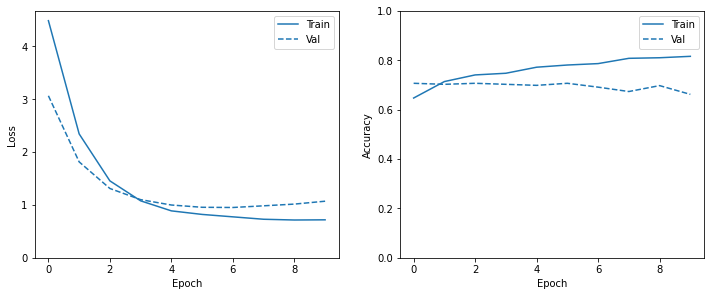

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size=64)

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.68
              precision    recall  f1-score   support

           0       0.41      0.11      0.17        84
           1       0.69      0.89      0.78       736
           2       0.67      0.40      0.50       380

    accuracy                           0.68      1200
   macro avg       0.59      0.47      0.48      1200
weighted avg       0.66      0.68      0.65      1200



# CNN2

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh' ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh' ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(128, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 32, 300)           2644800   
                                                                 
 conv1d_87 (Conv1D)          (None, 32, 64)            38464     
                                                                 
 max_pooling1d_86 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_88 (Conv1D)          (None, 16, 64)            12352     
                                                                 
 max_pooling1d_87 (MaxPoolin  (None, 8, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_89 (Conv1D)          (None, 8, 64)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 1.0032 - accuracy: 0.5977 - val_loss: 0.9567 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9380 - accuracy: 0.6146 - val_loss: 0.9241 - val_accuracy: 0.6083
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9111 - accuracy: 0.6146 - val_loss: 0.9027 - val_accuracy: 0.6083
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8929 - accuracy: 0.6146 - val_loss: 0.8880 - val_accuracy: 0.6083
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8801 - accuracy: 0.6146 - val_loss: 0.8777 - val_accuracy: 0.6083
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8714 - accuracy: 0.6146 - val_loss: 0.8704 - val_accuracy: 0.6083
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8651 - accuracy: 0.6146 - val_loss: 0.8652 - val_accuracy: 0.6083
Epoch 8/10
60/60 [=

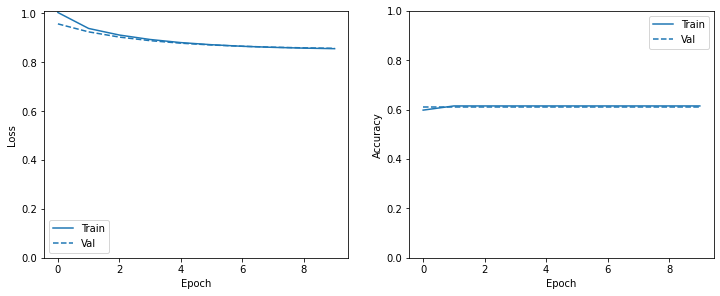

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size=64)

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.6133333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.61      1.00      0.76       736
           2       0.00      0.00      0.00       380

    accuracy                           0.61      1200
   macro avg       0.20      0.33      0.25      1200
weighted avg       0.38      0.61      0.47      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN3

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=400, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=500, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 32, 300)           2644800   
                                                                 
 conv1d_90 (Conv1D)          (None, 32, 100)           60100     
                                                                 
 max_pooling1d_89 (MaxPoolin  (None, 16, 100)          0         
 g1D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 16, 100)           0         
                                                                 
 conv1d_91 (Conv1D)          (None, 16, 200)           60200     
                                                                 
 max_pooling1d_90 (MaxPoolin  (None, 8, 200)           0         
 g1D)                                                

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 25ms/step - loss: 9.1866 - accuracy: 0.5776 - val_loss: 5.3283 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 1s 14ms/step - loss: 3.5509 - accuracy: 0.6146 - val_loss: 2.3132 - val_accuracy: 0.6083
Epoch 3/10
60/60 [==============================] - 1s 12ms/step - loss: 1.7458 - accuracy: 0.6201 - val_loss: 1.3452 - val_accuracy: 0.6104
Epoch 4/10
60/60 [==============================] - 1s 9ms/step - loss: 1.1537 - accuracy: 0.6583 - val_loss: 1.0466 - val_accuracy: 0.6740
Epoch 5/10
60/60 [==============================] - 1s 9ms/step - loss: 0.9607 - accuracy: 0.6896 - val_loss: 0.9847 - val_accuracy: 0.6333
Epoch 6/10
60/60 [==============================] - 1s 9ms/step - loss: 0.8815 - accuracy: 0.7135 - val_loss: 0.8952 - val_accuracy: 0.7229
Epoch 7/10
60/60 [==============================] - 1s 8ms/step - loss: 0.8537 - accuracy: 0.7208 - val_loss: 0.8398 - val_accuracy: 0.7271
Epoch 8/10
60/60 

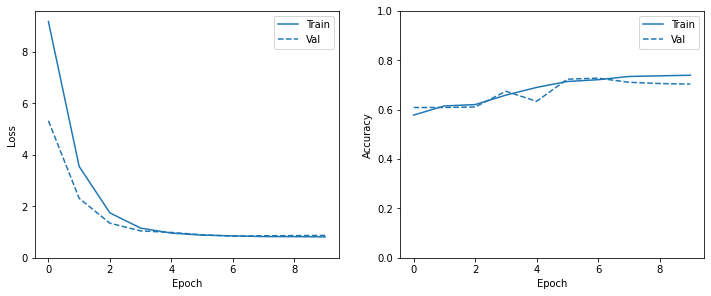

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size=64)

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7058333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.71      0.90      0.79       736
           2       0.70      0.48      0.57       380

    accuracy                           0.71      1200
   macro avg       0.47      0.46      0.45      1200
weighted avg       0.66      0.71      0.67      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 32, 300)           2644800   
                                                                 
 conv1d_95 (Conv1D)          (None, 32, 64)            38464     
                                                                 
 max_pooling1d_94 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_96 (Conv1D)          (None, 16, 32)            6176      
                                                                 
 max_pooling1d_95 (MaxPoolin  (None, 8, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_97 (Conv1D)          (None, 8, 16)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 8ms/step - loss: 2.3248 - accuracy: 0.5938 - val_loss: 1.8697 - val_accuracy: 0.6938
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 1.5799 - accuracy: 0.6958 - val_loss: 1.3840 - val_accuracy: 0.6969
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.2116 - accuracy: 0.7266 - val_loss: 1.1578 - val_accuracy: 0.7042
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 1.0202 - accuracy: 0.7456 - val_loss: 1.0793 - val_accuracy: 0.7042
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.9185 - accuracy: 0.7531 - val_loss: 0.9954 - val_accuracy: 0.7031
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8372 - accuracy: 0.7786 - val_loss: 0.9839 - val_accuracy: 0.7104
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7834 - accuracy: 0.7911 - val_loss: 0.9894 - val_accuracy: 0.6875
Epoch 8/10
60/60 [==

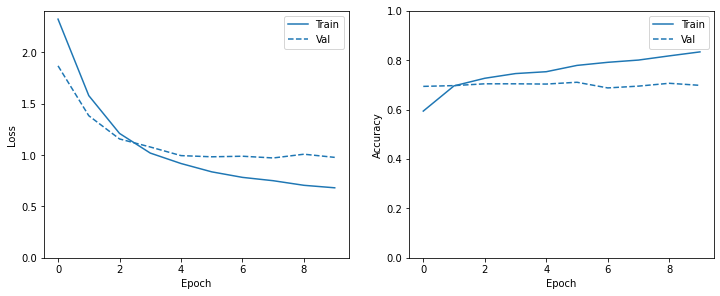

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size=64)

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.6808333333333333
              precision    recall  f1-score   support

           0       0.40      0.07      0.12        84
           1       0.74      0.79      0.76       736
           2       0.58      0.61      0.60       380

    accuracy                           0.68      1200
   macro avg       0.57      0.49      0.49      1200
weighted avg       0.66      0.68      0.66      1200



# CNN4_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 32, 300)           2644800   
                                                                 
 conv1d_99 (Conv1D)          (None, 32, 64)            38464     
                                                                 
 max_pooling1d_98 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_100 (Conv1D)         (None, 16, 32)            6176      
                                                                 
 max_pooling1d_99 (MaxPoolin  (None, 8, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_101 (Conv1D)         (None, 8, 16)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 8ms/step - loss: 2.2206 - accuracy: 0.6271 - val_loss: 1.6987 - val_accuracy: 0.6792
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 1.4066 - accuracy: 0.6943 - val_loss: 1.2285 - val_accuracy: 0.6885
Epoch 3/10
60/60 [==============================] - 0s 4ms/step - loss: 1.0656 - accuracy: 0.7279 - val_loss: 1.0183 - val_accuracy: 0.7115
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8859 - accuracy: 0.7646 - val_loss: 0.9653 - val_accuracy: 0.6927
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8090 - accuracy: 0.7656 - val_loss: 0.9045 - val_accuracy: 0.7052
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.7308 - accuracy: 0.8018 - val_loss: 0.9157 - val_accuracy: 0.6938
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.8091 - val_loss: 0.8960 - val_accuracy: 0.7281
Epoch 8/10
60/60 [==

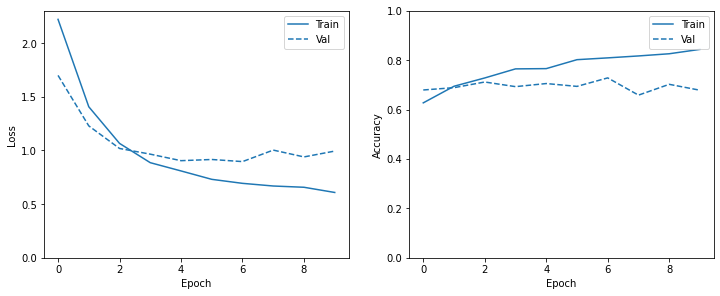

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size=64)

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.6908333333333333
              precision    recall  f1-score   support

           0       0.29      0.23      0.26        84
           1       0.75      0.78      0.77       736
           2       0.63      0.62      0.63       380

    accuracy                           0.69      1200
   macro avg       0.56      0.54      0.55      1200
weighted avg       0.68      0.69      0.69      1200



# CNN5

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 32, 300)           2644800   
                                                                 
 conv1d_103 (Conv1D)         (None, 32, 50)            30050     
                                                                 
 max_pooling1d_102 (MaxPooli  (None, 16, 50)           0         
 ng1D)                                                           
                                                                 
 conv1d_104 (Conv1D)         (None, 16, 100)           15100     
                                                                 
 max_pooling1d_103 (MaxPooli  (None, 8, 100)           0         
 ng1D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 8, 100)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 7ms/step - loss: 2.2291 - accuracy: 0.6031 - val_loss: 1.9359 - val_accuracy: 0.6521
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 1.7289 - accuracy: 0.6833 - val_loss: 1.5768 - val_accuracy: 0.6990
Epoch 3/10
60/60 [==============================] - 0s 4ms/step - loss: 1.3876 - accuracy: 0.7289 - val_loss: 1.3375 - val_accuracy: 0.7021
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - loss: 1.1480 - accuracy: 0.7513 - val_loss: 1.1536 - val_accuracy: 0.6927
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.9750 - accuracy: 0.7695 - val_loss: 1.0410 - val_accuracy: 0.7021
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8531 - accuracy: 0.7875 - val_loss: 0.9747 - val_accuracy: 0.7063
Epoch 7/10
60/60 [==============================] - 0s 4ms/step - loss: 0.7673 - accuracy: 0.8013 - val_loss: 0.9735 - val_accuracy: 0.7063
Epoch 8/10
60/60 [==

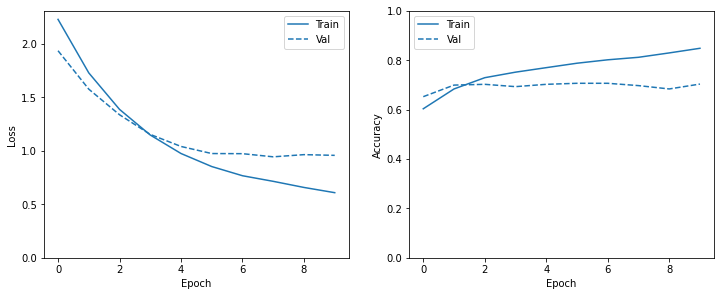

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size=64)

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7041666666666667
              precision    recall  f1-score   support

           0       0.46      0.29      0.35        84
           1       0.72      0.87      0.79       736
           2       0.69      0.48      0.56       380

    accuracy                           0.70      1200
   macro avg       0.62      0.54      0.57      1200
weighted avg       0.69      0.70      0.69      1200



# CNN5_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 32, 300)           2644800   
                                                                 
 conv1d_105 (Conv1D)         (None, 32, 50)            30050     
                                                                 
 max_pooling1d_104 (MaxPooli  (None, 16, 50)           0         
 ng1D)                                                           
                                                                 
 conv1d_106 (Conv1D)         (None, 16, 100)           15100     
                                                                 
 max_pooling1d_105 (MaxPooli  (None, 8, 100)           0         
 ng1D)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 8, 100)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 7ms/step - loss: 2.1524 - accuracy: 0.6232 - val_loss: 1.7802 - val_accuracy: 0.7104
Epoch 2/10
60/60 [==============================] - 0s 4ms/step - loss: 1.5707 - accuracy: 0.7102 - val_loss: 1.4163 - val_accuracy: 0.6958
Epoch 3/10
60/60 [==============================] - 0s 4ms/step - loss: 1.2294 - accuracy: 0.7346 - val_loss: 1.1919 - val_accuracy: 0.6979
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - loss: 1.0059 - accuracy: 0.7635 - val_loss: 1.0485 - val_accuracy: 0.6885
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8519 - accuracy: 0.7846 - val_loss: 0.9982 - val_accuracy: 0.6823
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.7585 - accuracy: 0.8039 - val_loss: 0.9415 - val_accuracy: 0.7000
Epoch 7/10
60/60 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.8266 - val_loss: 0.9756 - val_accuracy: 0.6667
Epoch 8/10
60/60 [==

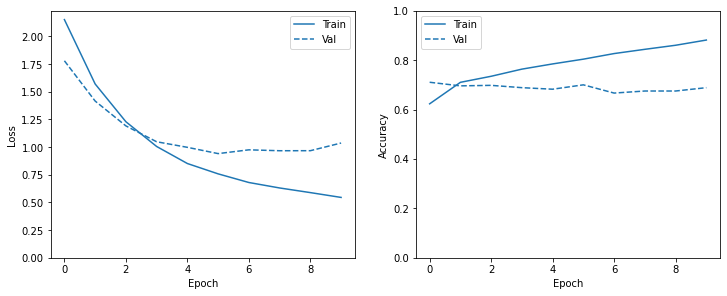

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size=64)

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7091666666666666
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        84
           1       0.73      0.87      0.79       736
           2       0.65      0.55      0.60       380

    accuracy                           0.71      1200
   macro avg       0.63      0.48      0.47      1200
weighted avg       0.69      0.71      0.68      1200



# Learn Word2Vec without lemmatize in preprocess

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 

def cleaned3(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise3(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("(#[A-Za-z0-9_]+)","", token)
        token = re.sub(r'[0-9]+', '', token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        # lemmatizer = WordNetLemmatizer()
        # token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned3(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Load Dataset1

In [ ]:
tweets_df1 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df1.shape

(6000, 3)

In [ ]:
tweets_df1.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.drop(columns=["tweet_id" ],inplace=True)

In [ ]:
tweets_df1 = tweets_df1.dropna()

In [ ]:
tweets_df1.head()

label                                         tweet_text
0      1  4,000 a day dying from the so called Covid-19 ...
1      2  Pranam message for today manifested in Dhyan b...
2      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3      1  Confirmation that Chinese #vaccines "dont hav...
4      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.loc[tweets_df1['label'] == 1, 'label'] = 0
tweets_df1.loc[tweets_df1['label'] == 2, 'label'] = 1
tweets_df1.loc[tweets_df1['label'] == 3, 'label'] = 2

#  Prerocess Dataset1
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words
### no lemmatize

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data1 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df1['tweet_text'].tolist()
Y = tweets_df1['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data1.append((tk.tokenize(x), y))

NameError: ignored

In [ ]:
cleaned_tokens_list1 = []

# Removing noise from all the data
for tokens, label in data1:
    cleaned_tokens_list1.append((remove_noise3(tokens), label))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'wb') as fp:
        pickle.dump(cleaned_tokens_list1, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'rb') as fp:
        cleaned_tokens_list1 = pickle.load(fp)

sentences_array1 = [s[0] for s in cleaned_tokens_list1]
print(sentences_array1[0])

['day', 'dying', 'called', 'covid', 'vaccine', 'reports']


# Load Dataset2

In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2.head()

user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(395683, 1)

In [ ]:
tweets_df2.head()

text
0  Australia to Manufacture Covid-19 Vaccine and ...
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...
2  Deaths due to COVID-19 in Affected Countries\n...
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...
4  @michellegrattan @ConversationEDU This is what...

#  Prerocess Dataset2
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words
### no lemmatize

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise3(tokens))

import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['australia', 'manufacture', 'covid', 'vaccine', 'give', 'citizens', 'free', 'cost', 'afp', 'quotes', 'prime', 'minister']


# Load Dataset3

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

#  Prerocess Dataset3
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words
### no lemmatize

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise3(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'rb') as fp:
        cleaned_tokens_list3 = pickle.load(fp)

sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm']


# Load Dataset4

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

#  Prerocess Dataset4
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words
### no lemmatize

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise3(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'rb') as fp:
        cleaned_tokens_list4 = pickle.load(fp)

sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['covid', 'denial', 'inaction', 'many', 'political', 'world', 'leaders', 'created', 'tsunami', 'anti-vaccine', 'mask', 'refusal', 'many', 'lockdown', 'keep', 'football', 'live', 'made', 'near', 'impossible', 'stop', 'variant', 'around', 'fox', 'propaganda']


# Combine dataset

In [ ]:
train_data = sentences_array1 + sentences_array2 + sentences_array3 + sentences_array4
len(train_data)

1387864

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec', 'wb') as fp:
        pickle.dump(train_data, fp)

# Learn Word2vec
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words
### no lemmatize

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec', 'rb') as fp:
        train_data = pickle.load(fp)

In [ ]:
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()
print('Number of cores in this device {}'.format(cores))

Number of cores in this device 2


In [ ]:
docs_num = len(train_data)
tokens_num = sum([len(x) for x in train_data])
print('Number of all tweets {}'.format(docs_num))
print('Number of all Tokens {}'.format(tokens_num))

Number of all tweets 1387864
Number of all Tokens 18519681


In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=300 , alpha=0.03 , workers=cores-1)
w2v_model.build_vocab(train_data)

CPU times: user 40.1 s, sys: 711 ms, total: 40.8 s
Wall time: 41.1 s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  203190


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 20)

CPU times: user 16min 59s, sys: 3.3 s, total: 17min 3s
Wall time: 16min 54s


(338424018, 370393620)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d_2.model")

# Prepare train and test dataset
### Preprocess include delete link,mention,hashtag,punctuation ,numbers , stop words
### no lemmatize

In [ ]:
tweets_df = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df.shape

(6000, 3)

In [ ]:
tweets_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df.drop(columns=["tweet_id"],inplace=True)

In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.loc[tweets_df['label'] == 1, 'label'] = 0
tweets_df.loc[tweets_df['label'] == 2, 'label'] = 1
tweets_df.loc[tweets_df['label'] == 3, 'label'] = 2

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df['tweet_text'].tolist()
Y = tweets_df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 0.9250755310058594


[(['4,000',
   'a',
   'day',
   'dying',
   'from',
   'the',
   'so',
   'called',
   'Covid',
   '-',
   '19',
   '\x93',
   'vaccine',
   '\x94',
   '@DailyBeast',
   'reports',
   '.',
   '#vaccine',
   '#PfizerVaccine',
   '#Moderna',
   'https://t.co/p1nQWWZpk4'],
  0),
 (['Pranam',
   'message',
   'for',
   'today',
   'manifested',
   'in',
   'Dhyan',
   'by',
   '@meenapranam',
   '#truth',
   '#love',
   '#karm',
   '#light',
   '#nature',
   '#consciousness',
   '#FridayThoughts',
   '#fridaymorning',
   '#CoronavirusIndia',
   '#COVID19India',
   '#',
   '?',
   '?',
   '?',
   '_',
   '?',
   '?',
   '?',
   '#navratri',
   '#Thane',
   '#AmbedkarJayanti2021',
   '#ModiJi',
   '#NarendraModi',
   '#SecondCOVIDWave',
   '#Covaxin',
   'https://t.co/bQNoMVowJg'],
  1),
 (['Hyderabad-based',
   '?',
   '@BharatBiotech',
   '?',
   'has',
   'sought',
   'funds',
   'from',
   'the',
   'government',
   'to',
   'ramp',
   'up',
   'production',
   'of',
   'its',
   'indig

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 
def cleaned3(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise3(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("(#[A-Za-z0-9_]+)","", token)
        token = re.sub(r'[0-9]+', '', token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        # lemmatizer = WordNetLemmatizer()
        # token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned3(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise3(data[0][0]))

['day', 'dying', 'called', 'covid', 'vaccine', 'reports']


In [ ]:
cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise3(tokens), label))

In [ ]:
sentences_array = [s[0] for s in cleaned_tokens_list]
sentences = []

for s in sentences_array :
  sentence = ' '.join(map(str ,s))
  sentences.append(sentence)

print(sentences[0])
print(sentences_array[0])

day dying called covid vaccine reports
['day', 'dying', 'called', 'covid', 'vaccine', 'reports']


In [ ]:
# find number of unique words i train list
all_train_word = []

for i in range(len(sentences_array)) :
  all_train_word += sentences_array[i]

print('all words in dataset1 number (after preprocess): {}'.format(len(all_train_word)))

uniqueWords = [] 
for i in all_train_word:
  if not i in uniqueWords:
      uniqueWords.append(i)


print('unique words in dataset1 number (after preprocess): {}'.format(len(uniqueWords)))

all words in dataset1 number (after preprocess): 69187
unique words in dataset1 number (after preprocess): 10229


In [ ]:
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

max_len: 32


In [ ]:
Y = np.zeros((len(cleaned_tokens_list), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    Y[i] = label

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [ ]:
X_sequences = tokenizer.texts_to_sequences(sentences)
X_sequences[2]

[1126,
 199,
 3324,
 1857,
 87,
 963,
 70,
 1127,
 128,
 3,
 1,
 142,
 2607,
 1208,
 413,
 963]

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X_sequences,maxlen=max_len ,padding='post')
X_padded = np.array(X_padded)
X_padded[2]

array([1126,  199, 3324, 1857,   87,  963,   70, 1127,  128,    3,    1,
        142, 2607, 1208,  413,  963,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train.shape)
print(Y_train.shape)

(4800, 32)
(4800,)


In [ ]:
# Python program to store list to file using pickle module
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec3', 'wb') as fp:
        pickle.dump(X_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtestVec3', 'wb') as fp:
        pickle.dump(X_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec3', 'wb') as fp:
        pickle.dump(Y_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec3', 'wb') as fp:
        pickle.dump(Y_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec', 'rb') as fp:
#         X_train =  pickle.load(fp)
         
# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec', 'rb') as fp:
#         X_test =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec', 'rb') as fp:
#         Y_train =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec', 'rb') as fp:
#         Y_test =  pickle.load(fp)

# Make embedding Matrix

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_2.model")

In [ ]:
EMBEDDING_DIM=300
vocabulary_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

i = 0
for word,i in tokenizer.word_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
         pass
        
       
    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix2', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

(9996, 300)
[ 1.40195236e-01  1.12083983e+00 -4.87348199e-01 -1.18722264e-02
 -1.06934831e-01  1.63374746e+00  7.70498574e-01  1.25433099e+00
  8.90887618e-01  2.24118754e-02  4.84914511e-01 -2.53839850e+00
  6.59059227e-01  1.43809271e+00 -5.29869974e-01  8.97584140e-01
  1.05755225e-01  9.75278392e-02 -1.80449709e-01  6.69358790e-01
  2.90729791e-01  1.78417340e-01  9.18459177e-01 -1.02414954e+00
 -3.94917876e-01  1.45422125e+00 -1.33503437e+00  5.72348118e-01
 -2.81069785e-01  1.38381350e+00  8.81582081e-01  6.38593793e-01
  7.66751945e-01  1.01502728e+00 -3.25940758e-01  3.20123076e-01
 -2.24762034e+00  3.91981184e-01  3.05183828e-02  1.84608608e-01
  1.17415941e+00  6.20623946e-01 -1.16399693e+00 -1.98460102e+00
  1.37564349e+00  8.80653501e-01  3.01480174e-01 -3.08391869e-01
  2.11686298e-01  7.62464523e-01  8.51756573e-01 -9.09196258e-01
 -3.56532514e-01  1.51808703e+00 -1.57958150e+00  9.72179949e-01
 -1.08589160e+00 -2.26001203e-01 -2.73142695e-01  9.02360141e-01
  2.02966404e

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix2', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

In [ ]:
zero_rows_UNK = np.where(~embedding_matrix.any(axis=1))[0]
len(zero_rows_UNK)

89

# CNN1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 18ms/step - loss: 4.8440 - accuracy: 0.5930 - val_loss: 3.3826 - val_accuracy: 0.6823
Epoch 2/10
60/60 [==============================] - 1s 9ms/step - loss: 2.5717 - accuracy: 0.6971 - val_loss: 1.9664 - val_accuracy: 0.7208
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 1.5626 - accuracy: 0.7234 - val_loss: 1.3330 - val_accuracy: 0.6938
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 1.1096 - accuracy: 0.7474 - val_loss: 1.0763 - val_accuracy: 0.7167
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9206 - accuracy: 0.7513 - val_loss: 0.9258 - val_accuracy: 0.7229
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7931 - accuracy: 0.7693 - val_loss: 0.9047 - val_accuracy: 0.7052
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7441 - accuracy: 0.7776 - val_loss: 0.8928 - val_accuracy: 0.6927
Epoch 8/10
60/60 [=

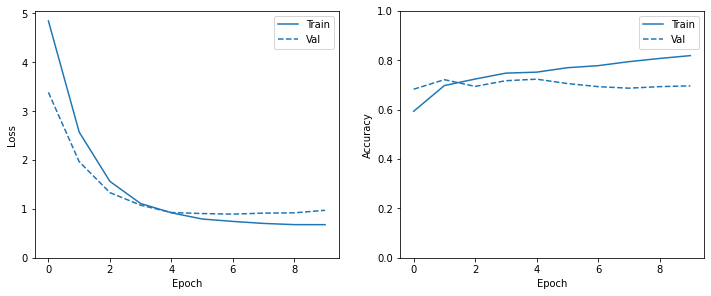

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.6783333333333333
              precision    recall  f1-score   support

           0       0.14      0.01      0.02        84
           1       0.75      0.76      0.76       736
           2       0.56      0.67      0.61       380

    accuracy                           0.68      1200
   macro avg       0.49      0.48      0.46      1200
weighted avg       0.65      0.68      0.66      1200



# CNN1_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 32, 300)           2998800   
                                                                 
 conv1d_58 (Conv1D)          (None, 32, 100)           60100     
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 16, 100)          0         
 g1D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 16, 100)           0         
                                                                 
 conv1d_59 (Conv1D)          (None, 16, 200)           60200     
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 8, 200)           0         
 g1D)                                                

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 4.4658 - accuracy: 0.6458 - val_loss: 3.0747 - val_accuracy: 0.7083
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 2.3100 - accuracy: 0.7242 - val_loss: 1.7934 - val_accuracy: 0.7073
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.4317 - accuracy: 0.7435 - val_loss: 1.2869 - val_accuracy: 0.7031
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 1.0455 - accuracy: 0.7641 - val_loss: 1.0928 - val_accuracy: 0.6865
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8811 - accuracy: 0.7693 - val_loss: 1.0161 - val_accuracy: 0.6906
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8057 - accuracy: 0.7758 - val_loss: 0.9668 - val_accuracy: 0.6969
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7459 - accuracy: 0.8023 - val_loss: 1.0045 - val_accuracy: 0.7021
Epoch 8/10
60/60 [==

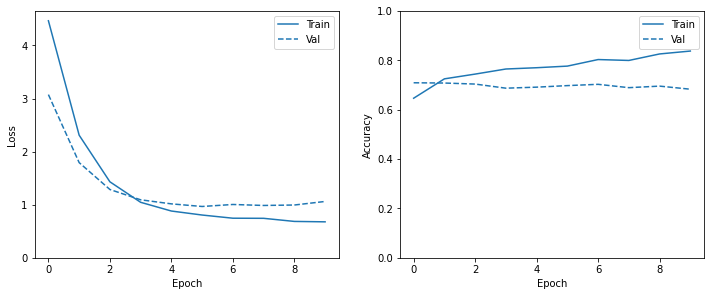

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.6825
              precision    recall  f1-score   support

           0       0.33      0.11      0.16        84
           1       0.70      0.88      0.78       736
           2       0.67      0.42      0.52       380

    accuracy                           0.68      1200
   macro avg       0.57      0.47      0.49      1200
weighted avg       0.66      0.68      0.65      1200



# CNN2

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh' ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh' ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(128, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 32, 300)           2998800   
                                                                 
 conv1d_61 (Conv1D)          (None, 32, 64)            38464     
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_62 (Conv1D)          (None, 16, 64)            12352     
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 8, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_63 (Conv1D)          (None, 8, 64)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 17ms/step - loss: 1.0088 - accuracy: 0.6016 - val_loss: 0.9623 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9383 - accuracy: 0.6146 - val_loss: 0.9230 - val_accuracy: 0.6083
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 0.9085 - accuracy: 0.6146 - val_loss: 0.9006 - val_accuracy: 0.6083
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8902 - accuracy: 0.6146 - val_loss: 0.8858 - val_accuracy: 0.6083
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8779 - accuracy: 0.6146 - val_loss: 0.8758 - val_accuracy: 0.6083
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8695 - accuracy: 0.6146 - val_loss: 0.8689 - val_accuracy: 0.6083
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8637 - accuracy: 0.6146 - val_loss: 0.8639 - val_accuracy: 0.6083
Epoch 8/10
60/60 [=

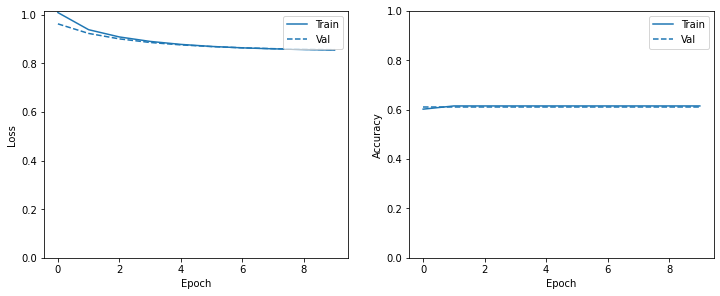

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.6133333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.61      1.00      0.76       736
           2       0.00      0.00      0.00       380

    accuracy                           0.61      1200
   macro avg       0.20      0.33      0.25      1200
weighted avg       0.38      0.61      0.47      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN3

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=400, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=500, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 32, 300)           2998800   
                                                                 
 conv1d_64 (Conv1D)          (None, 32, 100)           60100     
                                                                 
 max_pooling1d_63 (MaxPoolin  (None, 16, 100)          0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 16, 100)           0         
                                                                 
 conv1d_65 (Conv1D)          (None, 16, 200)           60200     
                                                                 
 max_pooling1d_64 (MaxPoolin  (None, 8, 200)           0         
 g1D)                                                

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 21ms/step - loss: 9.3296 - accuracy: 0.5938 - val_loss: 5.6377 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 1s 10ms/step - loss: 3.7861 - accuracy: 0.6146 - val_loss: 2.5303 - val_accuracy: 0.6521
Epoch 3/10
60/60 [==============================] - 1s 11ms/step - loss: 1.8682 - accuracy: 0.6326 - val_loss: 1.4098 - val_accuracy: 0.6760
Epoch 4/10
60/60 [==============================] - 1s 9ms/step - loss: 1.2026 - accuracy: 0.6865 - val_loss: 1.0521 - val_accuracy: 0.7083
Epoch 5/10
60/60 [==============================] - 1s 9ms/step - loss: 0.9738 - accuracy: 0.7104 - val_loss: 0.9383 - val_accuracy: 0.7156
Epoch 6/10
60/60 [==============================] - 1s 9ms/step - loss: 0.8788 - accuracy: 0.7357 - val_loss: 0.9073 - val_accuracy: 0.7094
Epoch 7/10
60/60 [==============================] - 1s 9ms/step - loss: 0.8444 - accuracy: 0.7383 - val_loss: 0.8881 - val_accuracy: 0.7115
Epoch 8/10
60/60 

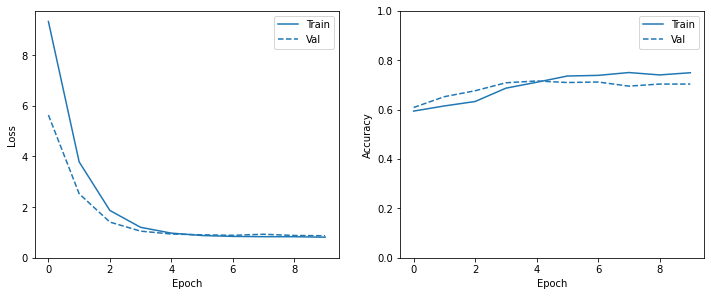

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.6875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.76      0.79      0.77       736
           2       0.57      0.64      0.60       380

    accuracy                           0.69      1200
   macro avg       0.44      0.48      0.46      1200
weighted avg       0.64      0.69      0.66      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
 
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 32, 300)           2998800   
                                                                 
 conv1d_69 (Conv1D)          (None, 32, 64)            38464     
                                                                 
 max_pooling1d_68 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_70 (Conv1D)          (None, 16, 32)            6176      
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 8, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_71 (Conv1D)          (None, 8, 16)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 11ms/step - loss: 2.2627 - accuracy: 0.6102 - val_loss: 1.7576 - val_accuracy: 0.6521
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.4658 - accuracy: 0.6714 - val_loss: 1.2720 - val_accuracy: 0.6812
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0979 - accuracy: 0.7232 - val_loss: 1.0203 - val_accuracy: 0.7229
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9236 - accuracy: 0.7443 - val_loss: 0.9305 - val_accuracy: 0.7240
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8369 - accuracy: 0.7552 - val_loss: 0.8979 - val_accuracy: 0.7177
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7769 - accuracy: 0.7716 - val_loss: 0.8774 - val_accuracy: 0.7177
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7425 - accuracy: 0.7849 - val_loss: 0.9132 - val_accuracy: 0.6823
Epoch 8/10
60/60 [=

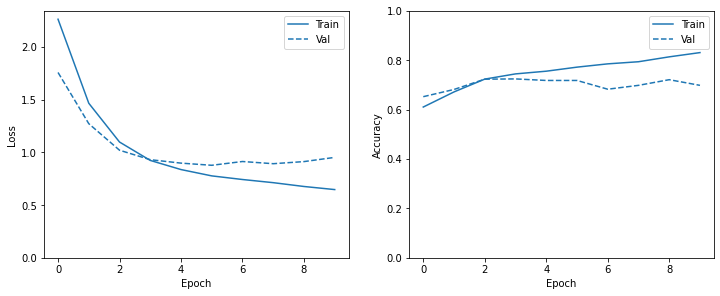

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.6866666666666666
              precision    recall  f1-score   support

           0       0.28      0.14      0.19        84
           1       0.73      0.83      0.78       736
           2       0.63      0.53      0.57       380

    accuracy                           0.69      1200
   macro avg       0.55      0.50      0.51      1200
weighted avg       0.67      0.69      0.67      1200



# CNN4_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
 
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 32, 300)           2998800   
                                                                 
 conv1d_73 (Conv1D)          (None, 32, 64)            38464     
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 16, 32)            6176      
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 8, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_75 (Conv1D)          (None, 8, 16)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 16ms/step - loss: 2.1953 - accuracy: 0.6305 - val_loss: 1.6767 - val_accuracy: 0.7125
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.3931 - accuracy: 0.7096 - val_loss: 1.1963 - val_accuracy: 0.7115
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 1.0326 - accuracy: 0.7471 - val_loss: 1.0156 - val_accuracy: 0.7031
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8656 - accuracy: 0.7711 - val_loss: 0.9320 - val_accuracy: 0.6990
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7865 - accuracy: 0.7797 - val_loss: 0.9217 - val_accuracy: 0.6948
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7346 - accuracy: 0.7977 - val_loss: 0.9339 - val_accuracy: 0.7083
Epoch 7/10
60/60 [==============================] - 1s 9ms/step - loss: 0.6958 - accuracy: 0.8102 - val_loss: 0.9007 - val_accuracy: 0.7156
Epoch 8/10
60/60 [=

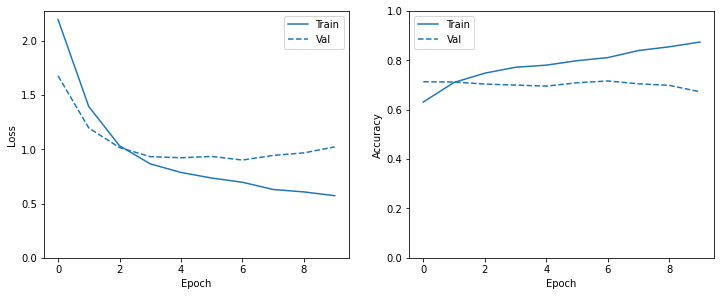

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.6608333333333334
              precision    recall  f1-score   support

           0       0.27      0.27      0.27        84
           1       0.73      0.79      0.76       736
           2       0.60      0.50      0.54       380

    accuracy                           0.66      1200
   macro avg       0.53      0.52      0.52      1200
weighted avg       0.65      0.66      0.66      1200



# CNN5

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 32, 300)           2998800   
                                                                 
 conv1d_77 (Conv1D)          (None, 32, 50)            30050     
                                                                 
 max_pooling1d_76 (MaxPoolin  (None, 16, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_78 (Conv1D)          (None, 16, 100)           15100     
                                                                 
 max_pooling1d_77 (MaxPoolin  (None, 8, 100)           0         
 g1D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 8, 100)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 11ms/step - loss: 2.2246 - accuracy: 0.6086 - val_loss: 1.8828 - val_accuracy: 0.6865
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.6877 - accuracy: 0.6945 - val_loss: 1.5204 - val_accuracy: 0.7063
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.3414 - accuracy: 0.7326 - val_loss: 1.2828 - val_accuracy: 0.6969
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1036 - accuracy: 0.7656 - val_loss: 1.1275 - val_accuracy: 0.6938
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9620 - accuracy: 0.7708 - val_loss: 1.0317 - val_accuracy: 0.7083
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8223 - accuracy: 0.8076 - val_loss: 1.0019 - val_accuracy: 0.6969
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7388 - accuracy: 0.8221 - val_loss: 0.9497 - val_accuracy: 0.7042
Epoch 8/10
60/60 [=

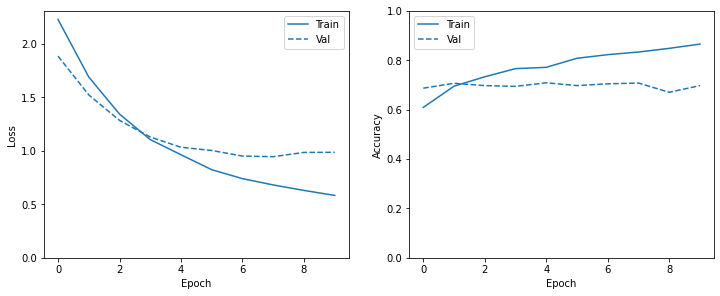

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.6941666666666667
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        84
           1       0.74      0.82      0.78       736
           2       0.61      0.59      0.60       380

    accuracy                           0.69      1200
   macro avg       0.61      0.50      0.51      1200
weighted avg       0.68      0.69      0.67      1200



# CNN5_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 32, 300)           2998800   
                                                                 
 conv1d_79 (Conv1D)          (None, 32, 50)            30050     
                                                                 
 max_pooling1d_78 (MaxPoolin  (None, 16, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_80 (Conv1D)          (None, 16, 100)           15100     
                                                                 
 max_pooling1d_79 (MaxPoolin  (None, 8, 100)           0         
 g1D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 8, 100)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 2.1495 - accuracy: 0.6221 - val_loss: 1.7833 - val_accuracy: 0.6917
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.5621 - accuracy: 0.7138 - val_loss: 1.4084 - val_accuracy: 0.6969
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.2044 - accuracy: 0.7500 - val_loss: 1.1666 - val_accuracy: 0.7167
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9790 - accuracy: 0.7695 - val_loss: 1.0438 - val_accuracy: 0.7094
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8321 - accuracy: 0.7917 - val_loss: 1.0104 - val_accuracy: 0.6948
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7301 - accuracy: 0.8216 - val_loss: 0.9627 - val_accuracy: 0.7083
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6829 - accuracy: 0.8250 - val_loss: 0.9395 - val_accuracy: 0.7104
Epoch 8/10
60/60 [=

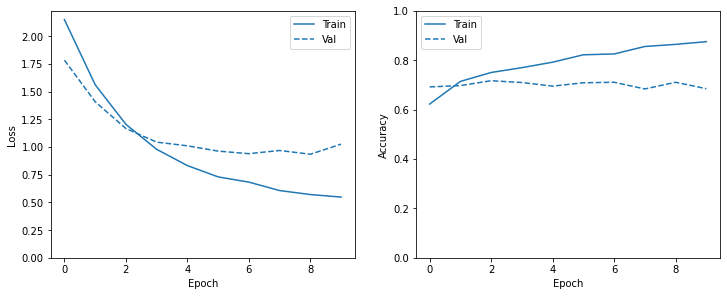

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.6758333333333333
              precision    recall  f1-score   support

           0       0.41      0.30      0.34        84
           1       0.70      0.88      0.78       736
           2       0.67      0.37      0.48       380

    accuracy                           0.68      1200
   macro avg       0.59      0.52      0.53      1200
weighted avg       0.67      0.68      0.65      1200



# Preprocess 
### delete links and mentions and pancutation

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise4(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)


        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

# Load Dataset1

In [ ]:
tweets_df1 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding='unicode_escape')
tweets_df1.shape

(6000, 3)

In [ ]:
tweets_df1.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.drop(columns=["tweet_id" ],inplace=True)

In [ ]:
tweets_df1 = tweets_df1.dropna()

In [ ]:
tweets_df1.head()

label                                         tweet_text
0      1  4,000 a day dying from the so called Covid-19 ...
1      2  Pranam message for today manifested in Dhyan b...
2      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3      1  Confirmation that Chinese #vaccines "dont hav...
4      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.loc[tweets_df1['label'] == 1, 'label'] = 0
tweets_df1.loc[tweets_df1['label'] == 2, 'label'] = 1
tweets_df1.loc[tweets_df1['label'] == 3, 'label'] = 2

# Preprocess Datset1
### delete links and mentions and pancutation

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data1 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df1['tweet_text'].tolist()
Y = tweets_df1['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data1.append((tk.tokenize(x), y))

In [ ]:
cleaned_tokens_list1 = []

# Removing noise from all the data
for tokens, label in data1:
    cleaned_tokens_list1.append((remove_noise4(tokens), label))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'wb') as fp:
        pickle.dump(cleaned_tokens_list1, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'rb') as fp:
        cleaned_tokens_list1 = pickle.load(fp)

sentences_array1 = [s[0] for s in cleaned_tokens_list1]
print(sentences_array1[0])

['a', 'day', 'dying', 'from', 'the', 'so', 'called', 'Covid', 'vaccine', 'reports', '#vaccine', '#PfizerVaccine', '#Moderna']


# Load Dataset2

In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

In [ ]:
tweets_df2.head()

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

In [ ]:
tweets_df2.head()

# Preprocess Datset2
### delete links and mentions and pancutation

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise4(tokens))

import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['Australia', 'to', 'Manufacture', 'Covid', 'Vaccine', 'and', 'give', 'it', 'to', 'the', 'Citizens', 'for', 'free', 'of', 'cost', 'AFP', 'quotes', 'Prime', 'Minister', '#CovidVaccine']


# Load Dataset3

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
  tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

# Preprocess Datset3
### delete links and mentions and pancutation

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise4(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'rb') as fp:
        cleaned_tokens_list3 = pickle.load(fp)

sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['Same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'a', 'cytokine', 'storm', '#PfizerBioNTech']


# Load Dataset4

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

# Preprocess Datset4
### delete links and mentions and pancutation

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise4(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'rb') as fp:
        cleaned_tokens_list4 = pickle.load(fp)

sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['Covid', 'denial', 'and', 'inaction', 'from', 'many', 'political', 'World', 'leaders', 'in', 'created', 'this', 'tsunami', 'of', 'anti-vaccine', 'and', 'mask', 'The', 'refusal', 'of', 'many', 'to', 'go', 'into', 'lockdown', 'and', 'to', 'keep', 'their', 'football', 'live', 'made', 'it', 'near', 'impossible', 'to', 'stop', 'variant', 'Now', "it's", 'all', 'around', 'me', 'Fu', 'k', 'you', 'FOX', 'propaganda']


# Combine Datasets

In [ ]:
train_data = sentences_array1 + sentences_array2 + sentences_array3 + sentences_array4
len(train_data)

1387864

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'wb') as fp:
        pickle.dump(train_data, fp)

# Learn Word2vec Skip Gram
### Preprocess include delete link,mentions and panctuations


In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'rb') as fp:
        train_data = pickle.load(fp)

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=300  , workers=4 ,sg = 1)
w2v_model.build_vocab(train_data)

CPU times: user 1min 34s, sys: 1.22 s, total: 1min 36s
Wall time: 1min 38s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  380005


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 30)

CPU times: user 5h 27min 42s, sys: 35.3 s, total: 5h 28min 18s
Wall time: 2h 49min 43s


(900896334, 1117663050)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d_3.model")

# Prepare train and test dataset
### Preprocess include delete link,mentions and panctuations

In [ ]:
tweets_df = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df.shape

(6000, 3)

In [ ]:
tweets_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df.drop(columns=["tweet_id"],inplace=True)

In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.loc[tweets_df['label'] == 1, 'label'] = 0
tweets_df.loc[tweets_df['label'] == 2, 'label'] = 1
tweets_df.loc[tweets_df['label'] == 3, 'label'] = 2

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df['tweet_text'].tolist()
Y = tweets_df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 0.9425256252288818


[(['4,000',
   'a',
   'day',
   'dying',
   'from',
   'the',
   'so',
   'called',
   'Covid',
   '-',
   '19',
   '\x93',
   'vaccine',
   '\x94',
   '@DailyBeast',
   'reports',
   '.',
   '#vaccine',
   '#PfizerVaccine',
   '#Moderna',
   'https://t.co/p1nQWWZpk4'],
  0),
 (['Pranam',
   'message',
   'for',
   'today',
   'manifested',
   'in',
   'Dhyan',
   'by',
   '@meenapranam',
   '#truth',
   '#love',
   '#karm',
   '#light',
   '#nature',
   '#consciousness',
   '#FridayThoughts',
   '#fridaymorning',
   '#CoronavirusIndia',
   '#COVID19India',
   '#',
   '?',
   '?',
   '?',
   '_',
   '?',
   '?',
   '?',
   '#navratri',
   '#Thane',
   '#AmbedkarJayanti2021',
   '#ModiJi',
   '#NarendraModi',
   '#SecondCOVIDWave',
   '#Covaxin',
   'https://t.co/bQNoMVowJg'],
  1),
 (['Hyderabad-based',
   '?',
   '@BharatBiotech',
   '?',
   'has',
   'sought',
   'funds',
   'from',
   'the',
   'government',
   'to',
   'ramp',
   'up',
   'production',
   'of',
   'its',
   'indig

In [ ]:
cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise4(tokens), label))

In [ ]:
sentences_array = [s[0] for s in cleaned_tokens_list]
sentences = []

for s in sentences_array :
  sentence = ' '.join(map(str ,s))
  sentences.append(sentence)

print(sentences[0])
print(sentences_array[0])

a day dying from the so called Covid vaccine reports #vaccine #PfizerVaccine #Moderna
['a', 'day', 'dying', 'from', 'the', 'so', 'called', 'Covid', 'vaccine', 'reports', '#vaccine', '#PfizerVaccine', '#Moderna']


In [ ]:
# find number of unique words i train list
all_train_word = []

for i in range(len(sentences_array)) :
  all_train_word += sentences_array[i]

print('all words in dataset1 number (after preprocess): {}'.format(len(all_train_word)))

uniqueWords = [] 
for i in all_train_word:
  if not i in uniqueWords:
      uniqueWords.append(i)


print('unique words in dataset1 number (after preprocess): {}'.format(len(uniqueWords)))

all words in dataset1 number (after preprocess): 146596
unique words in dataset1 number (after preprocess): 18100


In [ ]:
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

max_len: 57


In [ ]:
Y = np.zeros((len(cleaned_tokens_list), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    Y[i] = label

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [ ]:
X_sequences = tokenizer.texts_to_sequences(sentences)
X_sequences[2]

[1054,
 345,
 34,
 4131,
 2327,
 33,
 1,
 183,
 2,
 1246,
 79,
 171,
 3,
 89,
 1442,
 252,
 5,
 4,
 12,
 1,
 268,
 34,
 3256,
 2,
 1,
 1545,
 355,
 605,
 2,
 1246,
 79]

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X_sequences,maxlen=max_len ,padding='post')
X_padded = np.array(X_padded)
X_padded[2]

array([1054,  345,   34, 4131, 2327,   33,    1,  183,    2, 1246,   79,
        171,    3,   89, 1442,  252,    5,    4,   12,    1,  268,   34,
       3256,    2,    1, 1545,  355,  605,    2, 1246,   79,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train.shape)
print(Y_train.shape)

(4800, 57)
(4800,)


In [ ]:
# Python program to store list to file using pickle module
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec4', 'wb') as fp:
        pickle.dump(X_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtestVec4', 'wb') as fp:
        pickle.dump(X_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec4', 'wb') as fp:
        pickle.dump(Y_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec4', 'wb') as fp:
        pickle.dump(Y_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec4', 'rb') as fp:
#         X_train =  pickle.load(fp)
         
# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec4', 'rb') as fp:
#         X_test =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec4', 'rb') as fp:
#         Y_train =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec4', 'rb') as fp:
#         Y_test =  pickle.load(fp)

# Make Embedding Matrix

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_3.model")

In [ ]:
EMBEDDING_DIM=300
vocabulary_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

i = 0
for word,i in tokenizer.word_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
         pass
        
       
    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix3', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

(13514, 300)
[-2.28572506e-02  1.43414348e-01 -6.07503057e-01  4.26499397e-01
  1.50704816e-01 -2.60935053e-02 -4.79876637e-01 -1.20300166e-01
  2.72823244e-01 -1.54351249e-01 -2.07300603e-01 -1.14984885e-01
  1.05702899e-01 -7.79225826e-02  4.74962555e-02  3.70011300e-01
  8.04342926e-02  1.29109085e-01 -1.82235852e-01 -1.43831745e-01
 -2.55711824e-01 -1.39936462e-01  3.97888795e-02  1.18144833e-01
  9.78185236e-02 -1.33348852e-01  4.61942643e-01 -1.61446840e-01
  3.38312611e-02 -1.29552752e-01  1.35718241e-01  3.70391965e-01
 -1.41765475e-01  1.27604991e-01  2.10921038e-02 -2.42611572e-01
 -2.87756562e-01  2.22542003e-01 -1.87224373e-02 -1.01711206e-01
 -1.61992341e-01 -6.99999928e-02  1.03210501e-01 -3.37488316e-02
 -1.22976072e-01  2.67221350e-02  1.44129440e-01  2.00923726e-01
 -1.38486043e-01 -2.70129517e-02 -4.88837399e-02  2.53488749e-01
  1.44774392e-01 -1.03396267e-01  1.32782876e-01 -2.97987193e-01
 -4.61383909e-01  2.99790889e-01 -2.55599618e-01 -2.86914408e-01
  2.00602740

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix3', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

In [ ]:
zero_rows_UNK = np.where(~embedding_matrix.any(axis=1))[0]
len(zero_rows_UNK)

3703

# CNN1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=13514 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=57,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 15ms/step - loss: 3.3119 - accuracy: 0.6060 - val_loss: 1.5148 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 1s 9ms/step - loss: 1.1171 - accuracy: 0.6208 - val_loss: 0.9074 - val_accuracy: 0.6479
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8534 - accuracy: 0.6661 - val_loss: 0.8115 - val_accuracy: 0.7083
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7955 - accuracy: 0.6953 - val_loss: 0.7883 - val_accuracy: 0.7219
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7730 - accuracy: 0.7185 - val_loss: 0.7926 - val_accuracy: 0.6927
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7548 - accuracy: 0.7349 - val_loss: 0.7731 - val_accuracy: 0.7281
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7362 - accuracy: 0.7375 - val_loss: 0.7902 - val_accuracy: 0.7083
Epoch 8/10
60/60 [=

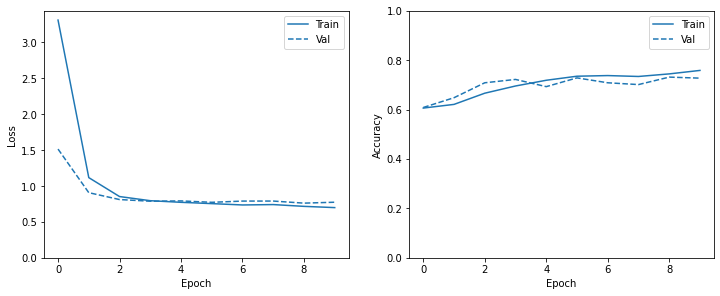

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.7241666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.72      0.93      0.81       736
           2       0.75      0.49      0.59       380

    accuracy                           0.72      1200
   macro avg       0.49      0.47      0.47      1200
weighted avg       0.68      0.72      0.68      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN1_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 57, 300)           4054200   
                                                                 
 conv1d_15 (Conv1D)          (None, 57, 100)           60100     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 28, 100)          0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 28, 100)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 28, 200)           60200     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 14, 200)          0         
 g1D)                                                

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 13ms/step - loss: 3.7254 - accuracy: 0.6365 - val_loss: 1.9967 - val_accuracy: 0.6781
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 1.4027 - accuracy: 0.6984 - val_loss: 1.0713 - val_accuracy: 0.6823
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9418 - accuracy: 0.7128 - val_loss: 0.8795 - val_accuracy: 0.7083
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8193 - accuracy: 0.7229 - val_loss: 0.8323 - val_accuracy: 0.6917
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7893 - accuracy: 0.7128 - val_loss: 0.7788 - val_accuracy: 0.7240
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7575 - accuracy: 0.7341 - val_loss: 0.7808 - val_accuracy: 0.7115
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7307 - accuracy: 0.7471 - val_loss: 0.7730 - val_accuracy: 0.7281
Epoch 8/10
60/60 [=

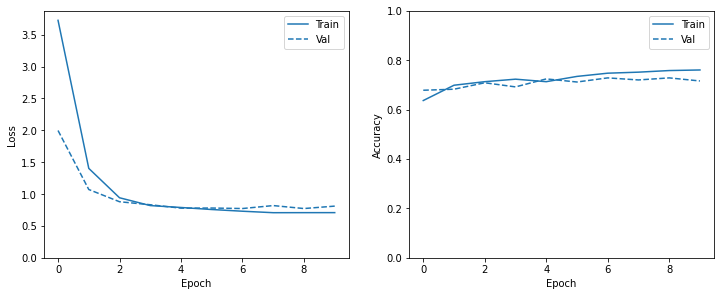

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7108333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.76      0.81      0.79       736
           2       0.61      0.67      0.64       380

    accuracy                           0.71      1200
   macro avg       0.46      0.49      0.48      1200
weighted avg       0.66      0.71      0.69      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN2

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh' ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh' ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(128, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 57, 300)           4054200   
                                                                 
 conv1d_18 (Conv1D)          (None, 57, 64)            38464     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 28, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 28, 64)            12352     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 14, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 14, 64)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 14ms/step - loss: 1.0054 - accuracy: 0.5961 - val_loss: 0.9650 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9459 - accuracy: 0.6146 - val_loss: 0.9317 - val_accuracy: 0.6083
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9179 - accuracy: 0.6146 - val_loss: 0.9092 - val_accuracy: 0.6083
Epoch 4/10
60/60 [==============================] - 1s 9ms/step - loss: 0.8984 - accuracy: 0.6146 - val_loss: 0.8931 - val_accuracy: 0.6083
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8846 - accuracy: 0.6146 - val_loss: 0.8819 - val_accuracy: 0.6083
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8749 - accuracy: 0.6146 - val_loss: 0.8736 - val_accuracy: 0.6083
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8679 - accuracy: 0.6146 - val_loss: 0.8676 - val_accuracy: 0.6083
Epoch 8/10
60/60 [=

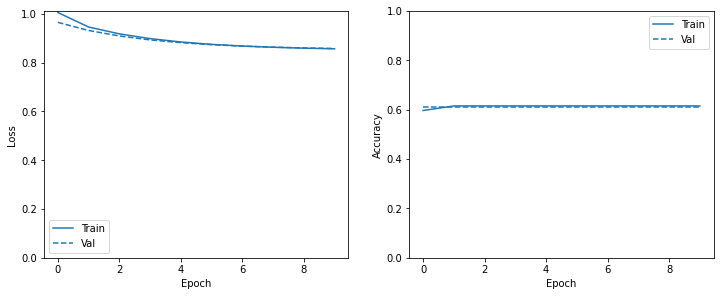

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 6ms/step
Accuracy of prediction on test set :  0.6133333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.61      1.00      0.76       736
           2       0.00      0.00      0.00       380

    accuracy                           0.61      1200
   macro avg       0.20      0.33      0.25      1200
weighted avg       0.38      0.61      0.47      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN3

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=400, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=500, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 57, 300)           4054200   
                                                                 
 conv1d_21 (Conv1D)          (None, 57, 100)           60100     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 28, 100)          0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 28, 100)           0         
                                                                 
 conv1d_22 (Conv1D)          (None, 28, 200)           60200     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 14, 200)          0         
 g1D)                                                

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 19ms/step - loss: 6.8580 - accuracy: 0.6049 - val_loss: 2.5093 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 1s 10ms/step - loss: 1.5387 - accuracy: 0.6146 - val_loss: 1.0566 - val_accuracy: 0.6083
Epoch 3/10
60/60 [==============================] - 1s 10ms/step - loss: 0.9484 - accuracy: 0.6201 - val_loss: 0.8797 - val_accuracy: 0.6375
Epoch 4/10
60/60 [==============================] - 1s 11ms/step - loss: 0.8715 - accuracy: 0.6516 - val_loss: 0.8740 - val_accuracy: 0.6750
Epoch 5/10
60/60 [==============================] - 1s 11ms/step - loss: 0.8551 - accuracy: 0.6516 - val_loss: 0.8427 - val_accuracy: 0.6719
Epoch 6/10
60/60 [==============================] - 1s 10ms/step - loss: 0.8327 - accuracy: 0.6789 - val_loss: 0.8294 - val_accuracy: 0.6812
Epoch 7/10
60/60 [==============================] - 1s 11ms/step - loss: 0.8155 - accuracy: 0.6938 - val_loss: 0.8224 - val_accuracy: 0.6927
Epoch 8/10
60

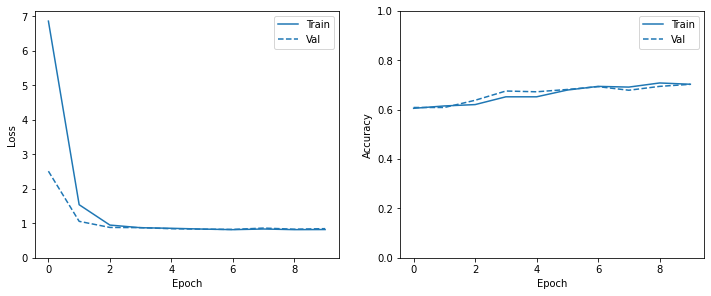

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.7025
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.79      0.77      0.78       736
           2       0.57      0.73      0.64       380

    accuracy                           0.70      1200
   macro avg       0.45      0.50      0.47      1200
weighted avg       0.67      0.70      0.68      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
 
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_26 (Conv1D)          (None, 57, 64)            38464     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 28, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 28, 32)            6176      
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 14, 16)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 2.0588 - accuracy: 0.5760 - val_loss: 1.4843 - val_accuracy: 0.6240
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.2458 - accuracy: 0.6378 - val_loss: 1.0656 - val_accuracy: 0.6729
Epoch 3/10
60/60 [==============================] - 1s 9ms/step - loss: 0.9823 - accuracy: 0.6875 - val_loss: 0.9688 - val_accuracy: 0.6875
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8840 - accuracy: 0.7148 - val_loss: 0.8850 - val_accuracy: 0.7167
Epoch 5/10
60/60 [==============================] - 1s 8ms/step - loss: 0.8341 - accuracy: 0.7122 - val_loss: 0.8312 - val_accuracy: 0.7229
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8011 - accuracy: 0.7307 - val_loss: 0.8093 - val_accuracy: 0.7281
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7694 - accuracy: 0.7378 - val_loss: 0.8231 - val_accuracy: 0.7115
Epoch 8/10
60/60 [=

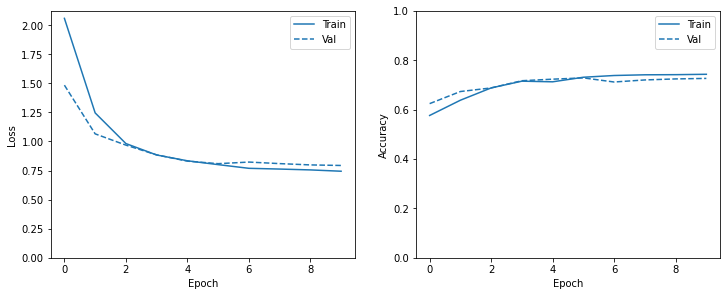

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 5ms/step
Accuracy of prediction on test set :  0.7266666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.73      0.88      0.80       736
           2       0.71      0.59      0.64       380

    accuracy                           0.73      1200
   macro avg       0.48      0.49      0.48      1200
weighted avg       0.67      0.73      0.69      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
 
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_30 (Conv1D)          (None, 57, 64)            38464     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 28, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 28, 32)            6176      
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, 14, 16)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 2.1796 - accuracy: 0.6042 - val_loss: 1.6162 - val_accuracy: 0.6208
Epoch 2/10
60/60 [==============================] - 1s 8ms/step - loss: 1.3367 - accuracy: 0.6393 - val_loss: 1.1250 - val_accuracy: 0.6833
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 1.0357 - accuracy: 0.6792 - val_loss: 0.9601 - val_accuracy: 0.6771
Epoch 4/10
60/60 [==============================] - 1s 10ms/step - loss: 0.9083 - accuracy: 0.7000 - val_loss: 0.8744 - val_accuracy: 0.7115
Epoch 5/10
60/60 [==============================] - 1s 10ms/step - loss: 0.8529 - accuracy: 0.7052 - val_loss: 0.8312 - val_accuracy: 0.7094
Epoch 6/10
60/60 [==============================] - 1s 15ms/step - loss: 0.7977 - accuracy: 0.7305 - val_loss: 0.8206 - val_accuracy: 0.7198
Epoch 7/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7728 - accuracy: 0.7346 - val_loss: 0.7987 - val_accuracy: 0.7156
Epoch 8/10
60/60

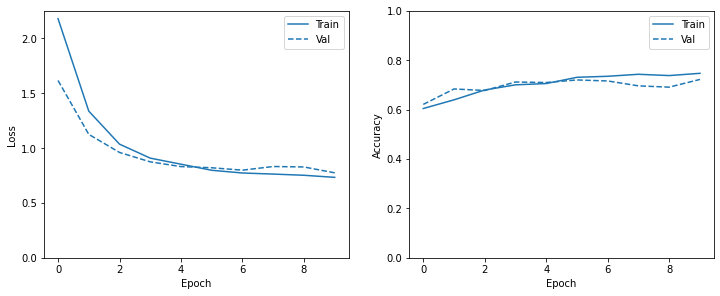

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7208333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.73      0.89      0.80       736
           2       0.70      0.55      0.61       380

    accuracy                           0.72      1200
   macro avg       0.48      0.48      0.47      1200
weighted avg       0.67      0.72      0.69      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN5

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_34 (Conv1D)          (None, 57, 50)            30050     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 28, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_35 (Conv1D)          (None, 28, 100)           15100     
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 14, 100)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 100)         

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 1.8931 - accuracy: 0.6031 - val_loss: 1.4077 - val_accuracy: 0.6156
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1712 - accuracy: 0.6313 - val_loss: 1.0057 - val_accuracy: 0.6917
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9021 - accuracy: 0.6867 - val_loss: 0.8424 - val_accuracy: 0.6990
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7976 - accuracy: 0.7109 - val_loss: 0.7738 - val_accuracy: 0.7125
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7407 - accuracy: 0.7307 - val_loss: 0.7482 - val_accuracy: 0.7094
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7114 - accuracy: 0.7404 - val_loss: 0.7561 - val_accuracy: 0.7031
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.7445 - val_loss: 0.7539 - val_accuracy: 0.7146
Epoch 8/10
60/60 [=

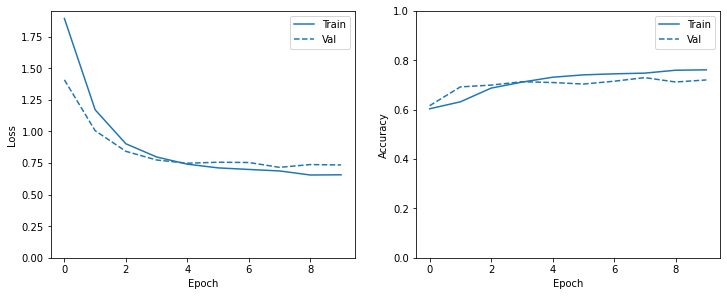

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7325
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        84
           1       0.74      0.90      0.81       736
           2       0.72      0.57      0.63       380

    accuracy                           0.73      1200
   macro avg       0.65      0.49      0.49      1200
weighted avg       0.71      0.73      0.70      1200



# CNN5_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_36 (Conv1D)          (None, 57, 50)            30050     
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 28, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 28, 100)           15100     
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 14, 100)          0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 14, 100)         

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 12ms/step - loss: 1.9605 - accuracy: 0.6177 - val_loss: 1.5070 - val_accuracy: 0.6687
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.2744 - accuracy: 0.6799 - val_loss: 1.0811 - val_accuracy: 0.7125
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9726 - accuracy: 0.7034 - val_loss: 0.8944 - val_accuracy: 0.7104
Epoch 4/10
60/60 [==============================] - 1s 19ms/step - loss: 0.8267 - accuracy: 0.7172 - val_loss: 0.8869 - val_accuracy: 0.6771
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7693 - accuracy: 0.7245 - val_loss: 0.7667 - val_accuracy: 0.7177
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7185 - accuracy: 0.7401 - val_loss: 0.7877 - val_accuracy: 0.6948
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7106 - accuracy: 0.7380 - val_loss: 0.7459 - val_accuracy: 0.7208
Epoch 8/10
60/60 [

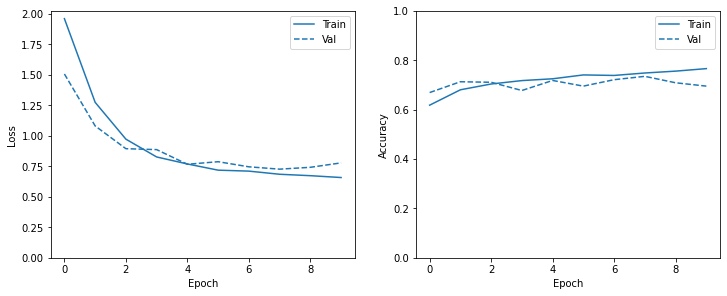

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.6991666666666667
              precision    recall  f1-score   support

           0       0.73      0.10      0.17        84
           1       0.81      0.73      0.77       736
           2       0.56      0.78      0.65       380

    accuracy                           0.70      1200
   macro avg       0.70      0.53      0.53      1200
weighted avg       0.73      0.70      0.69      1200



# CNN6

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=50, kernel_size=2, padding='valid', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=50, kernel_size=2, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_38 (Conv1D)          (None, 56, 50)            30050     
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 28, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_39 (Conv1D)          (None, 27, 50)            5050      
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 13, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_40 (Conv1D)          (None, 11, 50)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 5s 15ms/step - loss: 2.5842 - accuracy: 0.6010 - val_loss: 1.9246 - val_accuracy: 0.6177
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.5485 - accuracy: 0.6320 - val_loss: 1.2645 - val_accuracy: 0.6281
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 1.1011 - accuracy: 0.6677 - val_loss: 0.9977 - val_accuracy: 0.6979
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9120 - accuracy: 0.7016 - val_loss: 0.8645 - val_accuracy: 0.7115
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8318 - accuracy: 0.7161 - val_loss: 0.8099 - val_accuracy: 0.7250
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7674 - accuracy: 0.7307 - val_loss: 0.8021 - val_accuracy: 0.7000
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7438 - accuracy: 0.7372 - val_loss: 0.8110 - val_accuracy: 0.7031
Epoch 8/10
60/60 [=

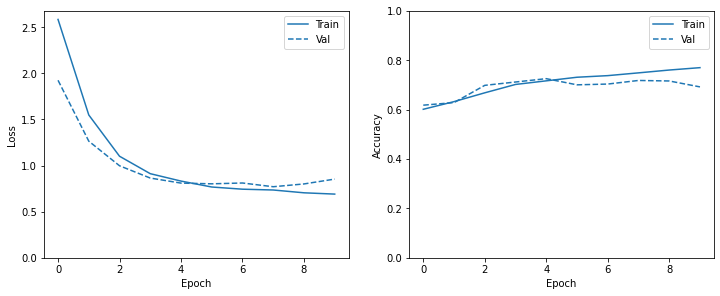

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 7ms/step
Accuracy of prediction on test set :  0.7041666666666667
              precision    recall  f1-score   support

           0       0.40      0.02      0.04        84
           1       0.69      0.97      0.80       736
           2       0.83      0.34      0.49       380

    accuracy                           0.70      1200
   macro avg       0.64      0.45      0.45      1200
weighted avg       0.71      0.70      0.65      1200



# CNN7

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=50, kernel_size=2, padding='valid', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=4, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_42 (Conv1D)          (None, 56, 50)            30050     
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 28, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 26, 50)            7550      
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 13, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_44 (Conv1D)          (None, 11, 100)         

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 15ms/step - loss: 2.7952 - accuracy: 0.6180 - val_loss: 1.8810 - val_accuracy: 0.6167
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.4457 - accuracy: 0.6667 - val_loss: 1.1437 - val_accuracy: 0.6833
Epoch 3/10
60/60 [==============================] - 1s 8ms/step - loss: 0.9987 - accuracy: 0.6956 - val_loss: 0.9120 - val_accuracy: 0.7188
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8524 - accuracy: 0.7208 - val_loss: 0.8859 - val_accuracy: 0.6958
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7995 - accuracy: 0.7286 - val_loss: 0.8083 - val_accuracy: 0.7125
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7589 - accuracy: 0.7359 - val_loss: 0.8298 - val_accuracy: 0.6948
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7459 - accuracy: 0.7419 - val_loss: 0.8017 - val_accuracy: 0.7135
Epoch 8/10
60/60 [=

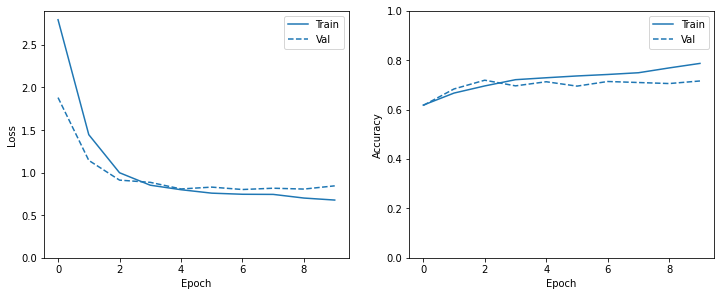

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.7216666666666667
              precision    recall  f1-score   support

           0       0.44      0.05      0.09        84
           1       0.71      0.94      0.81       736
           2       0.80      0.44      0.57       380

    accuracy                           0.72      1200
   macro avg       0.65      0.48      0.49      1200
weighted avg       0.72      0.72      0.68      1200



# CNN7_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=200, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=300, kernel_size=4, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_49 (Conv1D)          (None, 56, 100)           60100     
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 28, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_50 (Conv1D)          (None, 26, 200)           60200     
                                                                 
 max_pooling1d_49 (MaxPoolin  (None, 13, 200)          0         
 g1D)                                                            
                                                                 
 conv1d_51 (Conv1D)          (None, 10, 300)         

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 13ms/step - loss: 3.4054 - accuracy: 0.6273 - val_loss: 1.6456 - val_accuracy: 0.7052
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.1857 - accuracy: 0.6854 - val_loss: 0.9668 - val_accuracy: 0.7063
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8652 - accuracy: 0.7112 - val_loss: 0.8311 - val_accuracy: 0.7146
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7797 - accuracy: 0.7273 - val_loss: 0.7914 - val_accuracy: 0.7135
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7484 - accuracy: 0.7357 - val_loss: 0.7952 - val_accuracy: 0.7146
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7239 - accuracy: 0.7443 - val_loss: 0.7938 - val_accuracy: 0.7094
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.7599 - val_loss: 0.8065 - val_accuracy: 0.7125
Epoch 8/10
60/60 [=

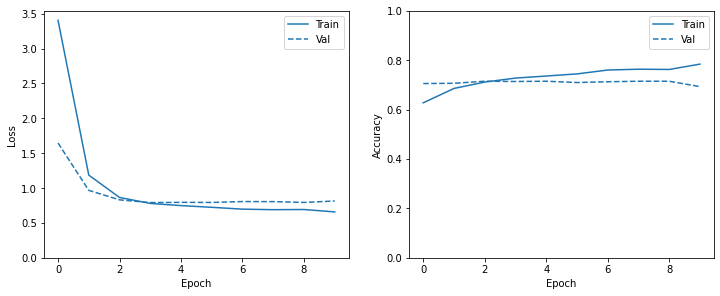

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.72
              precision    recall  f1-score   support

           0       0.40      0.21      0.28        84
           1       0.79      0.79      0.79       736
           2       0.62      0.69      0.65       380

    accuracy                           0.72      1200
   macro avg       0.61      0.57      0.58      1200
weighted avg       0.71      0.72      0.71      1200



# CNN8

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=1024, kernel_size=2, padding='valid', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=1024, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=1024, kernel_size=4, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 57, 300)           4054200   
                                                                 
 conv1d_52 (Conv1D)          (None, 56, 1024)          615424    
                                                                 
 max_pooling1d_51 (MaxPoolin  (None, 28, 1024)         0         
 g1D)                                                            
                                                                 
 conv1d_53 (Conv1D)          (None, 26, 1024)          3146752   
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 13, 1024)         0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 10, 1024)        

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 31ms/step - loss: 12.7724 - accuracy: 0.5945 - val_loss: 4.3453 - val_accuracy: 0.6854
Epoch 2/10
60/60 [==============================] - 2s 27ms/step - loss: 2.3939 - accuracy: 0.6734 - val_loss: 1.3585 - val_accuracy: 0.6865
Epoch 3/10
60/60 [==============================] - 2s 28ms/step - loss: 1.0932 - accuracy: 0.7073 - val_loss: 1.0078 - val_accuracy: 0.6615
Epoch 4/10
60/60 [==============================] - 2s 28ms/step - loss: 0.8784 - accuracy: 0.7031 - val_loss: 0.8486 - val_accuracy: 0.6833
Epoch 5/10
60/60 [==============================] - 2s 28ms/step - loss: 0.8224 - accuracy: 0.7086 - val_loss: 0.8480 - val_accuracy: 0.6802
Epoch 6/10
60/60 [==============================] - 2s 28ms/step - loss: 0.7781 - accuracy: 0.7146 - val_loss: 0.8189 - val_accuracy: 0.7063
Epoch 7/10
60/60 [==============================] - 2s 28ms/step - loss: 0.7733 - accuracy: 0.7229 - val_loss: 0.8193 - val_accuracy: 0.6823
Epoch 8/10
6

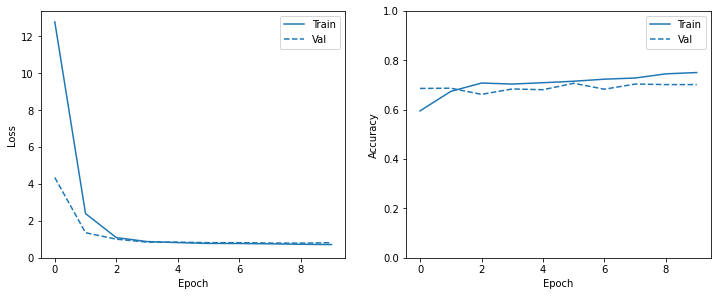

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 10ms/step
Accuracy of prediction on test set :  0.7133333333333334
              precision    recall  f1-score   support

           0       0.50      0.02      0.05        84
           1       0.69      0.96      0.81       736
           2       0.82      0.39      0.53       380

    accuracy                           0.71      1200
   macro avg       0.67      0.46      0.46      1200
weighted avg       0.72      0.71      0.66      1200



# Preprocess 
### delete links and mentions and pancutation and stop words

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = token.replace("#", "").replace("_", " ")

        

        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation  and token not in STOP_WORDS:
            cleaned_tokens.append(token)
            
    return cleaned_tokens

# Load Dataset1

In [ ]:
tweets_df1 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding='unicode_escape')
tweets_df1.shape

(6000, 3)

In [ ]:
tweets_df1.head()

label                                         tweet_text
0      0  4,000 a day dying from the so called Covid-19 ...
1      1  Pranam message for today manifested in Dhyan b...
2      1  Hyderabad-based ?@BharatBiotech? has sought fu...
3      0  Confirmation that Chinese #vaccines "dont hav...
4      2  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.drop(columns=["tweet_id" ],inplace=True)

KeyError: ignored

In [ ]:
tweets_df1 = tweets_df1.dropna()

In [ ]:
tweets_df1.head()

In [ ]:
tweets_df1.loc[tweets_df1['label'] == 1, 'label'] = 0
tweets_df1.loc[tweets_df1['label'] == 2, 'label'] = 1
tweets_df1.loc[tweets_df1['label'] == 3, 'label'] = 2

# Preprocess Dataset1
### delete links and mentions and pancutation and stop words

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data1 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df1['tweet_text'].tolist()
Y = tweets_df1['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data1.append((tk.tokenize(x), y))

In [ ]:
cleaned_tokens_list1 = []

# Removing noise from all the data
for tokens, label in data1:
    cleaned_tokens_list1.append((remove_noise5(tokens), label))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'wb') as fp:
        pickle.dump(cleaned_tokens_list1, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'rb') as fp:
        cleaned_tokens_list1 = pickle.load(fp)

sentences_array1 = [s[0] for s in cleaned_tokens_list1]
print(sentences_array1[0])

['day', 'dying', 'called', 'Covid', 'vaccine', 'reports', '#vaccine', '#PfizerVaccine', '#Moderna']


# Load Dataset2

In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2.head()

user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(395683, 1)

In [ ]:
tweets_df2.head()

text
0  Australia to Manufacture Covid-19 Vaccine and ...
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...
2  Deaths due to COVID-19 in Affected Countries\n...
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...
4  @michellegrattan @ConversationEDU This is what...

# Preprocess Dataset2
### delete links and mentions and pancutation and stop words

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise5(tokens))

import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['Australia', 'Manufacture', 'Covid', 'Vaccine', 'give', 'Citizens', 'free', 'cost', 'AFP', 'quotes', 'Prime', 'Minister', '#CovidVaccine']


# Load Dataset3

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

# Preprocess Dataset3
### delete links and mentions and pancutation and stop words

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise5(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'rb') as fp:
        cleaned_tokens_list3 = pickle.load(fp)

sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['Same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', '#PfizerBioNTech']


# Load Datset4

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

# Preprocess Dataset4
### delete links and mentions and pancutation and stop words

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise5(tokens))

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'rb') as fp:
        cleaned_tokens_list4 = pickle.load(fp)

sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['Covid', 'denial', 'inaction', 'many', 'political', 'World', 'leaders', 'created', 'tsunami', 'anti-vaccine', 'mask', 'The', 'refusal', 'many', 'go', 'lockdown', 'keep', 'football', 'live', 'made', 'near', 'impossible', 'stop', 'variant', 'Now', 'around', 'Fu', 'k', 'FOX', 'propaganda']


# Combine Datasets

In [ ]:
train_data = sentences_array1 + sentences_array2 + sentences_array3 + sentences_array4
len(train_data)

1387864

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_2', 'wb') as fp:
        pickle.dump(train_data, fp)

# Learn Word2vec Skip Gram
### preprocess delete links and mentions and pancutation 

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_2', 'rb') as fp:
        train_data = pickle.load(fp)

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=300  , workers=4 ,sg = 1)
w2v_model.build_vocab(train_data)

CPU times: user 1min 15s, sys: 1.78 s, total: 1min 16s
Wall time: 1min 16s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  379826


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 30)

CPU times: user 2h 44min 57s, sys: 17.9 s, total: 2h 45min 15s
Wall time: 1h 25min 13s


(636763633, 685559070)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d_4.model")

# Prepare train and test dataset
### Preprocess include delete link,mentions and panctuations and stop words

In [ ]:
tweets_df = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df.shape

(6000, 3)

In [ ]:
tweets_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df.drop(columns=["tweet_id"],inplace=True)

In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.loc[tweets_df['label'] == 1, 'label'] = 0
tweets_df.loc[tweets_df['label'] == 2, 'label'] = 1
tweets_df.loc[tweets_df['label'] == 3, 'label'] = 2

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df['tweet_text'].tolist()
Y = tweets_df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 0.9463043212890625


[(['4,000',
   'a',
   'day',
   'dying',
   'from',
   'the',
   'so',
   'called',
   'Covid',
   '-',
   '19',
   '\x93',
   'vaccine',
   '\x94',
   '@DailyBeast',
   'reports',
   '.',
   '#vaccine',
   '#PfizerVaccine',
   '#Moderna',
   'https://t.co/p1nQWWZpk4'],
  0),
 (['Pranam',
   'message',
   'for',
   'today',
   'manifested',
   'in',
   'Dhyan',
   'by',
   '@meenapranam',
   '#truth',
   '#love',
   '#karm',
   '#light',
   '#nature',
   '#consciousness',
   '#FridayThoughts',
   '#fridaymorning',
   '#CoronavirusIndia',
   '#COVID19India',
   '#',
   '?',
   '?',
   '?',
   '_',
   '?',
   '?',
   '?',
   '#navratri',
   '#Thane',
   '#AmbedkarJayanti2021',
   '#ModiJi',
   '#NarendraModi',
   '#SecondCOVIDWave',
   '#Covaxin',
   'https://t.co/bQNoMVowJg'],
  1),
 (['Hyderabad-based',
   '?',
   '@BharatBiotech',
   '?',
   'has',
   'sought',
   'funds',
   'from',
   'the',
   'government',
   'to',
   'ramp',
   'up',
   'production',
   'of',
   'its',
   'indig

In [ ]:
cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise5(tokens), label))

In [ ]:
sentences_array = [s[0] for s in cleaned_tokens_list]
sentences = []

for s in sentences_array :
  sentence = ' '.join(map(str ,s))
  sentences.append(sentence)

print(sentences[0])
print(sentences_array[0])

day dying called Covid vaccine reports vaccine PfizerVaccine Moderna
['day', 'dying', 'called', 'Covid', 'vaccine', 'reports', 'vaccine', 'PfizerVaccine', 'Moderna']


In [ ]:
# find number of unique words i train list
all_train_word = []

for i in range(len(sentences_array)) :
  all_train_word += sentences_array[i]

print('all words in dataset1 number (after preprocess): {}'.format(len(all_train_word)))

uniqueWords = [] 
for i in all_train_word:
  if not i in uniqueWords:
      uniqueWords.append(i)


print('unique words in dataset1 number (after preprocess): {}'.format(len(uniqueWords)))

all words in dataset1 number (after preprocess): 101319
unique words in dataset1 number (after preprocess): 16898


In [ ]:
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

max_len: 44


In [ ]:
Y = np.zeros((len(cleaned_tokens_list), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    Y[i] = label

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [ ]:
X_sequences = tokenizer.texts_to_sequences(sentences)
X_sequences[2]

[1000,
 273,
 4081,
 2276,
 118,
 1191,
 105,
 1392,
 183,
 2,
 1,
 4,
 13,
 200,
 3206,
 1496,
 283,
 541,
 1191]

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X_sequences,maxlen=max_len ,padding='post')
X_padded = np.array(X_padded)
X_padded[2]

array([1000,  273, 4081, 2276,  118, 1191,  105, 1392,  183,    2,    1,
          4,   13,  200, 3206, 1496,  283,  541, 1191,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train.shape)
print(Y_train.shape)

(4800, 44)
(4800,)


In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec4_1', 'wb') as fp:
#         pickle.dump(X_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec4_1', 'wb') as fp:
#         pickle.dump(X_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec4_1', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec4_1', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec4_1', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/XtestVec4_1', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec4_1', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec4_1', 'rb') as fp:
        Y_test =  pickle.load(fp)


# Make Embedding Matrix

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_4.model")

In [ ]:
EMBEDDING_DIM=300
vocabulary_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

i = 0
for word,i in tokenizer.word_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
         pass
        
       
    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix4', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

(13478, 300)
[ 0.1337406   0.22102369 -0.45768857 -0.34014252  0.25853589 -0.02587909
 -0.27878767 -0.29833776 -0.46242896  0.21121693 -0.11572357  0.29675379
 -0.4508214   0.33574232  0.61506498  0.43219113  0.09443956  0.01522741
  0.1287784   0.07457139  0.30688789 -0.16805854 -0.28628772  0.16235141
  0.15942153 -0.15507212  0.46305633  0.06751543 -0.57159811 -0.08414879
  0.25917169  0.12115516 -0.29655313 -0.11595637 -0.09390004 -0.11957688
  0.24969731  0.08174628 -0.65589541  0.30017564 -0.37535995  0.0300011
  0.69912755  0.10168128 -0.08299642 -0.10411934  0.10512152 -0.28105158
  0.00331298  0.29503065  0.45260388  0.6292159   0.52752739 -0.11658597
 -0.17512272 -0.25565755 -0.15792249  0.02591395  0.49844706 -0.16663656
 -0.12710045  0.52521795 -0.00377688 -0.23132198  0.2022754   0.13814251
  0.13452454 -0.2576817  -0.03853884  0.14781061 -0.11447468  0.01766559
 -0.07699531  0.43150482  0.11835374  0.29132715 -0.13277337  0.19537432
  0.1452315   0.01314558  0.04476463 -0

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix4', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

# CNN1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 15s 228ms/step - loss: 3.3649 - accuracy: 0.6086 - val_loss: 1.6072 - val_accuracy: 0.6375
Epoch 2/10
60/60 [==============================] - 12s 195ms/step - loss: 1.1676 - accuracy: 0.6404 - val_loss: 0.9134 - val_accuracy: 0.6802
Epoch 3/10
60/60 [==============================] - 10s 170ms/step - loss: 0.8461 - accuracy: 0.6951 - val_loss: 0.8119 - val_accuracy: 0.7135
Epoch 4/10
60/60 [==============================] - 10s 172ms/step - loss: 0.7842 - accuracy: 0.7128 - val_loss: 0.7752 - val_accuracy: 0.7271
Epoch 5/10
60/60 [==============================] - 11s 193ms/step - loss: 0.7553 - accuracy: 0.7201 - val_loss: 0.7774 - val_accuracy: 0.7219
Epoch 6/10
60/60 [==============================] - 10s 171ms/step - loss: 0.7270 - accuracy: 0.7354 - val_loss: 0.7675 - val_accuracy: 0.7198
Epoch 7/10
60/60 [==============================] - 10s 170ms/step - loss: 0.7219 - accuracy: 0.7339 - val_loss: 0.7692 - val_accuracy: 0.7115

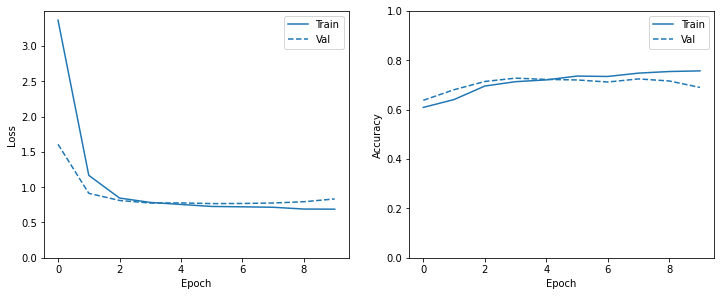

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 13ms/step
Accuracy of prediction on test set :  0.68
              precision    recall  f1-score   support

           0       0.47      0.08      0.14        84
           1       0.78      0.72      0.75       736
           2       0.55      0.74      0.63       380

    accuracy                           0.68      1200
   macro avg       0.60      0.51      0.51      1200
weighted avg       0.69      0.68      0.67      1200



# CNN1_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_58 (Conv1D)          (None, 44, 100)           60100     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 22, 100)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 22, 100)           0         
                                                                 
 conv1d_59 (Conv1D)          (None, 22, 200)           60200     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 11, 200)          0         
 1D)                                                  

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics='accuracy')

Epoch 1/10
60/60 [==============================] - 17s 258ms/step - loss: 3.7162 - accuracy: 0.6424 - val_loss: 1.9923 - val_accuracy: 0.7031
Epoch 2/10
60/60 [==============================] - 13s 213ms/step - loss: 1.4181 - accuracy: 0.7026 - val_loss: 1.0562 - val_accuracy: 0.7125
Epoch 3/10
60/60 [==============================] - 13s 216ms/step - loss: 0.9286 - accuracy: 0.7255 - val_loss: 0.8657 - val_accuracy: 0.7146
Epoch 4/10
60/60 [==============================] - 13s 209ms/step - loss: 0.8080 - accuracy: 0.7323 - val_loss: 0.8935 - val_accuracy: 0.7031
Epoch 5/10
60/60 [==============================] - 13s 211ms/step - loss: 0.7847 - accuracy: 0.7365 - val_loss: 0.8144 - val_accuracy: 0.7094
Epoch 6/10
60/60 [==============================] - 13s 212ms/step - loss: 0.7444 - accuracy: 0.7424 - val_loss: 0.8077 - val_accuracy: 0.7177
Epoch 7/10
60/60 [==============================] - 12s 194ms/step - loss: 0.7312 - accuracy: 0.7417 - val_loss: 0.7964 - val_accuracy: 0.7188

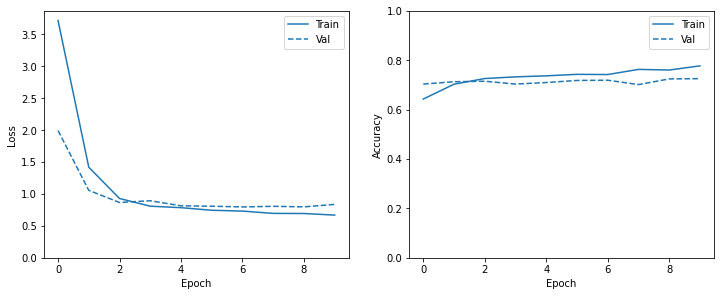

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 25ms/step
Accuracy of prediction on test set :  0.7275
              precision    recall  f1-score   support

           0       0.42      0.17      0.24        84
           1       0.74      0.89      0.81       736
           2       0.72      0.53      0.62       380

    accuracy                           0.73      1200
   macro avg       0.63      0.53      0.55      1200
weighted avg       0.71      0.73      0.71      1200



# CNN2

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(128, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_64 (Conv1D)          (None, 44, 64)            38464     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 22, 64)           0         
 1D)                                                             
                                                                 
 conv1d_65 (Conv1D)          (None, 22, 64)            12352     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 11, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_66 (Conv1D)          (None, 11, 64)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 5s 56ms/step - loss: 2.0860 - accuracy: 0.5880 - val_loss: 1.2724 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 3s 56ms/step - loss: 1.0565 - accuracy: 0.6146 - val_loss: 0.9467 - val_accuracy: 0.6083
Epoch 3/10
60/60 [==============================] - 4s 63ms/step - loss: 0.9142 - accuracy: 0.6146 - val_loss: 0.8977 - val_accuracy: 0.6083
Epoch 4/10
60/60 [==============================] - 4s 59ms/step - loss: 0.8860 - accuracy: 0.6146 - val_loss: 0.8813 - val_accuracy: 0.6083
Epoch 5/10
60/60 [==============================] - 3s 55ms/step - loss: 0.8735 - accuracy: 0.6146 - val_loss: 0.8717 - val_accuracy: 0.6083
Epoch 6/10
60/60 [==============================] - 3s 55ms/step - loss: 0.8660 - accuracy: 0.6146 - val_loss: 0.8654 - val_accuracy: 0.6083
Epoch 7/10
60/60 [==============================] - 4s 59ms/step - loss: 0.8609 - accuracy: 0.6146 - val_loss: 0.8614 - val_accuracy: 0.6083
Epoch 8/10
60

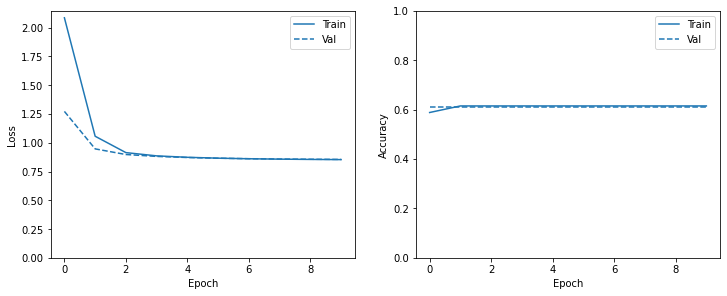

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 16ms/step
Accuracy of prediction on test set :  0.6133333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.61      1.00      0.76       736
           2       0.00      0.00      0.00       380

    accuracy                           0.61      1200
   macro avg       0.20      0.33      0.25      1200
weighted avg       0.38      0.61      0.47      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN3

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=300, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=400, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Conv1D(filters=500, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_67 (Conv1D)          (None, 44, 100)           60100     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 22, 100)          0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 22, 100)           0         
                                                                 
 conv1d_68 (Conv1D)          (None, 22, 200)           60200     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 11, 200)          0         
 g1D)                                                 

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 90s 552ms/step - loss: 6.4496 - accuracy: 0.6016 - val_loss: 2.2260 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 21s 348ms/step - loss: 1.4346 - accuracy: 0.6146 - val_loss: 1.0117 - val_accuracy: 0.6083
Epoch 3/10
60/60 [==============================] - 19s 318ms/step - loss: 0.9305 - accuracy: 0.6211 - val_loss: 0.8619 - val_accuracy: 0.6438
Epoch 4/10
60/60 [==============================] - 19s 318ms/step - loss: 0.8855 - accuracy: 0.6310 - val_loss: 0.8406 - val_accuracy: 0.6083
Epoch 5/10
60/60 [==============================] - 19s 316ms/step - loss: 0.8386 - accuracy: 0.6674 - val_loss: 0.8595 - val_accuracy: 0.6677
Epoch 6/10
60/60 [==============================] - 19s 316ms/step - loss: 0.8343 - accuracy: 0.6836 - val_loss: 0.9419 - val_accuracy: 0.5469
Epoch 7/10
60/60 [==============================] - 27s 452ms/step - loss: 0.8354 - accuracy: 0.6820 - val_loss: 0.8258 - val_accuracy: 0.7083

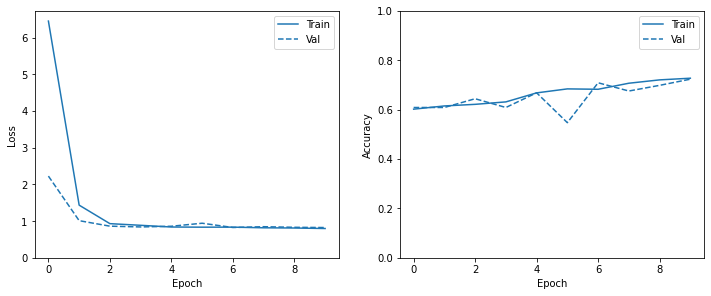

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 20ms/step
Accuracy of prediction on test set :  0.7125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.72      0.89      0.80       736
           2       0.69      0.52      0.59       380

    accuracy                           0.71      1200
   macro avg       0.47      0.47      0.46      1200
weighted avg       0.66      0.71      0.68      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='relu',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
 
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_76 (Conv1D)          (None, 44, 64)            38464     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 22, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_77 (Conv1D)          (None, 22, 32)            6176      
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 11, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_78 (Conv1D)          (None, 11, 16)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 6s 66ms/step - loss: 1.1543 - accuracy: 0.6148 - val_loss: 0.9844 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 4s 58ms/step - loss: 0.9251 - accuracy: 0.6508 - val_loss: 0.8755 - val_accuracy: 0.6854
Epoch 3/10
60/60 [==============================] - 3s 58ms/step - loss: 0.8807 - accuracy: 0.6721 - val_loss: 0.8457 - val_accuracy: 0.7229
Epoch 4/10
60/60 [==============================] - 3s 58ms/step - loss: 0.8225 - accuracy: 0.7031 - val_loss: 0.8185 - val_accuracy: 0.7156
Epoch 5/10
60/60 [==============================] - 4s 59ms/step - loss: 0.7876 - accuracy: 0.7237 - val_loss: 0.8274 - val_accuracy: 0.7229
Epoch 6/10
60/60 [==============================] - 3s 57ms/step - loss: 0.7683 - accuracy: 0.7328 - val_loss: 0.8008 - val_accuracy: 0.7281
Epoch 7/10
60/60 [==============================] - 4s 61ms/step - loss: 0.7510 - accuracy: 0.7422 - val_loss: 0.8022 - val_accuracy: 0.7135
Epoch 8/10
60

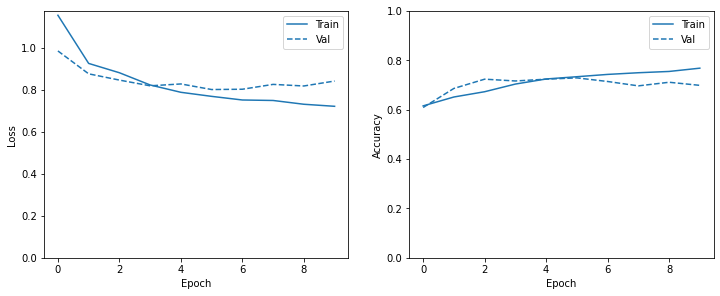

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 12ms/step
Accuracy of prediction on test set :  0.6933333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.79      0.76      0.77       736
           2       0.56      0.71      0.62       380

    accuracy                           0.69      1200
   macro avg       0.45      0.49      0.47      1200
weighted avg       0.66      0.69      0.67      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='tanh',kernel_regularizer=l2(0.01) ))
model.add(MaxPooling1D())
 
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_80 (Conv1D)          (None, 44, 64)            38464     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 22, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_81 (Conv1D)          (None, 22, 32)            6176      
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 11, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_82 (Conv1D)          (None, 11, 16)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 7s 70ms/step - loss: 2.0966 - accuracy: 0.5992 - val_loss: 1.5494 - val_accuracy: 0.6083
Epoch 2/10
60/60 [==============================] - 3s 58ms/step - loss: 1.2680 - accuracy: 0.6383 - val_loss: 1.0624 - val_accuracy: 0.6896
Epoch 3/10
60/60 [==============================] - 3s 55ms/step - loss: 0.9757 - accuracy: 0.6849 - val_loss: 0.9060 - val_accuracy: 0.7125
Epoch 4/10
60/60 [==============================] - 4s 68ms/step - loss: 0.8573 - accuracy: 0.7112 - val_loss: 0.8614 - val_accuracy: 0.7083
Epoch 5/10
60/60 [==============================] - 3s 50ms/step - loss: 0.8124 - accuracy: 0.7219 - val_loss: 0.8213 - val_accuracy: 0.7115
Epoch 6/10
60/60 [==============================] - 3s 53ms/step - loss: 0.7862 - accuracy: 0.7286 - val_loss: 0.8083 - val_accuracy: 0.7260
Epoch 7/10
60/60 [==============================] - 3s 51ms/step - loss: 0.7416 - accuracy: 0.7456 - val_loss: 0.8153 - val_accuracy: 0.7125
Epoch 8/10
60

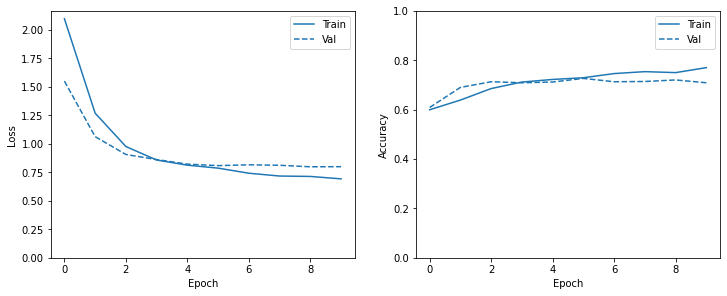

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 12ms/step
Accuracy of prediction on test set :  0.7066666666666667
              precision    recall  f1-score   support

           0       0.46      0.25      0.32        84
           1       0.77      0.79      0.78       736
           2       0.62      0.64      0.63       380

    accuracy                           0.71      1200
   macro avg       0.61      0.56      0.58      1200
weighted avg       0.70      0.71      0.70      1200



# CNN5

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
 
model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_84 (Conv1D)          (None, 44, 50)            30050     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 22, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_85 (Conv1D)          (None, 22, 100)           15100     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 11, 100)          0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 11, 100)         

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 9s 99ms/step - loss: 1.8882 - accuracy: 0.6122 - val_loss: 1.3920 - val_accuracy: 0.6229
Epoch 2/10
60/60 [==============================] - 5s 82ms/step - loss: 1.1538 - accuracy: 0.6633 - val_loss: 0.9686 - val_accuracy: 0.6990
Epoch 3/10
60/60 [==============================] - 4s 74ms/step - loss: 0.8820 - accuracy: 0.7055 - val_loss: 0.8187 - val_accuracy: 0.7292
Epoch 4/10
60/60 [==============================] - 4s 74ms/step - loss: 0.7934 - accuracy: 0.7156 - val_loss: 0.7762 - val_accuracy: 0.7188
Epoch 5/10
60/60 [==============================] - 5s 80ms/step - loss: 0.7365 - accuracy: 0.7289 - val_loss: 0.7443 - val_accuracy: 0.7229
Epoch 6/10
60/60 [==============================] - 4s 67ms/step - loss: 0.7017 - accuracy: 0.7367 - val_loss: 0.7398 - val_accuracy: 0.7229
Epoch 7/10
60/60 [==============================] - 4s 69ms/step - loss: 0.6813 - accuracy: 0.7466 - val_loss: 0.7480 - val_accuracy: 0.7010
Epoch 8/10
60

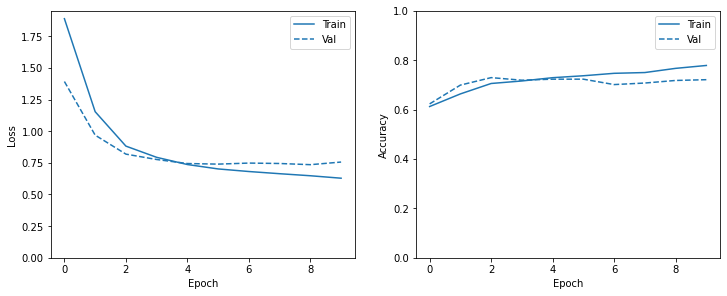

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 8ms/step
Accuracy of prediction on test set :  0.7183333333333334
              precision    recall  f1-score   support

           0       0.43      0.07      0.12        84
           1       0.71      0.92      0.80       736
           2       0.76      0.46      0.58       380

    accuracy                           0.72      1200
   macro avg       0.63      0.49      0.50      1200
weighted avg       0.71      0.72      0.68      1200



# CNN5_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=50, kernel_size=2, padding='same', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_86 (Conv1D)          (None, 44, 50)            30050     
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 22, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_87 (Conv1D)          (None, 22, 100)           15100     
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 11, 100)          0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 11, 100)         

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 6s 70ms/step - loss: 1.9479 - accuracy: 0.6242 - val_loss: 1.4857 - val_accuracy: 0.7156
Epoch 2/10
60/60 [==============================] - 4s 62ms/step - loss: 1.2511 - accuracy: 0.6961 - val_loss: 1.0553 - val_accuracy: 0.7281
Epoch 3/10
60/60 [==============================] - 3s 58ms/step - loss: 0.9443 - accuracy: 0.7174 - val_loss: 0.8887 - val_accuracy: 0.7104
Epoch 4/10
60/60 [==============================] - 4s 73ms/step - loss: 0.8166 - accuracy: 0.7292 - val_loss: 0.7997 - val_accuracy: 0.7240
Epoch 5/10
60/60 [==============================] - 4s 75ms/step - loss: 0.7454 - accuracy: 0.7414 - val_loss: 0.7697 - val_accuracy: 0.7188
Epoch 6/10
60/60 [==============================] - 4s 70ms/step - loss: 0.6995 - accuracy: 0.7513 - val_loss: 0.8030 - val_accuracy: 0.7135
Epoch 7/10
60/60 [==============================] - 4s 60ms/step - loss: 0.6878 - accuracy: 0.7617 - val_loss: 0.7483 - val_accuracy: 0.7281
Epoch 8/10
60

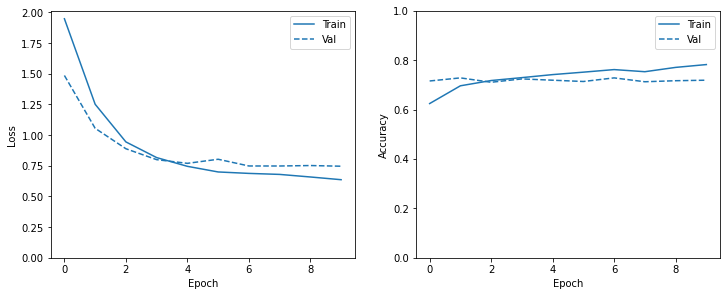

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 10ms/step
Accuracy of prediction on test set :  0.7158333333333333
              precision    recall  f1-score   support

           0       0.50      0.04      0.07        84
           1       0.76      0.83      0.80       736
           2       0.63      0.64      0.63       380

    accuracy                           0.72      1200
   macro avg       0.63      0.50      0.50      1200
weighted avg       0.70      0.72      0.69      1200



# CNN6

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=50, kernel_size=2, padding='valid', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=50, kernel_size=2, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_88 (Conv1D)          (None, 43, 50)            30050     
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 21, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_89 (Conv1D)          (None, 20, 50)            5050      
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 10, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_90 (Conv1D)          (None, 8, 50)           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 6s 62ms/step - loss: 2.4655 - accuracy: 0.6076 - val_loss: 1.7513 - val_accuracy: 0.6292
Epoch 2/10
60/60 [==============================] - 3s 56ms/step - loss: 1.3973 - accuracy: 0.6763 - val_loss: 1.1316 - val_accuracy: 0.6917
Epoch 3/10
60/60 [==============================] - 3s 58ms/step - loss: 0.9933 - accuracy: 0.7161 - val_loss: 0.9749 - val_accuracy: 0.6625
Epoch 4/10
60/60 [==============================] - 3s 57ms/step - loss: 0.8457 - accuracy: 0.7323 - val_loss: 0.8709 - val_accuracy: 0.7063
Epoch 5/10
60/60 [==============================] - 3s 51ms/step - loss: 0.7779 - accuracy: 0.7424 - val_loss: 0.8296 - val_accuracy: 0.7135
Epoch 6/10
60/60 [==============================] - 3s 56ms/step - loss: 0.7330 - accuracy: 0.7555 - val_loss: 0.8163 - val_accuracy: 0.7115
Epoch 7/10
60/60 [==============================] - 5s 76ms/step - loss: 0.7235 - accuracy: 0.7490 - val_loss: 0.8378 - val_accuracy: 0.6948
Epoch 8/10
60

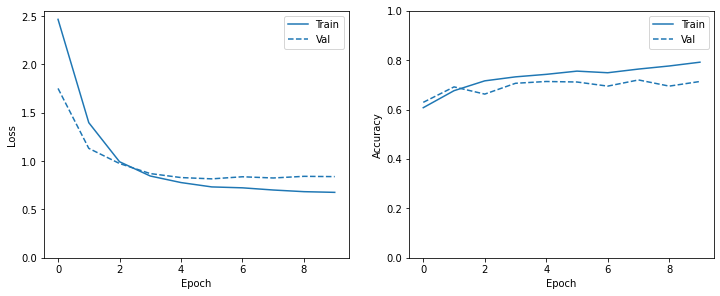

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 11ms/step
Accuracy of prediction on test set :  0.6983333333333334
              precision    recall  f1-score   support

           0       0.33      0.01      0.02        84
           1       0.71      0.90      0.79       736
           2       0.67      0.47      0.55       380

    accuracy                           0.70      1200
   macro avg       0.57      0.46      0.46      1200
weighted avg       0.67      0.70      0.66      1200



# CNN7_1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1 ,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))

model.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=200, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=300, kernel_size=4, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 44, 300)           4043400   
                                                                 
 conv1d_96 (Conv1D)          (None, 43, 100)           60100     
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 21, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_97 (Conv1D)          (None, 19, 200)           60200     
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 9, 200)           0         
 g1D)                                                            
                                                                 
 conv1d_98 (Conv1D)          (None, 6, 300)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 10s 149ms/step - loss: 3.4328 - accuracy: 0.6370 - val_loss: 1.6657 - val_accuracy: 0.7083
Epoch 2/10
60/60 [==============================] - 11s 177ms/step - loss: 1.2116 - accuracy: 0.7018 - val_loss: 0.9798 - val_accuracy: 0.6906
Epoch 3/10
60/60 [==============================] - 10s 167ms/step - loss: 0.8608 - accuracy: 0.7169 - val_loss: 0.8500 - val_accuracy: 0.7135
Epoch 4/10
60/60 [==============================] - 14s 226ms/step - loss: 0.7774 - accuracy: 0.7365 - val_loss: 0.8056 - val_accuracy: 0.7115
Epoch 5/10
60/60 [==============================] - 11s 184ms/step - loss: 0.7553 - accuracy: 0.7307 - val_loss: 0.8301 - val_accuracy: 0.7052
Epoch 6/10
60/60 [==============================] - 10s 174ms/step - loss: 0.7336 - accuracy: 0.7469 - val_loss: 0.8240 - val_accuracy: 0.7031
Epoch 7/10
60/60 [==============================] - 10s 175ms/step - loss: 0.7023 - accuracy: 0.7609 - val_loss: 0.8309 - val_accuracy: 0.7115

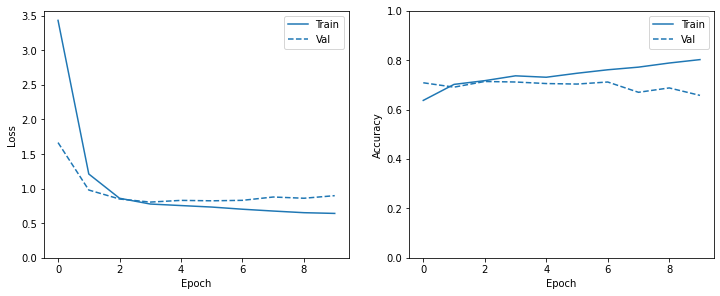

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 12ms/step
Accuracy of prediction on test set :  0.6758333333333333
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        84
           1       0.80      0.69      0.74       736
           2       0.57      0.73      0.64       380

    accuracy                           0.68      1200
   macro avg       0.56      0.57      0.56      1200
weighted avg       0.69      0.68      0.68      1200



# CNN8

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=13478,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=44,
                            trainable=False))

model.add(Conv1D(filters=1024, kernel_size=2, padding='valid', activation='tanh',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=1024, kernel_size=3, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=1024, kernel_size=4, padding='valid', activation='tanh' ,kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 44, 300)           4043400   
                                                                 
 conv1d_9 (Conv1D)           (None, 43, 1024)          615424    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 21, 1024)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 19, 1024)          3146752   
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 9, 1024)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 6, 1024)          

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate


model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 25ms/step - loss: 11.2664 - accuracy: 0.6049 - val_loss: 3.0457 - val_accuracy: 0.6583
Epoch 2/10
60/60 [==============================] - 1s 22ms/step - loss: 1.7309 - accuracy: 0.6844 - val_loss: 1.1162 - val_accuracy: 0.6646
Epoch 3/10
60/60 [==============================] - 1s 22ms/step - loss: 0.9581 - accuracy: 0.6964 - val_loss: 0.8615 - val_accuracy: 0.7260
Epoch 4/10
60/60 [==============================] - 1s 22ms/step - loss: 0.8304 - accuracy: 0.7109 - val_loss: 0.8332 - val_accuracy: 0.7104
Epoch 5/10
60/60 [==============================] - 1s 22ms/step - loss: 0.8278 - accuracy: 0.7063 - val_loss: 0.8115 - val_accuracy: 0.7135
Epoch 6/10
60/60 [==============================] - 1s 21ms/step - loss: 0.7783 - accuracy: 0.7180 - val_loss: 0.8094 - val_accuracy: 0.7146
Epoch 7/10
60/60 [==============================] - 1s 23ms/step - loss: 0.7503 - accuracy: 0.7333 - val_loss: 0.7876 - val_accuracy: 0.7135
Epoch 8/10
6

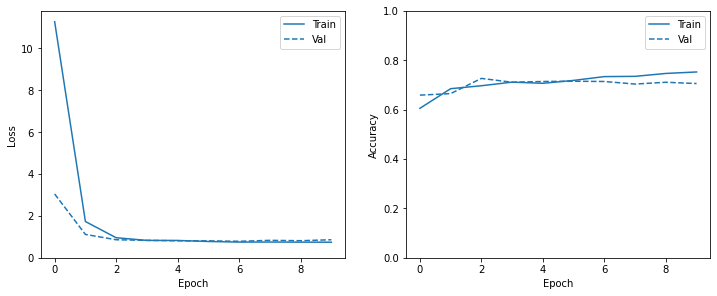

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 7ms/step
Accuracy of prediction on test set :  0.6991666666666667
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        84
           1       0.69      0.94      0.80       736
           2       0.74      0.39      0.51       380

    accuracy                           0.70      1200
   macro avg       0.64      0.45      0.44      1200
weighted avg       0.69      0.70      0.65      1200



🔤# Preprocess
### delete punctuation,links,mentions

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')


# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = token.replace("#", "").replace("_", " ")

          
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [ ]:
"this tweet is example #key1_key2_key3".replace("#", "").replace("_", " ")

'this tweet is example key1 key2 key3'

# 76% Accuracy

In [ ]:
import re, string

from nltk.corpus import stopwords


# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = token.replace("#", "").replace("_", " ")        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

# Load Dataset1

In [ ]:
tweets_df1 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding='unicode_escape')
tweets_df1.shape


(6000, 3)

In [ ]:
tweets_df1.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.drop(columns=["tweet_id" ],inplace=True)

In [ ]:
tweets_df1 = tweets_df1.dropna()

In [ ]:
tweets_df1.head()

label                                         tweet_text
0      1  4,000 a day dying from the so called Covid-19 ...
1      2  Pranam message for today manifested in Dhyan b...
2      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3      1  Confirmation that Chinese #vaccines "dont hav...
4      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.loc[tweets_df1['label'] == 1, 'label'] = 0
tweets_df1.loc[tweets_df1['label'] == 2, 'label'] = 1
tweets_df1.loc[tweets_df1['label'] == 3, 'label'] = 2

# Preprocess Dataset1
### delete punctuation,links,mentions

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data1 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df1['tweet_text'].tolist()
Y = tweets_df1['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data1.append((tk.tokenize(x), y))

In [ ]:
cleaned_tokens_list1 = []

# Removing noise from all the data
for tokens, label in data1:
    cleaned_tokens_list1.append((remove_noise5(tokens), label))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'wb') as fp:
        pickle.dump(cleaned_tokens_list1, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'rb') as fp:
        cleaned_tokens_list1 = pickle.load(fp)

sentences_array1 = [s[0] for s in cleaned_tokens_list1]
print(sentences_array1[0])

['<NUMBER>,<NUMBER>', 'a', 'day', 'dying', 'from', 'the', 'so', 'called', 'Covid', '<NUMBER>', 'vaccine', 'reports', 'vaccine', 'PfizerVaccine', 'Moderna']


# Load Dataset2


In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2.head()

user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(395683, 1)

In [ ]:
tweets_df2.head()

text
0  Australia to Manufacture Covid-19 Vaccine and ...
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...
2  Deaths due to COVID-19 in Affected Countries\n...
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...
4  @michellegrattan @ConversationEDU This is what...

# Preprocess Dataset2
### delete punctuation,links,mentions

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise5(tokens))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['Australia', 'to', 'Manufacture', 'Covid', '<NUMBER>', 'Vaccine', 'and', 'give', 'it', 'to', 'the', 'Citizens', 'for', 'free', 'of', 'cost', 'AFP', 'quotes', 'Prime', 'Minister', 'CovidVaccine']


# Load Dataset3

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

# Preprocess Dataset3
### delete punctuation,links,mentions

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise5(tokens))

In [ ]:


with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'rb') as fp:
        cleaned_tokens_list3 = pickle.load(fp)

sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['Same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'a', 'cytokine', 'storm', 'PfizerBioNTech']


# Load Dataset4

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

# Preprocess Dataset4
### delete punctuation,links,mentions

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise5(tokens))

In [ ]:


with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'rb') as fp:
        cleaned_tokens_list4 = pickle.load(fp)

sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['Covid', '<NUMBER>', 'denial', 'and', 'inaction', 'from', 'many', 'political', 'World', 'leaders', 'in', '<NUMBER>', 'created', 'this', 'tsunami', 'of', 'anti-vaccine', 'and', 'mask', 'The', 'refusal', 'of', 'many', 'to', 'go', 'into', 'lockdown', 'and', 'to', 'keep', 'their', 'football', 'live', 'made', 'it', 'near', 'impossible', 'to', 'stop', 'variant', 'Now', "it's", 'all', 'around', 'me', 'Fu', 'k', 'you', 'FOX', 'propaganda']


# Load Dataset5

In [ ]:
tweets_df5 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/Corona_tweets.csv' ,  encoding='latin-1')
tweets_df5.shape

(41157, 4)

In [ ]:
tweets_df5.head()

User_name        Time   Location  \
0          1  16-03-2020     London   
1          2  16-03-2020         UK   
2          3  16-03-2020  Vagabonds   
3          4  16-03-2020        NaN   
4          5  16-03-2020        NaN   

                                                text  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...  
1  advice Talk to your neighbours family to excha...  
2  Coronavirus Australia: Woolworths to give elde...  
3  My food stock is not the only one which is emp...  
4  Me, ready to go at supermarket during the #COV...

In [ ]:
tweets_df5.drop(columns=["User_name" , "Time" , "Location"],inplace=True)

In [ ]:
tweets_df5 = tweets_df5.dropna()
tweets_df5.shape

(41157, 1)

In [ ]:
tweets_df5.head()

text
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1  advice Talk to your neighbours family to excha...
2  Coronavirus Australia: Woolworths to give elde...
3  My food stock is not the only one which is emp...
4  Me, ready to go at supermarket during the #COV...

# Preprocess Dataset5
### delete punctuation,links,mentions

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data5 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df5['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data5.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list5 = []

# Removing noise from all the data
for tokens in data5:
    cleaned_tokens_list5.append(remove_noise5(tokens))

In [ ]:


with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'wb') as fp:
        pickle.dump(cleaned_tokens_list5, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'rb') as fp:
        cleaned_tokens_list5 = pickle.load(fp)

sentences_array5 = [s for s in cleaned_tokens_list5]
print(sentences_array5[0])

['and', 'and']


# Load Dataset6

In [ ]:
tweets_df6 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid19_tweets.csv')
tweets_df6.shape

(179108, 13)

In [ ]:
tweets_df6.head()

user_name         user_location  \
0           ᏉᎥ☻լꂅϮ            astroworld   
1    Tom Basile 🇺🇸          New York, NY   
2  Time4fisticuffs      Pewee Valley, KY   
3      ethel mertz  Stuck in the Middle    
4         DIPR-J&K     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified  \
0             624           950            18775          False   
1            2253          1677               24           True   
2            9275          9525             7254          False   
3             197           987             1488          False   
4          101009           168              101          False   

                  date                                               text  \
0  2020-07-25 12:27:21  If I smelled the scent of hand sanitizers toda...   
1  2020-07-25 12:27:17  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  2020-07-25 12:27:14  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  2020-07-25 12:27:10  @brookbanktv The one gift #COVID19 has give me...   
4  2020-07-25 12:27:08  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  
0                                NaN   Twitter for iPhone       False  
1                                NaN  Twitter for Android       False  
2                        ['COVID19']  Twitter for Android       False  
3                        ['COVID19']   Twitter for iPhone       False  
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False

In [ ]:
tweets_df6.drop(columns=["user_name" , "user_location" , "user_description" , "user_created" , "user_followers" , "user_friends" , "user_favourites" , "user_verified" , "date" , "hashtags" , "source" , "is_retweet"],inplace=True)

In [ ]:
tweets_df6 = tweets_df6.dropna()
tweets_df6.shape

(179108, 1)

In [ ]:
tweets_df6.head()

text
0  If I smelled the scent of hand sanitizers toda...
1  Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2  @diane3443 @wdunlap @realDonaldTrump Trump nev...
3  @brookbanktv The one gift #COVID19 has give me...
4  25 July : Media Bulletin on Novel #CoronaVirus...

# Preprocess Dataset6
### delete punctuation,links,mentions

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data6 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df6['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data6.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list6 = []

# Removing noise from all the data
for tokens in data6:
    cleaned_tokens_list6.append(remove_noise5(tokens))

In [ ]:


with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'wb') as fp:
        pickle.dump(cleaned_tokens_list6, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'rb') as fp:
        cleaned_tokens_list6 = pickle.load(fp)

sentences_array6 = [s for s in cleaned_tokens_list6]
print(sentences_array6[0])

['If', 'I', 'smelled', 'the', 'scent', 'of', 'hand', 'sanitizers', 'today', 'on', 'someone', 'in', 'the', 'past', 'I', 'would', 'think', 'they', 'were', 'so', 'intoxicated', 'that']


# Load Dataset7

In [ ]:
tweets_df7 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/training.1600000.processed.noemoticon.csv' , encoding='latin-1')
tweets_df7.shape

(1599999, 6)

In [ ]:
tweets_df7.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [ ]:
tweets_df7.rename(columns={"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'text' }, inplace=True)

In [ ]:
tweets_df7.drop(columns=['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY','_TheSpecialOne_'],inplace=True)

In [ ]:
tweets_df7 = tweets_df7.dropna()
tweets_df7.shape

(1599999, 1)

In [ ]:
tweets_df7.head()

text
0  is upset that he can't update his Facebook by ...
1  @Kenichan I dived many times for the ball. Man...
2    my whole body feels itchy and like its on fire 
3  @nationwideclass no, it's not behaving at all....
4                      @Kwesidei not the whole crew

# Preprocess Dataset7
### delete punctuation,links,mentions

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data7 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df7['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data7.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list7 = []

# Removing noise from all the data
for tokens in data7:
    cleaned_tokens_list7.append(remove_noise5(tokens))

In [ ]:

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'wb') as fp:
        pickle.dump(cleaned_tokens_list7, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'rb') as fp:
        cleaned_tokens_list7 = pickle.load(fp)

sentences_array7 = [s for s in cleaned_tokens_list7]
print(sentences_array7[0])

['is', 'upset', 'that', 'he', "can't", 'update', 'his', 'Facebook', 'by', 'texting', 'it', '...', 'and', 'might', 'cry', 'as', 'a', 'result', 'School', 'today', 'also', 'Blah']


# Combine Dataset

In [ ]:
train_data = sentences_array1 + sentences_array2 + sentences_array3 + sentences_array4 + sentences_array5 + sentences_array6 + sentences_array7
len(train_data)

3208128

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'wb') as fp:
        pickle.dump(train_data, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'rb') as fp:
        train_data = pickle.load(fp)

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=100  , workers=4 ,sg = 1)
w2v_model.build_vocab(train_data)

CPU times: user 2min 7s, sys: 1.56 s, total: 2min 8s
Wall time: 2min 9s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  718533


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 10)

CPU times: user 1h 29min 39s, sys: 12.2 s, total: 1h 29min 52s
Wall time: 45min 47s


(516187919, 630350440)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d_5.model")

# Prepare Train and Test set

In [ ]:
tweets_df = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df.shape

(6000, 3)

In [ ]:
tweets_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df.drop(columns=["tweet_id"],inplace=True)

In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.loc[tweets_df['label'] == 1, 'label'] = 0
tweets_df.loc[tweets_df['label'] == 2, 'label'] = 1
tweets_df.loc[tweets_df['label'] == 3, 'label'] = 2

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df['tweet_text'].tolist()
Y = tweets_df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 1.0645825862884521


[(['4,000',
   'a',
   'day',
   'dying',
   'from',
   'the',
   'so',
   'called',
   'Covid',
   '-',
   '19',
   '\x93',
   'vaccine',
   '\x94',
   '@DailyBeast',
   'reports',
   '.',
   '#vaccine',
   '#PfizerVaccine',
   '#Moderna',
   'https://t.co/p1nQWWZpk4'],
  0),
 (['Pranam',
   'message',
   'for',
   'today',
   'manifested',
   'in',
   'Dhyan',
   'by',
   '@meenapranam',
   '#truth',
   '#love',
   '#karm',
   '#light',
   '#nature',
   '#consciousness',
   '#FridayThoughts',
   '#fridaymorning',
   '#CoronavirusIndia',
   '#COVID19India',
   '#',
   '?',
   '?',
   '?',
   '_',
   '?',
   '?',
   '?',
   '#navratri',
   '#Thane',
   '#AmbedkarJayanti2021',
   '#ModiJi',
   '#NarendraModi',
   '#SecondCOVIDWave',
   '#Covaxin',
   'https://t.co/bQNoMVowJg'],
  1),
 (['Hyderabad-based',
   '?',
   '@BharatBiotech',
   '?',
   'has',
   'sought',
   'funds',
   'from',
   'the',
   'government',
   'to',
   'ramp',
   'up',
   'production',
   'of',
   'its',
   'indig

In [ ]:
cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise5(tokens), label))


In [ ]:
sentences_array = [s[0] for s in cleaned_tokens_list]
sentences = []

for s in sentences_array :
  sentence = ' '.join(map(str ,s))
  sentences.append(sentence)

print(sentences[0])
print(sentences_array[0])

<NUMBER>,<NUMBER> a day dying from the so called Covid <NUMBER> vaccine reports vaccine PfizerVaccine Moderna
['<NUMBER>,<NUMBER>', 'a', 'day', 'dying', 'from', 'the', 'so', 'called', 'Covid', '<NUMBER>', 'vaccine', 'reports', 'vaccine', 'PfizerVaccine', 'Moderna']


In [ ]:
all_words = []

for s in sentences_array:
  for w in s :
    all_words.append(w)

print('All word : {}'.format(len(all_train_words)))

unique_train_word = []

for w in all_words:
  if w not in unique_train_word:
    unique_train_word.append(w)
    

print('unique word : {}'.format(len(unique_train_word)))

All word : 120561
unique word : 17230


In [ ]:
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

max_len: 60


In [ ]:
word_to_index = {}
i = 1

for word in unique_train_word :
  word_to_index[word] = i
  i+=1

word_to_index

{'<NUMBER>,<NUMBER>': 1,
 'a': 2,
 'day': 3,
 'dying': 4,
 'from': 5,
 'the': 6,
 'so': 7,
 'called': 8,
 'Covid': 9,
 '<NUMBER>': 10,
 'vaccine': 11,
 'reports': 12,
 'PfizerVaccine': 13,
 'Moderna': 14,
 'Pranam': 15,
 'message': 16,
 'for': 17,
 'today': 18,
 'manifested': 19,
 'in': 20,
 'Dhyan': 21,
 'by': 22,
 'truth': 23,
 'love': 24,
 'karm': 25,
 'light': 26,
 'nature': 27,
 'consciousness': 28,
 'FridayThoughts': 29,
 'fridaymorning': 30,
 'CoronavirusIndia': 31,
 'COVID<NUMBER>India': 32,
 ' ': 33,
 'navratri': 34,
 'Thane': 35,
 'AmbedkarJayanti<NUMBER>': 36,
 'ModiJi': 37,
 'NarendraModi': 38,
 'SecondCOVIDWave': 39,
 'Covaxin': 40,
 'Hyderabad-based': 41,
 'has': 42,
 'sought': 43,
 'funds': 44,
 'government': 45,
 'to': 46,
 'ramp': 47,
 'up': 48,
 'production': 49,
 'of': 50,
 'its': 51,
 'indigenously': 52,
 'developed': 53,
 'The': 54,
 'company': 55,
 'written': 56,
 'seeking': 57,
 'Rs': 58,
 'crore': 59,
 'Confirmation': 60,
 'that': 61,
 'Chinese': 62,
 'vaccines'

In [ ]:
Y = np.zeros((len(cleaned_tokens_list), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    Y[i] = label

In [ ]:
X_sequences = []
for s in sentences_array:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences.append(temp)

len(X_sequences)

6000

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X_sequences,maxlen=max_len ,padding='post')
X_padded = np.array(X_padded)
X_padded[2]

array([41, 42, 43, 44,  5,  6, 45, 46, 47, 48, 49, 50, 51, 52, 53,  9, 10,
       11, 40, 54, 55, 42, 56, 46,  6, 57, 58, 10, 59, 46, 47, 48,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train.shape)
print(Y_train.shape)

(4800, 60)
(4800,)


In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec5', 'wb') as fp:
#         pickle.dump(X_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec5', 'wb') as fp:
#         pickle.dump(X_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec5', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec5', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec5', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/XtestVec5', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec5', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec5', 'rb') as fp:
        Y_test =  pickle.load(fp)

# Make Embedding Matrix

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_5.model")

In [ ]:
EMBEDDING_DIM=100

UNK = 0



for word  in unique_train_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
        

print('OOV Train : {}'.format(UNK))

OOV Train : 0


In [ ]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((len(word_to_index), EMBEDDING_DIM))
UNK = 0

i = 0
for word,i in word_to_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
        UNK += 1
        
        
print('Number of all unique word = {}'.format(len(tokenizer_train.word_index)))       
print('Number of OOV  = {}'.format(UNK))    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix5', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

Number of all unique word = 13483
Number of OOV  = 1
(17230, 100)
[-0.4270432  -0.15389453 -0.37337497 -0.27775654 -0.18431436  0.31746888
  0.17084706 -0.02694912  0.32788944  0.19641511 -0.04875215 -0.00927846
  0.09520693 -0.7822085   0.17022204 -0.1979797   0.61014247 -0.23790212
  0.2880109   0.26029849 -0.23592961  0.86356997 -0.42891991  0.77277893
  0.56364226 -0.01053069  0.06310335  0.02503762 -0.02546487 -0.01426807
  0.47020894  0.39793816  0.38680696 -0.1975501   0.34740606 -0.1983625
  0.51129735 -0.16703616 -0.58454949  0.25124446  0.70149511 -0.12922913
 -0.2275916  -0.24478917 -0.48453483  0.64033788  0.49213344 -0.0336403
 -0.28790542 -0.14421526 -0.19532636 -0.18238644 -0.33446816 -0.23042704
 -0.13083038 -0.29418343  0.65048826 -0.01593031 -0.09132464  0.15481777
 -0.43757373  0.29745954  0.57077348 -0.82112586 -0.28853196  0.19029607
 -0.10791318 -0.19469662 -0.06560384  0.05329859  0.68410099  0.20762931
  0.1507763  -0.33609891  0.12706025 -0.05189683 -0.22015263

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix5', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

# CNN1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model1 = Model(inputs=[tweet_input], outputs=[output])
model1.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 60, 100)      1723000     ['input_11[0][0]']               
                                                                                                  
 conv1d_28 (Conv1D)             (None, 60, 100)      20100       ['embedding_10[0][0]']           
                                                                                                  
 conv1d_29 (Conv1D)             (None, 60, 200)      60200       ['embedding_10[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 15ms/step - loss: 3.3655 - accuracy: 0.6391 - val_loss: 2.1848 - val_accuracy: 0.6885
Epoch 2/10
60/60 [==============================] - 1s 9ms/step - loss: 1.6391 - accuracy: 0.7273 - val_loss: 1.2684 - val_accuracy: 0.7333
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 1.0699 - accuracy: 0.7339 - val_loss: 0.9529 - val_accuracy: 0.7365
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8555 - accuracy: 0.7549 - val_loss: 0.8258 - val_accuracy: 0.7427
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7794 - accuracy: 0.7474 - val_loss: 0.7853 - val_accuracy: 0.7490
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7248 - accuracy: 0.7750 - val_loss: 0.7610 - val_accuracy: 0.7448
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7012 - accuracy: 0.7771 - val_loss: 0.7569 - val_accuracy: 0.7510
Epoch 8/10
60/60 [=

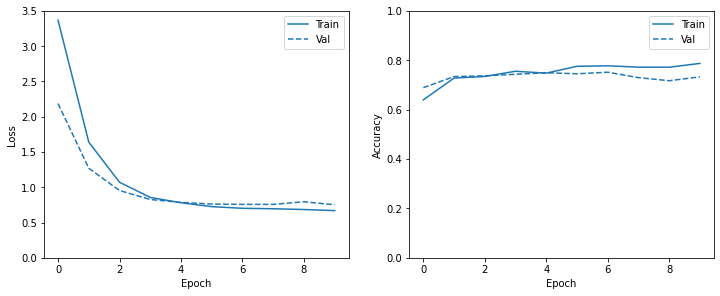

In [ ]:
model1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model1.history)
# print(model.history)

In [ ]:
prediction_prob = model1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.745
              precision    recall  f1-score   support

           0       1.00      0.01      0.02        84
           1       0.73      0.94      0.82       736
           2       0.82      0.52      0.64       380

    accuracy                           0.74      1200
   macro avg       0.85      0.49      0.49      1200
weighted avg       0.77      0.74      0.71      1200



# CNN1_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model1_1 = Model(inputs=[tweet_input], outputs=[output])
model1_1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 60, 100)      1723000     ['input_12[0][0]']               
                                                                                                  
 conv1d_31 (Conv1D)             (None, 60, 100)      20100       ['embedding_11[0][0]']           
                                                                                                  
 conv1d_32 (Conv1D)             (None, 60, 200)      60200       ['embedding_11[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model1_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 17ms/step - loss: 3.1381 - accuracy: 0.6549 - val_loss: 1.8980 - val_accuracy: 0.7094
Epoch 2/10
60/60 [==============================] - 1s 12ms/step - loss: 1.4090 - accuracy: 0.7307 - val_loss: 1.0844 - val_accuracy: 0.7365
Epoch 3/10
60/60 [==============================] - 1s 10ms/step - loss: 0.9371 - accuracy: 0.7453 - val_loss: 0.8700 - val_accuracy: 0.7354
Epoch 4/10
60/60 [==============================] - 1s 10ms/step - loss: 0.8067 - accuracy: 0.7510 - val_loss: 0.7925 - val_accuracy: 0.7281
Epoch 5/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7363 - accuracy: 0.7643 - val_loss: 0.7563 - val_accuracy: 0.7365
Epoch 6/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7242 - accuracy: 0.7505 - val_loss: 0.8114 - val_accuracy: 0.7083
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.7740 - val_loss: 0.7626 - val_accuracy: 0.7208
Epoch 8/10
60/60

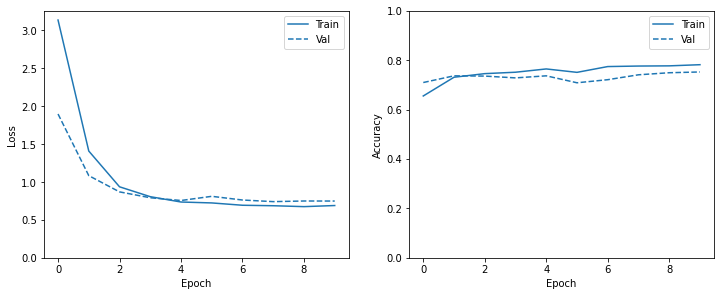

In [ ]:
model1_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model1_1.history)
# print(model.history)

In [ ]:
prediction_prob = model1_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7458333333333333
              precision    recall  f1-score   support

           0       0.43      0.04      0.07        84
           1       0.77      0.87      0.82       736
           2       0.70      0.66      0.68       380

    accuracy                           0.75      1200
   macro avg       0.63      0.52      0.52      1200
weighted avg       0.72      0.75      0.72      1200



# CNN2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(128)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model2 = Model(inputs=[tweet_input], outputs=[output])
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 60, 100)      1723000     ['input_13[0][0]']               
                                                                                                  
 conv1d_34 (Conv1D)             (None, 60, 64)       12864       ['embedding_12[0][0]']           
                                                                                                  
 conv1d_35 (Conv1D)             (None, 60, 64)       19264       ['embedding_12[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 15ms/step - loss: 2.6202 - accuracy: 0.6065 - val_loss: 1.8888 - val_accuracy: 0.6771
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 1.5453 - accuracy: 0.7018 - val_loss: 1.2479 - val_accuracy: 0.7354
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 1.1007 - accuracy: 0.7339 - val_loss: 0.9803 - val_accuracy: 0.7281
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8703 - accuracy: 0.7591 - val_loss: 0.8676 - val_accuracy: 0.7240
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7777 - accuracy: 0.7625 - val_loss: 0.8197 - val_accuracy: 0.7312
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6837 - accuracy: 0.8047 - val_loss: 0.8022 - val_accuracy: 0.7333
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6498 - accuracy: 0.8031 - val_loss: 0.7689 - val_accuracy: 0.7427
Epoch 8/10
60/60 [=

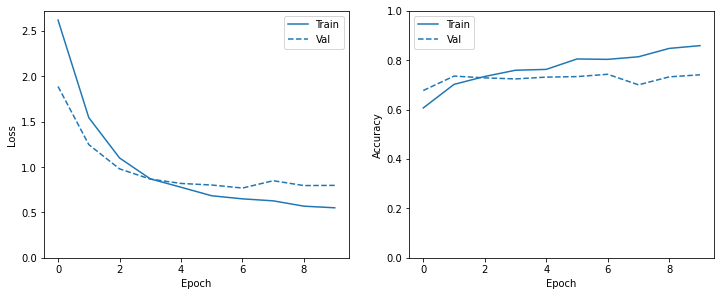

In [ ]:
model2.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model2.history)
# print(model.history)

In [ ]:
prediction_prob = model2.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7458333333333333
              precision    recall  f1-score   support

           0       0.41      0.29      0.34        84
           1       0.76      0.89      0.82       736
           2       0.78      0.56      0.65       380

    accuracy                           0.75      1200
   macro avg       0.65      0.58      0.60      1200
weighted avg       0.74      0.75      0.73      1200



# CNN4

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4 = Model(inputs=[tweet_input], outputs=[output])
model4.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 60, 100)      1723000     ['input_14[0][0]']               
                                                                                                  
 conv1d_37 (Conv1D)             (None, 60, 64)       12864       ['embedding_13[0][0]']           
                                                                                                  
 conv1d_38 (Conv1D)             (None, 60, 32)       9632        ['embedding_13[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 2.0262 - accuracy: 0.6466 - val_loss: 1.6365 - val_accuracy: 0.6917
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 1.3818 - accuracy: 0.7102 - val_loss: 1.2136 - val_accuracy: 0.7250
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0584 - accuracy: 0.7286 - val_loss: 0.9921 - val_accuracy: 0.7135
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8796 - accuracy: 0.7503 - val_loss: 0.8576 - val_accuracy: 0.7385
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7785 - accuracy: 0.7583 - val_loss: 0.7935 - val_accuracy: 0.7365
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7240 - accuracy: 0.7695 - val_loss: 0.7635 - val_accuracy: 0.7302
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6869 - accuracy: 0.7729 - val_loss: 0.7466 - val_accuracy: 0.7250
Epoch 8/10
60/60 [=

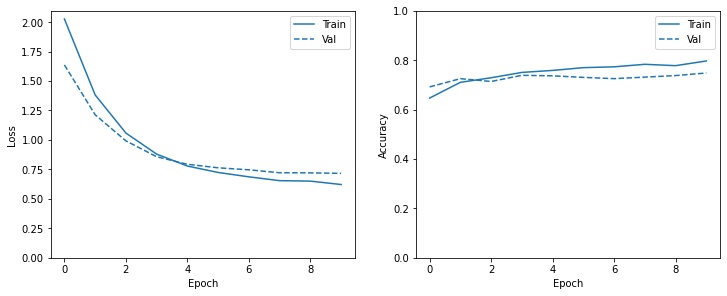

In [ ]:
model4.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4.history)
# print(model.history)

In [ ]:
prediction_prob = model4.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7408333333333333
              precision    recall  f1-score   support

           0       0.42      0.18      0.25        84
           1       0.78      0.83      0.81       736
           2       0.69      0.68      0.69       380

    accuracy                           0.74      1200
   macro avg       0.63      0.57      0.58      1200
weighted avg       0.73      0.74      0.73      1200



# CNN4_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4_1 = Model(inputs=[tweet_input], outputs=[output])
model4_1.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 60, 100)      1723000     ['input_15[0][0]']               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 60, 64)       12864       ['embedding_14[0][0]']           
                                                                                                  
 conv1d_41 (Conv1D)             (None, 60, 32)       9632        ['embedding_14[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 1.9497 - accuracy: 0.6242 - val_loss: 1.4927 - val_accuracy: 0.6812
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.2575 - accuracy: 0.6953 - val_loss: 1.0732 - val_accuracy: 0.7167
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9564 - accuracy: 0.7250 - val_loss: 0.8815 - val_accuracy: 0.7302
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8130 - accuracy: 0.7375 - val_loss: 0.7958 - val_accuracy: 0.7490
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7374 - accuracy: 0.7477 - val_loss: 0.7486 - val_accuracy: 0.7312
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.7555 - val_loss: 0.7142 - val_accuracy: 0.7375
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6655 - accuracy: 0.7742 - val_loss: 0.7043 - val_accuracy: 0.7406
Epoch 8/10
60/60 [=

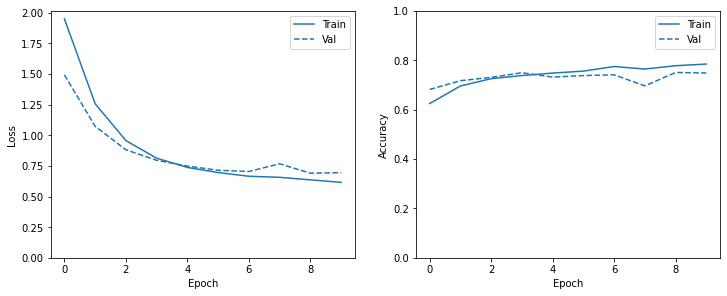

In [ ]:
model4_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4_1.history)
# print(model.history)

In [ ]:
prediction_prob = model4_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7391666666666666
              precision    recall  f1-score   support

           0       0.38      0.15      0.22        84
           1       0.76      0.86      0.81       736
           2       0.71      0.63      0.67       380

    accuracy                           0.74      1200
   macro avg       0.62      0.55      0.57      1200
weighted avg       0.72      0.74      0.72      1200



# CNN4_2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=16, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4_2 = Model(inputs=[tweet_input], outputs=[output])
model4_2.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 60, 100)      1723000     ['input_17[0][0]']               
                                                                                                  
 conv1d_46 (Conv1D)             (None, 60, 16)       3216        ['embedding_16[0][0]']           
                                                                                                  
 conv1d_47 (Conv1D)             (None, 60, 32)       9632        ['embedding_16[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4_2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 11ms/step - loss: 1.8431 - accuracy: 0.6534 - val_loss: 1.3859 - val_accuracy: 0.7083
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1621 - accuracy: 0.7128 - val_loss: 1.0082 - val_accuracy: 0.7312
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8927 - accuracy: 0.7297 - val_loss: 0.8516 - val_accuracy: 0.7240
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7735 - accuracy: 0.7539 - val_loss: 0.7832 - val_accuracy: 0.7156
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7075 - accuracy: 0.7635 - val_loss: 0.7425 - val_accuracy: 0.7521
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6706 - accuracy: 0.7677 - val_loss: 0.7283 - val_accuracy: 0.7563
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6564 - accuracy: 0.7810 - val_loss: 0.7124 - val_accuracy: 0.7271
Epoch 8/10
60/60 [=

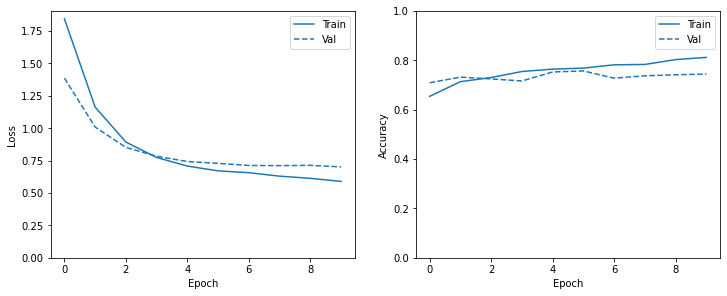

In [ ]:
model4_2.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4_2.history)
# print(model.history)

In [ ]:
prediction_prob = model4_2.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7575
              precision    recall  f1-score   support

           0       0.56      0.11      0.18        84
           1       0.76      0.91      0.83       736
           2       0.77      0.60      0.67       380

    accuracy                           0.76      1200
   macro avg       0.70      0.54      0.56      1200
weighted avg       0.75      0.76      0.73      1200



In [ ]:
model4_2.save('/content/gdrive/MyDrive/BSC-Project/saved_model/cnn4_2_not_pick_test.h5')

# CNN5

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model5 = Model(inputs=[tweet_input], outputs=[output])
model5.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 60, 100)      1723000     ['input_18[0][0]']               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 60, 50)       10050       ['embedding_17[0][0]']           
                                                                                                  
 conv1d_50 (Conv1D)             (None, 60, 100)      30100       ['embedding_17[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model5.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 2.1516 - accuracy: 0.6187 - val_loss: 1.6622 - val_accuracy: 0.7135
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.4396 - accuracy: 0.6979 - val_loss: 1.2195 - val_accuracy: 0.7229
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.0900 - accuracy: 0.7247 - val_loss: 0.9958 - val_accuracy: 0.7281
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9197 - accuracy: 0.7362 - val_loss: 0.8815 - val_accuracy: 0.7385
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8201 - accuracy: 0.7474 - val_loss: 0.8052 - val_accuracy: 0.7437
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7584 - accuracy: 0.7539 - val_loss: 0.7627 - val_accuracy: 0.7396
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7249 - accuracy: 0.7596 - val_loss: 0.7367 - val_accuracy: 0.7406
Epoch 8/10
60/60 [=

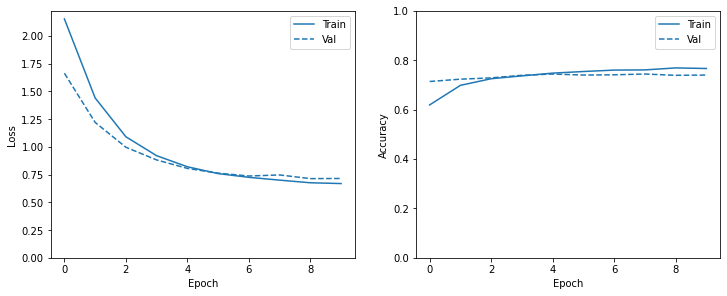

In [ ]:
model5.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model5.history)
# print(model.history)

In [ ]:
prediction_prob = model5.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7441666666666666
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        84
           1       0.73      0.93      0.82       736
           2       0.78      0.54      0.64       380

    accuracy                           0.74      1200
   macro avg       0.67      0.50      0.50      1200
weighted avg       0.73      0.74      0.71      1200



# CNN5_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model5_1 = Model(inputs=[tweet_input], outputs=[output])
model5_1.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 60, 100)      1723000     ['input_19[0][0]']               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 60, 50)       10050       ['embedding_18[0][0]']           
                                                                                                  
 conv1d_52 (Conv1D)             (None, 60, 100)      30100       ['embedding_18[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model5_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 2.1692 - accuracy: 0.6070 - val_loss: 1.6693 - val_accuracy: 0.7000
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.4504 - accuracy: 0.6880 - val_loss: 1.2273 - val_accuracy: 0.7094
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.1141 - accuracy: 0.7164 - val_loss: 0.9981 - val_accuracy: 0.7198
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9203 - accuracy: 0.7396 - val_loss: 0.8720 - val_accuracy: 0.7219
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8280 - accuracy: 0.7417 - val_loss: 0.8086 - val_accuracy: 0.7469
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7704 - accuracy: 0.7487 - val_loss: 0.7691 - val_accuracy: 0.7302
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7341 - accuracy: 0.7487 - val_loss: 0.7397 - val_accuracy: 0.7229
Epoch 8/10
60/60 [==

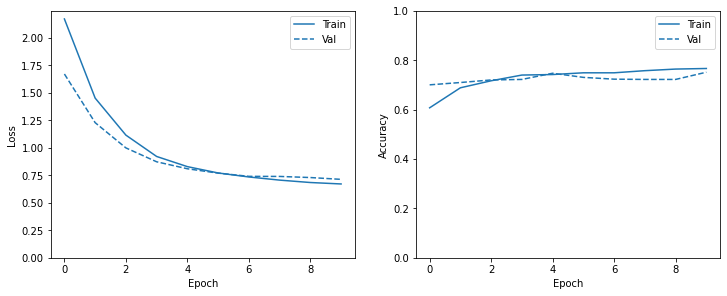

In [ ]:
model5_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model5_1.history)
# print(model.history)

In [ ]:
prediction_prob = model5_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7441666666666666
              precision    recall  f1-score   support

           0       0.62      0.06      0.11        84
           1       0.76      0.88      0.81       736
           2       0.71      0.64      0.67       380

    accuracy                           0.74      1200
   macro avg       0.70      0.53      0.53      1200
weighted avg       0.73      0.74      0.72      1200



# CNN6

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=1024, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=1024, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=1024, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model6 = Model(inputs=[tweet_input], outputs=[output])
model6.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 60, 100)      1723000     ['input_20[0][0]']               
                                                                                                  
 conv1d_53 (Conv1D)             (None, 60, 1024)     205824      ['embedding_19[0][0]']           
                                                                                                  
 conv1d_54 (Conv1D)             (None, 60, 1024)     308224      ['embedding_19[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model6.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 20ms/step - loss: 3.0826 - accuracy: 0.6742 - val_loss: 1.3639 - val_accuracy: 0.6875
Epoch 2/10
60/60 [==============================] - 1s 15ms/step - loss: 0.9986 - accuracy: 0.7292 - val_loss: 0.8832 - val_accuracy: 0.7010
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7916 - accuracy: 0.7404 - val_loss: 0.7738 - val_accuracy: 0.7333
Epoch 4/10
60/60 [==============================] - 1s 15ms/step - loss: 0.7712 - accuracy: 0.7484 - val_loss: 0.7608 - val_accuracy: 0.7365
Epoch 5/10
60/60 [==============================] - 1s 15ms/step - loss: 0.7764 - accuracy: 0.7333 - val_loss: 0.7977 - val_accuracy: 0.7490
Epoch 6/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7195 - accuracy: 0.7617 - val_loss: 0.7515 - val_accuracy: 0.7510
Epoch 7/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7193 - accuracy: 0.7638 - val_loss: 0.7910 - val_accuracy: 0.7115
Epoch 8/10
60

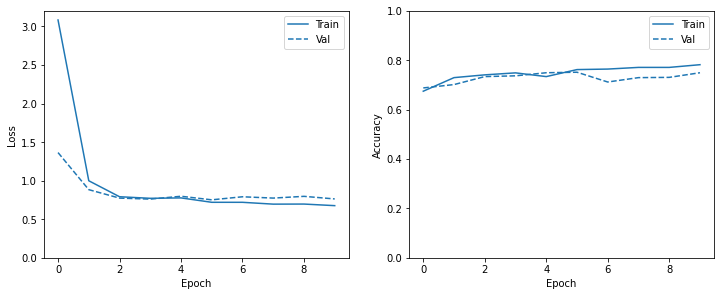

In [ ]:
model6.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model6.history)
# print(model.history)

In [ ]:
prediction_prob = model6.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7416666666666667
              precision    recall  f1-score   support

           0       0.75      0.04      0.07        84
           1       0.77      0.87      0.82       736
           2       0.68      0.66      0.67       380

    accuracy                           0.74      1200
   macro avg       0.73      0.52      0.52      1200
weighted avg       0.74      0.74      0.72      1200



# CNN7

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=128, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=256, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model7 = Model(inputs=[tweet_input], outputs=[output])
model7.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 60, 100)      1723000     ['input_21[0][0]']               
                                                                                                  
 conv1d_56 (Conv1D)             (None, 60, 64)       12864       ['embedding_20[0][0]']           
                                                                                                  
 conv1d_57 (Conv1D)             (None, 60, 128)      38528       ['embedding_20[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model7.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 11ms/step - loss: 2.8520 - accuracy: 0.6531 - val_loss: 1.8196 - val_accuracy: 0.7219
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.3755 - accuracy: 0.7367 - val_loss: 1.1139 - val_accuracy: 0.7000
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9360 - accuracy: 0.7555 - val_loss: 0.8804 - val_accuracy: 0.7354
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7782 - accuracy: 0.7625 - val_loss: 0.7881 - val_accuracy: 0.7271
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7064 - accuracy: 0.7701 - val_loss: 0.7671 - val_accuracy: 0.7229
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6836 - accuracy: 0.7740 - val_loss: 0.7414 - val_accuracy: 0.7333
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6515 - accuracy: 0.7914 - val_loss: 0.7514 - val_accuracy: 0.7198
Epoch 8/10
60/60 [=

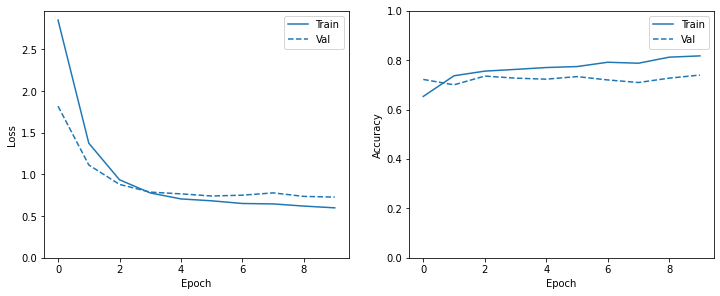

In [ ]:
model7.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model7.history)
# print(model.history)

In [ ]:
prediction_prob = model7.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7483333333333333
              precision    recall  f1-score   support

           0       0.50      0.05      0.09        84
           1       0.75      0.91      0.82       736
           2       0.74      0.59      0.66       380

    accuracy                           0.75      1200
   macro avg       0.67      0.52      0.52      1200
weighted avg       0.73      0.75      0.72      1200



# Pick Test First

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')


# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # token = token.lower()
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = token.replace("#", "").replace("_", " ")

        

        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'wb') as fp:
#         pickle.dump(X_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'wb') as fp:
#         pickle.dump(X_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data_train = []
data_test = []

In [ ]:
for x, y in zip(X_train, Y_train):
    
        data_train.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_train[:5]

[(['It',
   'had',
   'partnered',
   'with',
   'the',
   '#Russian',
   'Direct',
   'Investment',
   'Fund',
   '(',
   'RDIF',
   ')',
   'in',
   'September',
   '2020',
   'to',
   'conduct',
   'clinical',
   'trials',
   'for',
   '#SputnikV',
   '.',
   'https://t.co/TAlQlELsoR'],
  1),
 (['A',
   'batch',
   'of',
   'China-donated',
   '#Sinopharm',
   'vaccine',
   'arrived',
   'in',
   'Brazzaville',
   ',',
   'capital',
   'of',
   'the',
   'Republic',
   'of',
   '#Congo',
   ',',
   'on',
   'Wednesday',
   '.',
   'Congolese',
   'health',
   'minister',
   ',',
   'minister',
   'of',
   'foreign',
   'affairs',
   ',',
   'national',
   'defense',
   'minister',
   'and',
   'Chinese',
   'ambassador',
   'to',
   'the',
   'Congo',
   'welcomed',
   'the',
   'vaccine',
   'at',
   'the',
   'airport',
   '.',
   'https://t.co/ltF0ZZ87mx'],
  1),
 (['The',
   'Colombo',
   'Municipal',
   'Council',
   '(',
   'CMC',
   ')',
   'is',
   'to',
   'inoculate',
   '

In [ ]:
for x, y in zip(X_test, Y_test):
    
        data_test.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_test[:5]

[(['Got',
   'to',
   'admit',
   ',',
   '#Moderna',
   'second',
   'round',
   'took',
   'me',
   'for',
   'a',
   'quite',
   'a',
   'ride',
   'there',
   'overnight',
   '.',
   'They',
   'weren',
   '\x92',
   't',
   'messing',
   'around',
   'with',
   'these',
   'vaccines'],
  0),
 (['U',
   '.',
   'S',
   '.',
   '#scientists',
   'doubtful',
   'of',
   '#one-shot',
   'regimen',
   'for',
   '#Pfizer',
   ',',
   '#Moderna',
   '#COVID',
   '#vaccines',
   ':',
   '#WSJ',
   '#reuters',
   'https://t.co/jz0whryYnf',
   '#mrna',
   '#us',
   '#bidenharris',
   '#health',
   '#world',
   '#biotech',
   '#mkt'],
  1),
 (['#COVID19Vaccination',
   'coverage',
   'in',
   'India',
   'as',
   'of',
   '8',
   'AM',
   '|',
   '04.04',
   '.',
   '2021',
   'Total',
   'Beneficiaries',
   'Vaccinated',
   ':',
   '7,59',
   ',',
   '79,651',
   '27,38',
   ',',
   '972',
   'were',
   'vaccinated',
   'in',
   'last',
   '24',
   'hours',
   '.',
   'For',
   '1st',
   'D

In [ ]:
cleaned_tokens_list_train = []

# Removing noise from all the data
for tokens, label in data_train:
    cleaned_tokens_list_train.append((remove_noise5(tokens), label))

In [ ]:
cleaned_tokens_list_test = []

# Removing noise from all the data
for tokens, label in data_test:
    cleaned_tokens_list_test.append((remove_noise5(tokens), label))

In [ ]:
sentences_array_train = [s[0] for s in cleaned_tokens_list_train]
sentences_train = []

for s in sentences_array_train :
  sentence_train = ' '.join(map(str ,s))
  sentences_train.append(sentence_train)

print(len(sentences_train))
print(sentences_train[0])
print(sentences_array_train[0])

4800
It had partnered with the Russian Direct Investment Fund RDIF in September <NUMBER> to conduct clinical trials for SputnikV
['It', 'had', 'partnered', 'with', 'the', 'Russian', 'Direct', 'Investment', 'Fund', 'RDIF', 'in', 'September', '<NUMBER>', 'to', 'conduct', 'clinical', 'trials', 'for', 'SputnikV']


In [ ]:
all_train_words = []

for s in sentences_array_train:
  for w in s :
    all_train_words.append(w)

print('All train word : {}'.format(len(all_train_words)))

unique_train_word = []

for w in all_train_words:
  if w not in unique_train_word:
    unique_train_word.append(w)
    

print('unique train word : {}'.format(len(unique_train_word)))

All train word : 120561
unique train word : 15087


In [ ]:
sentences_array_test = [s[0] for s in cleaned_tokens_list_test]
sentences_test = []

for s in sentences_array_test :
  sentence_test = ' '.join(map(str ,s))
  sentences_test.append(sentence_test)

print(sentences_test[0])
print(sentences_array_test[0])

Got to admit Moderna second round took me for a quite a ride there overnight They weren t messing around with these vaccines
['Got', 'to', 'admit', 'Moderna', 'second', 'round', 'took', 'me', 'for', 'a', 'quite', 'a', 'ride', 'there', 'overnight', 'They', 'weren', 't', 'messing', 'around', 'with', 'these', 'vaccines']


In [ ]:
all_test_words = []

for s in sentences_array_test:
  for w in s :
    all_test_words.append(w)

print('All test word : {}'.format(len(all_test_words)))

unique_test_word = []

for w in all_test_words:
  if w not in unique_test_word:
    unique_test_word.append(w)

print('unique train word : {}'.format(len(unique_test_word)))

All test word : 29912
unique train word : 6218


In [ ]:
all_unique_words = []

for word in unique_train_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

for word in unique_test_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

print("Number of All unique word : {}".format(len(all_unique_words)))

Number of All unique word : 17230


In [ ]:
word_to_index = {}
i = 1

for word in all_unique_words :
  word_to_index[word] = i
  i+=1

word_to_index

{'It': 1,
 'had': 2,
 'partnered': 3,
 'with': 4,
 'the': 5,
 'Russian': 6,
 'Direct': 7,
 'Investment': 8,
 'Fund': 9,
 'RDIF': 10,
 'in': 11,
 'September': 12,
 '<NUMBER>': 13,
 'to': 14,
 'conduct': 15,
 'clinical': 16,
 'trials': 17,
 'for': 18,
 'SputnikV': 19,
 'A': 20,
 'batch': 21,
 'of': 22,
 'China-donated': 23,
 'Sinopharm': 24,
 'vaccine': 25,
 'arrived': 26,
 'Brazzaville': 27,
 'capital': 28,
 'Republic': 29,
 'Congo': 30,
 'on': 31,
 'Wednesday': 32,
 'Congolese': 33,
 'health': 34,
 'minister': 35,
 'foreign': 36,
 'affairs': 37,
 'national': 38,
 'defense': 39,
 'and': 40,
 'Chinese': 41,
 'ambassador': 42,
 'welcomed': 43,
 'at': 44,
 'airport': 45,
 'The': 46,
 'Colombo': 47,
 'Municipal': 48,
 'Council': 49,
 'CMC': 50,
 'is': 51,
 'inoculate': 52,
 '<NUMBER>,<NUMBER>': 53,
 'nationals': 54,
 'from': 55,
 'Monday': 56,
 'using': 57,
 'Read': 58,
 'full': 59,
 'story': 60,
 'here': 61,
 'via': 62,
 'Srilanka': 63,
 'lka': 64,
 'China': 65,
 'colombo': 66,
 'This': 67

In [ ]:
import json

with open('/content/gdrive/MyDrive/BSC-Project/word_to_index.json', 'w') as fp:
    json.dump(word_to_index, fp)

In [ ]:
list_len_train = [len(i.split()) for i in sentences_train]
max_len_train = max(list_len_train)
print('max_len:', max_len_train)

max_len: 60


In [ ]:
list_len_test = [len(i.split()) for i in sentences_test]
max_len_test = max(list_len_test)
print('max_len:', max_len_test)

max_len: 54


In [ ]:
Y_test = np.zeros((len(cleaned_tokens_list_test), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list_test):
    tokens, label = tk_lb
    Y_test[i] = label

len(Y_test)

1200

In [ ]:
Y_train = np.zeros((len(cleaned_tokens_list_train), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list_train):
    tokens, label = tk_lb
    Y_train[i] = label

len(Y_train)

4800

In [ ]:
X_sequences_train = []
for s in sentences_array_train:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences_train.append(temp)

len(X_sequences_train)

4800

In [ ]:
X_sequences_test = []
for s in sentences_array_test:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences_test.append(temp)

len(X_sequences_test)

1200

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded_train = pad_sequences(X_sequences_train,maxlen=max_len_train ,padding='post')
X_padded_train = np.array(X_padded_train)
len(X_padded_train)

4800

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded_test = pad_sequences(X_sequences_test,maxlen=max_len_train ,padding='post')
X_padded_test = np.array(X_padded_test)
len(X_padded_test)

1200

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec9', 'wb') as fp:
#         pickle.dump(X_padded_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec9', 'wb') as fp:
#         pickle.dump(X_padded_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec9', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec9', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec9', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/XtestVec9', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec9', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec9', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_7.model")

In [ ]:
EMBEDDING_DIM=100

UNK = 0



for word  in unique_train_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
        

print('OOV Train : {}'.format(UNK))

OOV Train : 0


In [ ]:
EMBEDDING_DIM=100

UNK = 0


for word in unique_test_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
       
         
print('OOV Test: {}'.format(UNK)) 

OOV Test: 197


In [ ]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((len(word_to_index), EMBEDDING_DIM))
UNK = 0

i = 0
for word,i in word_to_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
        UNK += 1
        
        
print('Number of all unique train word = {}'.format(len(word_to_index)))       
print('Number of OOV Train = {}'.format(UNK))    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix10', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

Number of all unique train word = 13483
Number of OOV Train = 198
(17230, 100)
[-0.15686825 -0.0557613   0.32904592 -0.12882128  0.20509587  0.21521436
  0.6278317  -1.342291    0.55375844  0.11973358 -0.21493977 -0.07543492
  0.33000383 -0.24911988  0.09218241 -0.45896035 -0.98536289  0.07218886
 -0.3142229  -0.08863966  0.79529166  0.54140633  0.12177644  0.29856974
 -0.01553513  0.03490803 -0.09268345 -0.34594768  0.2672779   0.08138833
  0.46763897 -0.40017515 -0.37672535 -0.84937954 -0.98142332  0.21633719
  0.05693539 -0.28278464  0.70553666 -0.12299018 -0.53136933  0.55299217
 -0.55297893  0.03193011 -0.25657165 -0.44155937  0.25513464  0.29240334
 -0.95126486 -0.14364654 -0.03768465  0.40501851  0.71834052 -0.18297854
 -0.2055957   0.57904953  0.16629437 -0.46495041  0.55180627  0.82935214
  0.07605773 -0.05763659 -0.06870662 -0.76314449  0.29104483 -0.05768737
 -0.04043188 -0.55013162 -0.95159578  0.32563046 -0.11357542 -0.34766573
 -0.11801147 -0.60051876 -0.80825579  0.22219

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix10', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

# CNN1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model1 = Model(inputs=[tweet_input], outputs=[output])
model1.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 60, 100)      1723000     ['input_22[0][0]']               
                                                                                                  
 conv1d_59 (Conv1D)             (None, 60, 100)      20100       ['embedding_21[0][0]']           
                                                                                                  
 conv1d_60 (Conv1D)             (None, 60, 200)      60200       ['embedding_21[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 13ms/step - loss: 3.2475 - accuracy: 0.6544 - val_loss: 2.0668 - val_accuracy: 0.6896
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.5669 - accuracy: 0.7154 - val_loss: 1.2246 - val_accuracy: 0.7177
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0494 - accuracy: 0.7370 - val_loss: 0.9404 - val_accuracy: 0.7167
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8447 - accuracy: 0.7573 - val_loss: 0.8500 - val_accuracy: 0.7469
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7665 - accuracy: 0.7651 - val_loss: 0.7836 - val_accuracy: 0.7396
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7291 - accuracy: 0.7570 - val_loss: 0.7549 - val_accuracy: 0.7312
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7051 - accuracy: 0.7677 - val_loss: 0.7509 - val_accuracy: 0.7406
Epoch 8/10
60/60 [=

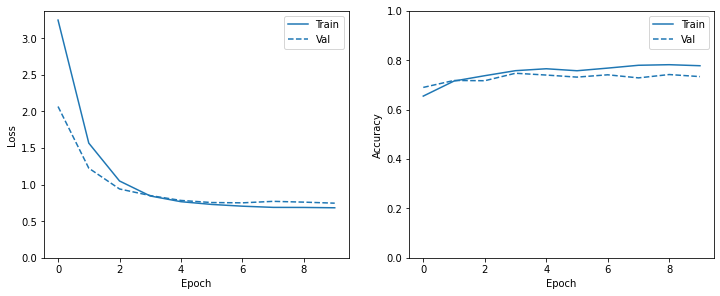

In [ ]:
model1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model1.history)
# print(model.history)

In [ ]:
prediction_prob = model1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7575
              precision    recall  f1-score   support

           0       0.54      0.08      0.14        84
           1       0.74      0.94      0.83       736
           2       0.83      0.54      0.66       380

    accuracy                           0.76      1200
   macro avg       0.70      0.52      0.54      1200
weighted avg       0.76      0.76      0.73      1200



In [ ]:
model1.save('/content/gdrive/MyDrive/BSC-Project/saved_model/ccn1_pick_test.h5')

# CNN1_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model1_1 = Model(inputs=[tweet_input], outputs=[output])
model1_1.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 60, 100)      1723000     ['input_24[0][0]']               
                                                                                                  
 conv1d_65 (Conv1D)             (None, 60, 100)      20100       ['embedding_23[0][0]']           
                                                                                                  
 conv1d_66 (Conv1D)             (None, 60, 200)      60200       ['embedding_23[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model1_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 17ms/step - loss: 3.2931 - accuracy: 0.6214 - val_loss: 2.0671 - val_accuracy: 0.6656
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 1.5368 - accuracy: 0.7078 - val_loss: 1.1869 - val_accuracy: 0.7281
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 1.0059 - accuracy: 0.7404 - val_loss: 0.9057 - val_accuracy: 0.7312
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8304 - accuracy: 0.7536 - val_loss: 0.8232 - val_accuracy: 0.7208
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7550 - accuracy: 0.7542 - val_loss: 0.7799 - val_accuracy: 0.7469
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7242 - accuracy: 0.7615 - val_loss: 0.8056 - val_accuracy: 0.7323
Epoch 7/10
60/60 [==============================] - 1s 9ms/step - loss: 0.6990 - accuracy: 0.7656 - val_loss: 0.7600 - val_accuracy: 0.7302
Epoch 8/10
60/60 [=

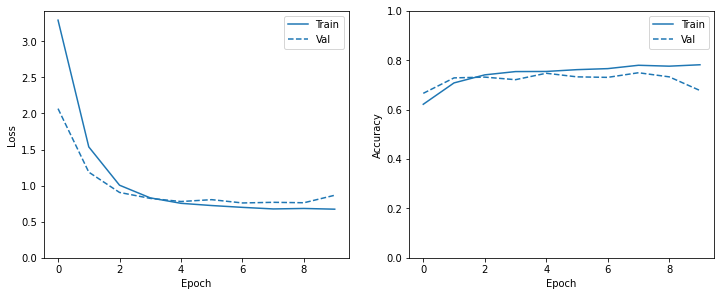

In [ ]:
model1_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model1_1.history)
# print(model.history)

In [ ]:
prediction_prob = model1_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7025
              precision    recall  f1-score   support

           0       0.40      0.07      0.12        84
           1       0.68      0.99      0.81       736
           2       0.94      0.29      0.45       380

    accuracy                           0.70      1200
   macro avg       0.67      0.45      0.46      1200
weighted avg       0.74      0.70      0.64      1200



# CNN2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(128)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model2 = Model(inputs=[tweet_input], outputs=[output])
model2.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 60, 100)      1723000     ['input_25[0][0]']               
                                                                                                  
 conv1d_68 (Conv1D)             (None, 60, 64)       12864       ['embedding_24[0][0]']           
                                                                                                  
 conv1d_69 (Conv1D)             (None, 60, 64)       19264       ['embedding_24[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 11ms/step - loss: 2.6375 - accuracy: 0.6109 - val_loss: 1.9099 - val_accuracy: 0.7042
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.5585 - accuracy: 0.6951 - val_loss: 1.2831 - val_accuracy: 0.7177
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1092 - accuracy: 0.7305 - val_loss: 1.0016 - val_accuracy: 0.7469
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8964 - accuracy: 0.7589 - val_loss: 0.8805 - val_accuracy: 0.7427
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7896 - accuracy: 0.7641 - val_loss: 0.8199 - val_accuracy: 0.7406
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7179 - accuracy: 0.7844 - val_loss: 0.7903 - val_accuracy: 0.7385
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6539 - accuracy: 0.8076 - val_loss: 0.7869 - val_accuracy: 0.7344
Epoch 8/10
60/60 [=

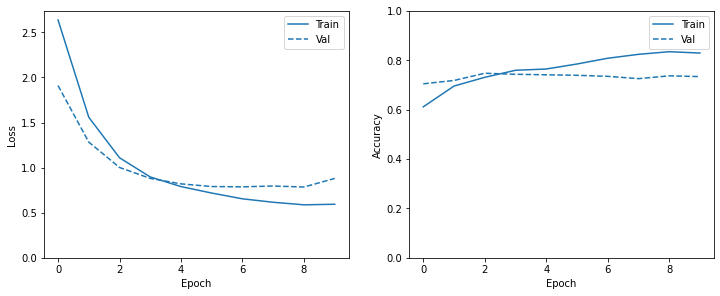

In [ ]:
model2.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model2.history)
# print(model.history)

In [ ]:
prediction_prob = model2.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7475
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        84
           1       0.73      0.95      0.82       736
           2       0.83      0.51      0.63       380

    accuracy                           0.75      1200
   macro avg       0.85      0.50      0.51      1200
weighted avg       0.78      0.75      0.71      1200



# CNN4

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4 = Model(inputs=[tweet_input], outputs=[output])
model4.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 60, 100)      1723000     ['input_26[0][0]']               
                                                                                                  
 conv1d_71 (Conv1D)             (None, 60, 64)       12864       ['embedding_25[0][0]']           
                                                                                                  
 conv1d_72 (Conv1D)             (None, 60, 32)       9632        ['embedding_25[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 10ms/step - loss: 2.0104 - accuracy: 0.6448 - val_loss: 1.6290 - val_accuracy: 0.6854
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.3875 - accuracy: 0.7073 - val_loss: 1.2147 - val_accuracy: 0.7135
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0694 - accuracy: 0.7318 - val_loss: 1.0105 - val_accuracy: 0.7188
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8971 - accuracy: 0.7482 - val_loss: 0.8909 - val_accuracy: 0.7396
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7945 - accuracy: 0.7628 - val_loss: 0.8161 - val_accuracy: 0.7427
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7435 - accuracy: 0.7635 - val_loss: 0.7966 - val_accuracy: 0.7177
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7032 - accuracy: 0.7747 - val_loss: 0.7441 - val_accuracy: 0.7365
Epoch 8/10
60/60 [=

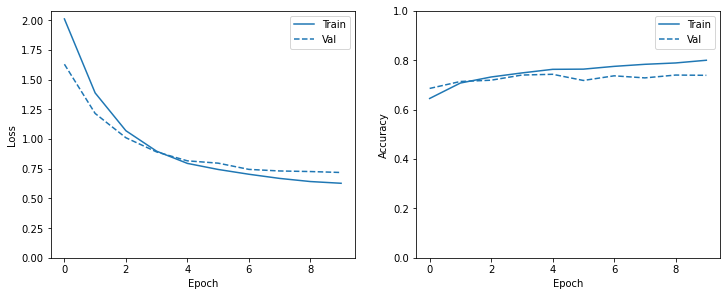

In [ ]:
model4.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4.history)
# print(model.history)

In [ ]:
prediction_prob = model4.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7408333333333333
              precision    recall  f1-score   support

           0       0.39      0.08      0.14        84
           1       0.73      0.92      0.82       736
           2       0.79      0.53      0.64       380

    accuracy                           0.74      1200
   macro avg       0.64      0.51      0.53      1200
weighted avg       0.73      0.74      0.71      1200



# CNN4_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4_1 = Model(inputs=[tweet_input], outputs=[output])
model4_1.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_26 (Embedding)       (None, 60, 100)      1723000     ['input_27[0][0]']               
                                                                                                  
 conv1d_74 (Conv1D)             (None, 60, 64)       12864       ['embedding_26[0][0]']           
                                                                                                  
 conv1d_75 (Conv1D)             (None, 60, 32)       9632        ['embedding_26[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6147 - accuracy: 0.7865 - val_loss: 0.6904 - val_accuracy: 0.7437
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 0.5914 - accuracy: 0.8049 - val_loss: 0.6987 - val_accuracy: 0.7417
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.5817 - accuracy: 0.8115 - val_loss: 0.6963 - val_accuracy: 0.7354
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.5663 - accuracy: 0.8161 - val_loss: 0.7070 - val_accuracy: 0.7281
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.5652 - accuracy: 0.8156 - val_loss: 0.6948 - val_accuracy: 0.7417
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.5643 - accuracy: 0.8180 - val_loss: 0.7282 - val_accuracy: 0.7406
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.5413 - accuracy: 0.8258 - val_loss: 0.6962 - val_accuracy: 0.7437
Epoch 8/10
60/60 [==

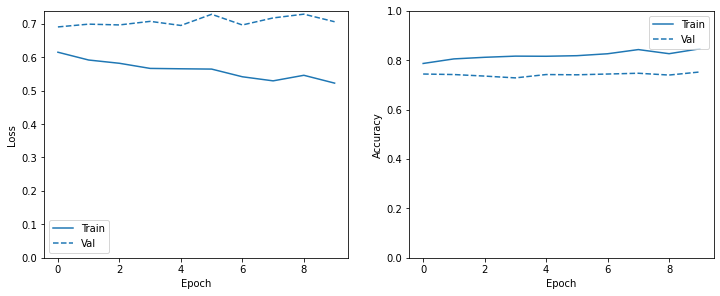

In [ ]:
model4_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4_1.history)
# print(model.history)

In [ ]:
prediction_prob = model4_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7466666666666667
              precision    recall  f1-score   support

           0       0.47      0.17      0.25        84
           1       0.78      0.86      0.82       736
           2       0.70      0.65      0.68       380

    accuracy                           0.75      1200
   macro avg       0.65      0.56      0.58      1200
weighted avg       0.73      0.75      0.73      1200



# CNN4_2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=16, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4_2 = Model(inputs=[tweet_input], outputs=[output])
model4_2.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_27 (Embedding)       (None, 60, 100)      1723000     ['input_28[0][0]']               
                                                                                                  
 conv1d_77 (Conv1D)             (None, 60, 16)       3216        ['embedding_27[0][0]']           
                                                                                                  
 conv1d_78 (Conv1D)             (None, 60, 32)       9632        ['embedding_27[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4_2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 10ms/step - loss: 1.9649 - accuracy: 0.6268 - val_loss: 1.4897 - val_accuracy: 0.7000
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.2442 - accuracy: 0.7104 - val_loss: 1.0822 - val_accuracy: 0.7312
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9549 - accuracy: 0.7326 - val_loss: 0.9132 - val_accuracy: 0.7323
Epoch 4/10
60/60 [==============================] - 1s 11ms/step - loss: 0.8195 - accuracy: 0.7477 - val_loss: 0.8084 - val_accuracy: 0.7427
Epoch 5/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7404 - accuracy: 0.7615 - val_loss: 0.7706 - val_accuracy: 0.7125
Epoch 6/10
60/60 [==============================] - 1s 9ms/step - loss: 0.6966 - accuracy: 0.7698 - val_loss: 0.7370 - val_accuracy: 0.7271
Epoch 7/10
60/60 [==============================] - 1s 9ms/step - loss: 0.6652 - accuracy: 0.7828 - val_loss: 0.7281 - val_accuracy: 0.7458
Epoch 8/10
60/60 [

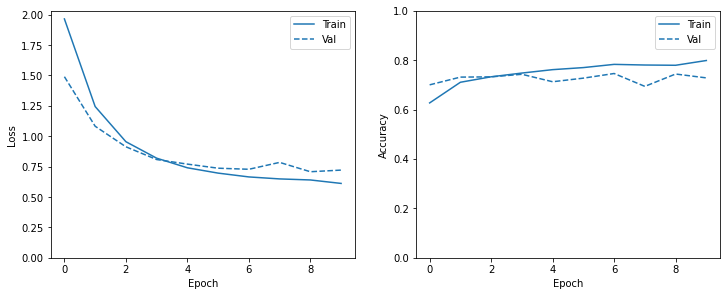

In [ ]:
model4_2.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4_2.history)
# print(model.history)

In [ ]:
prediction_prob = model4_2.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.74
              precision    recall  f1-score   support

           0       0.57      0.05      0.09        84
           1       0.72      0.96      0.82       736
           2       0.85      0.48      0.61       380

    accuracy                           0.74      1200
   macro avg       0.71      0.49      0.51      1200
weighted avg       0.75      0.74      0.70      1200



# CNN5

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model5 = Model(inputs=[tweet_input], outputs=[output])
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 100)      1723000     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 60, 50)       10050       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 60, 100)      30100       ['embedding[0][0]']              
                                                                                              

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model5.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 2.1800 - accuracy: 0.6159 - val_loss: 1.7048 - val_accuracy: 0.7052
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 1.4714 - accuracy: 0.6995 - val_loss: 1.2590 - val_accuracy: 0.7219
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.1157 - accuracy: 0.7284 - val_loss: 1.0202 - val_accuracy: 0.7135
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9287 - accuracy: 0.7378 - val_loss: 0.8861 - val_accuracy: 0.7260
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8212 - accuracy: 0.7474 - val_loss: 0.8173 - val_accuracy: 0.7260
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7571 - accuracy: 0.7573 - val_loss: 0.7727 - val_accuracy: 0.7469
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7236 - accuracy: 0.7581 - val_loss: 0.7435 - val_accuracy: 0.7437
Epoch 8/10
60/60 [==

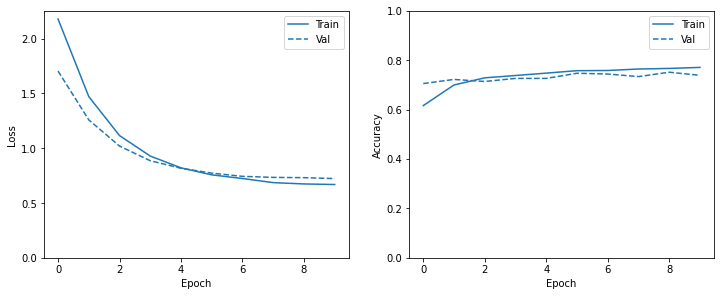

In [ ]:
model5.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model5.history)
# print(model.history)

In [ ]:
prediction_prob = model5.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 5ms/step
Accuracy of prediction on test set :  0.7516666666666667
              precision    recall  f1-score   support

           0       0.37      0.17      0.23        84
           1       0.76      0.90      0.83       736
           2       0.77      0.59      0.67       380

    accuracy                           0.75      1200
   macro avg       0.63      0.55      0.57      1200
weighted avg       0.74      0.75      0.73      1200



# CNN5_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model5_1 = Model(inputs=[tweet_input], outputs=[output])
model5_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 60, 100)      1723000     ['input_2[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 60, 50)       10050       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_3 (Conv1D)              (None, 60, 100)      30100       ['embedding_1[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model5_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 11s 14ms/step - loss: 2.0936 - accuracy: 0.6055 - val_loss: 1.5645 - val_accuracy: 0.7052
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.3309 - accuracy: 0.6885 - val_loss: 1.1207 - val_accuracy: 0.7188
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0036 - accuracy: 0.7135 - val_loss: 0.9116 - val_accuracy: 0.7302
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8520 - accuracy: 0.7370 - val_loss: 0.8223 - val_accuracy: 0.7156
Epoch 5/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7741 - accuracy: 0.7312 - val_loss: 0.7632 - val_accuracy: 0.7479
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7293 - accuracy: 0.7469 - val_loss: 0.7390 - val_accuracy: 0.7365
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6967 - accuracy: 0.7529 - val_loss: 0.7189 - val_accuracy: 0.7208
Epoch 8/10
60/60 [

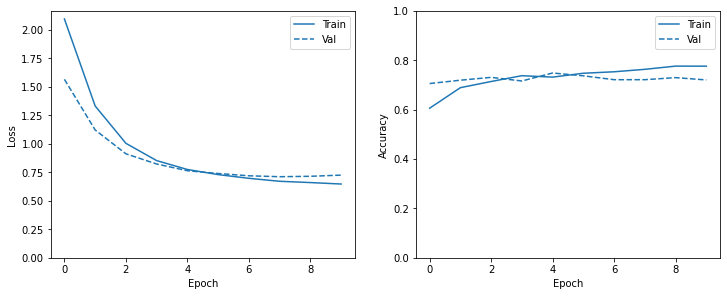

In [ ]:
model5_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model5_1.history)
# print(model.history)

In [ ]:
prediction_prob = model5_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.72
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.70      0.97      0.81       736
           2       0.86      0.40      0.55       380

    accuracy                           0.72      1200
   macro avg       0.52      0.46      0.45      1200
weighted avg       0.70      0.72      0.67      1200



# CNN6

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=1024, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=1024, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=1024, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model6 = Model(inputs=[tweet_input], outputs=[output])
model6.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 60, 100)      1723000     ['input_31[0][0]']               
                                                                                                  
 conv1d_84 (Conv1D)             (None, 60, 1024)     205824      ['embedding_30[0][0]']           
                                                                                                  
 conv1d_85 (Conv1D)             (None, 60, 1024)     308224      ['embedding_30[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model6.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 30ms/step - loss: 3.2109 - accuracy: 0.6664 - val_loss: 1.3730 - val_accuracy: 0.7240
Epoch 2/10
60/60 [==============================] - 1s 19ms/step - loss: 1.0339 - accuracy: 0.7328 - val_loss: 0.8531 - val_accuracy: 0.7396
Epoch 3/10
60/60 [==============================] - 1s 21ms/step - loss: 0.8146 - accuracy: 0.7344 - val_loss: 0.8004 - val_accuracy: 0.7240
Epoch 4/10
60/60 [==============================] - 1s 19ms/step - loss: 0.7503 - accuracy: 0.7479 - val_loss: 0.7761 - val_accuracy: 0.7146
Epoch 5/10
60/60 [==============================] - 1s 21ms/step - loss: 0.7320 - accuracy: 0.7479 - val_loss: 0.7546 - val_accuracy: 0.7490
Epoch 6/10
60/60 [==============================] - 1s 21ms/step - loss: 0.7072 - accuracy: 0.7646 - val_loss: 0.7630 - val_accuracy: 0.7354
Epoch 7/10
60/60 [==============================] - 1s 21ms/step - loss: 0.7636 - accuracy: 0.7378 - val_loss: 0.8575 - val_accuracy: 0.6781
Epoch 8/10
60

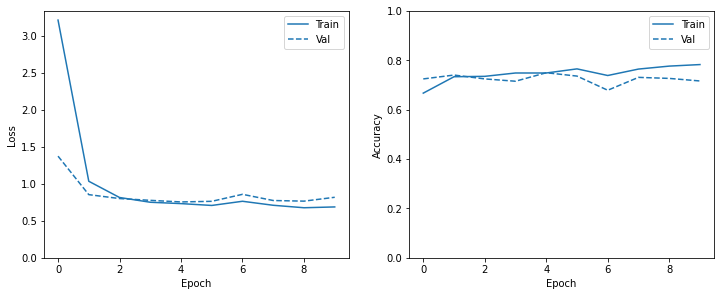

In [ ]:
model6.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model6.history)
# print(model.history)

In [ ]:
prediction_prob = model6.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 6ms/step
Accuracy of prediction on test set :  0.7275
              precision    recall  f1-score   support

           0       0.36      0.11      0.17        84
           1       0.71      0.96      0.82       736
           2       0.87      0.42      0.56       380

    accuracy                           0.73      1200
   macro avg       0.65      0.49      0.51      1200
weighted avg       0.74      0.73      0.69      1200



# CNN7

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17230 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=128, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=256, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model7 = Model(inputs=[tweet_input], outputs=[output])
model7.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_31 (Embedding)       (None, 60, 100)      1723000     ['input_32[0][0]']               
                                                                                                  
 conv1d_87 (Conv1D)             (None, 60, 64)       12864       ['embedding_31[0][0]']           
                                                                                                  
 conv1d_88 (Conv1D)             (None, 60, 128)      38528       ['embedding_31[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model7.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 18ms/step - loss: 2.8334 - accuracy: 0.6669 - val_loss: 1.7698 - val_accuracy: 0.7208
Epoch 2/10
60/60 [==============================] - 1s 8ms/step - loss: 1.3069 - accuracy: 0.7352 - val_loss: 1.0516 - val_accuracy: 0.7146
Epoch 3/10
60/60 [==============================] - 1s 9ms/step - loss: 0.8975 - accuracy: 0.7461 - val_loss: 0.8629 - val_accuracy: 0.7156
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7648 - accuracy: 0.7615 - val_loss: 0.8048 - val_accuracy: 0.7219
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7011 - accuracy: 0.7771 - val_loss: 0.7446 - val_accuracy: 0.7240
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6746 - accuracy: 0.7732 - val_loss: 0.7519 - val_accuracy: 0.7271
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6521 - accuracy: 0.7875 - val_loss: 0.7656 - val_accuracy: 0.7188
Epoch 8/10
60/60 [=

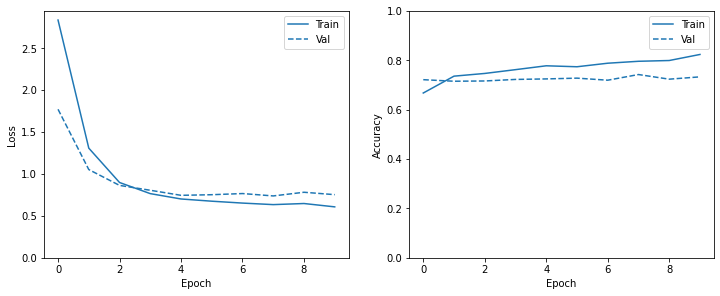

In [ ]:
model7.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model7.history)
# print(model.history)

In [ ]:
prediction_prob = model7.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7383333333333333
              precision    recall  f1-score   support

           0       0.33      0.07      0.12        84
           1       0.72      0.96      0.82       736
           2       0.87      0.46      0.60       380

    accuracy                           0.74      1200
   macro avg       0.64      0.50      0.51      1200
weighted avg       0.74      0.74      0.70      1200



# Replace OOV With Avg

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')


# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # token = token.lower()
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = token.replace("#", "").replace("_", " ")

        

        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'wb') as fp:
#         pickle.dump(X_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'wb') as fp:
#         pickle.dump(X_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data_train = []
data_test = []

In [ ]:
for x, y in zip(X_train, Y_train):
    
        data_train.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_train[:5]

[(['It',
   'had',
   'partnered',
   'with',
   'the',
   '#Russian',
   'Direct',
   'Investment',
   'Fund',
   '(',
   'RDIF',
   ')',
   'in',
   'September',
   '2020',
   'to',
   'conduct',
   'clinical',
   'trials',
   'for',
   '#SputnikV',
   '.',
   'https://t.co/TAlQlELsoR'],
  1),
 (['A',
   'batch',
   'of',
   'China-donated',
   '#Sinopharm',
   'vaccine',
   'arrived',
   'in',
   'Brazzaville',
   ',',
   'capital',
   'of',
   'the',
   'Republic',
   'of',
   '#Congo',
   ',',
   'on',
   'Wednesday',
   '.',
   'Congolese',
   'health',
   'minister',
   ',',
   'minister',
   'of',
   'foreign',
   'affairs',
   ',',
   'national',
   'defense',
   'minister',
   'and',
   'Chinese',
   'ambassador',
   'to',
   'the',
   'Congo',
   'welcomed',
   'the',
   'vaccine',
   'at',
   'the',
   'airport',
   '.',
   'https://t.co/ltF0ZZ87mx'],
  1),
 (['The',
   'Colombo',
   'Municipal',
   'Council',
   '(',
   'CMC',
   ')',
   'is',
   'to',
   'inoculate',
   '

In [ ]:
for x, y in zip(X_test, Y_test):
    
        data_test.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_test[:5]

[(['Got',
   'to',
   'admit',
   ',',
   '#Moderna',
   'second',
   'round',
   'took',
   'me',
   'for',
   'a',
   'quite',
   'a',
   'ride',
   'there',
   'overnight',
   '.',
   'They',
   'weren',
   '\x92',
   't',
   'messing',
   'around',
   'with',
   'these',
   'vaccines'],
  0),
 (['U',
   '.',
   'S',
   '.',
   '#scientists',
   'doubtful',
   'of',
   '#one-shot',
   'regimen',
   'for',
   '#Pfizer',
   ',',
   '#Moderna',
   '#COVID',
   '#vaccines',
   ':',
   '#WSJ',
   '#reuters',
   'https://t.co/jz0whryYnf',
   '#mrna',
   '#us',
   '#bidenharris',
   '#health',
   '#world',
   '#biotech',
   '#mkt'],
  1),
 (['#COVID19Vaccination',
   'coverage',
   'in',
   'India',
   'as',
   'of',
   '8',
   'AM',
   '|',
   '04.04',
   '.',
   '2021',
   'Total',
   'Beneficiaries',
   'Vaccinated',
   ':',
   '7,59',
   ',',
   '79,651',
   '27,38',
   ',',
   '972',
   'were',
   'vaccinated',
   'in',
   'last',
   '24',
   'hours',
   '.',
   'For',
   '1st',
   'D

In [ ]:
cleaned_tokens_list_train = []

# Removing noise from all the data
for tokens, label in data_train:
    cleaned_tokens_list_train.append((remove_noise5(tokens), label))

In [ ]:
cleaned_tokens_list_test = []

# Removing noise from all the data
for tokens, label in data_test:
    cleaned_tokens_list_test.append((remove_noise5(tokens), label))

In [ ]:
sentences_array_train = [s[0] for s in cleaned_tokens_list_train]
sentences_train = []

for s in sentences_array_train :
  sentence_train = ' '.join(map(str ,s))
  sentences_train.append(sentence_train)

print(len(sentences_train))
print(sentences_train[0])
print(sentences_array_train[0])

4800
It had partnered with the Russian Direct Investment Fund RDIF in September <NUMBER> to conduct clinical trials for SputnikV
['It', 'had', 'partnered', 'with', 'the', 'Russian', 'Direct', 'Investment', 'Fund', 'RDIF', 'in', 'September', '<NUMBER>', 'to', 'conduct', 'clinical', 'trials', 'for', 'SputnikV']


In [ ]:
all_train_words = []

for s in sentences_array_train:
  for w in s :
    all_train_words.append(w)

print('All train word : {}'.format(len(all_train_words)))

unique_train_word = []

for w in all_train_words:
  if w not in unique_train_word:
    unique_train_word.append(w)
    

print('unique train word : {}'.format(len(unique_train_word)))

All train word : 120561
unique train word : 15087


In [ ]:
sentences_array_test = [s[0] for s in cleaned_tokens_list_test]
sentences_test = []

for s in sentences_array_test :
  sentence_test = ' '.join(map(str ,s))
  sentences_test.append(sentence_test)

print(sentences_test[0])
print(sentences_array_test[0])

Got to admit Moderna second round took me for a quite a ride there overnight They weren t messing around with these vaccines
['Got', 'to', 'admit', 'Moderna', 'second', 'round', 'took', 'me', 'for', 'a', 'quite', 'a', 'ride', 'there', 'overnight', 'They', 'weren', 't', 'messing', 'around', 'with', 'these', 'vaccines']


In [ ]:
all_test_words = []

for s in sentences_array_test:
  for w in s :
    all_test_words.append(w)

print('All test word : {}'.format(len(all_test_words)))

unique_test_word = []

for w in all_test_words:
  if w not in unique_test_word:
    unique_test_word.append(w)

print('unique train word : {}'.format(len(unique_test_word)))

All test word : 29912
unique train word : 6218


In [ ]:
all_unique_words = []

for word in unique_train_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

for word in unique_test_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

print("Number of All unique word : {}".format(len(all_unique_words)))

Number of All unique word : 17230


In [ ]:
word_to_index = {}
i = 1

for word in all_unique_words :
  word_to_index[word] = i
  i+=1

word_to_index

{'It': 1,
 'had': 2,
 'partnered': 3,
 'with': 4,
 'the': 5,
 'Russian': 6,
 'Direct': 7,
 'Investment': 8,
 'Fund': 9,
 'RDIF': 10,
 'in': 11,
 'September': 12,
 '<NUMBER>': 13,
 'to': 14,
 'conduct': 15,
 'clinical': 16,
 'trials': 17,
 'for': 18,
 'SputnikV': 19,
 'A': 20,
 'batch': 21,
 'of': 22,
 'China-donated': 23,
 'Sinopharm': 24,
 'vaccine': 25,
 'arrived': 26,
 'Brazzaville': 27,
 'capital': 28,
 'Republic': 29,
 'Congo': 30,
 'on': 31,
 'Wednesday': 32,
 'Congolese': 33,
 'health': 34,
 'minister': 35,
 'foreign': 36,
 'affairs': 37,
 'national': 38,
 'defense': 39,
 'and': 40,
 'Chinese': 41,
 'ambassador': 42,
 'welcomed': 43,
 'at': 44,
 'airport': 45,
 'The': 46,
 'Colombo': 47,
 'Municipal': 48,
 'Council': 49,
 'CMC': 50,
 'is': 51,
 'inoculate': 52,
 '<NUMBER>,<NUMBER>': 53,
 'nationals': 54,
 'from': 55,
 'Monday': 56,
 'using': 57,
 'Read': 58,
 'full': 59,
 'story': 60,
 'here': 61,
 'via': 62,
 'Srilanka': 63,
 'lka': 64,
 'China': 65,
 'colombo': 66,
 'This': 67

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec9', 'wb') as fp:
#         pickle.dump(X_padded_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec9', 'wb') as fp:
#         pickle.dump(X_padded_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec9', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec9', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec9', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/XtestVec9', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec9', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec9', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_7.model")

In [ ]:
EMBEDDING_DIM=100

UNK = 0



for word  in unique_train_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
        

print('OOV Train : {}'.format(UNK))

OOV Train : 0


In [ ]:
EMBEDDING_DIM=100

UNK = 0


for word in unique_test_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
       
         
print('OOV Test: {}'.format(UNK))

OOV Test: 197


In [ ]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((len(word_to_index), EMBEDDING_DIM))
UNK = 0

i = 0
for word,i in word_to_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
        UNK+=1

avg = np.mean(embedding_matrix , axis = 0)
avg

array([-0.02109473, -0.05485579, -0.05032179,  0.04950204,  0.02386911,
        0.01535247, -0.01881796, -0.29716312,  0.01740527, -0.16238762,
        0.12523103,  0.1186012 ,  0.01860203,  0.17232019,  0.11220863,
       -0.21785338,  0.14319618, -0.05100115,  0.04803872, -0.11177643,
       -0.05361367,  0.14629291,  0.0070663 , -0.009301  , -0.09651951,
       -0.03653247,  0.09935025,  0.04888409,  0.187718  , -0.02498152,
        0.02332641, -0.12306989, -0.02193583, -0.1610579 , -0.35784723,
       -0.05965978,  0.08995406, -0.16971206,  0.21214981, -0.14665236,
       -0.2474024 , -0.04332111, -0.03766954,  0.08153149,  0.16818658,
       -0.24914322,  0.01576987,  0.12809506, -0.4388103 ,  0.23170391,
        0.14179163,  0.3170109 ,  0.06929607,  0.02521232, -0.09491445,
        0.06038484,  0.27045779, -0.23617003, -0.00353128,  0.03798104,
        0.29103582,  0.19803007, -0.23321601, -0.33818865, -0.16685233,
       -0.17099853, -0.13197732,  0.10539062, -0.29374793, -0.35

In [ ]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((len(word_to_index)+1, EMBEDDING_DIM))
UNK = 0
avg = np.mean(embedding_matrix , axis = 0)

i = 0
for word,i in word_to_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
      	   embedding_matrix[i] = avg
         
        
        
# print('Number of all unique train word = {}'.format(len(word_to_index)))       
# print('Number of OOV Train = {}'.format(UNK))    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix11', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

(17231, 100)
[-0.15686825 -0.0557613   0.32904592 -0.12882128  0.20509587  0.21521436
  0.6278317  -1.342291    0.55375844  0.11973358 -0.21493977 -0.07543492
  0.33000383 -0.24911988  0.09218241 -0.45896035 -0.98536289  0.07218886
 -0.3142229  -0.08863966  0.79529166  0.54140633  0.12177644  0.29856974
 -0.01553513  0.03490803 -0.09268345 -0.34594768  0.2672779   0.08138833
  0.46763897 -0.40017515 -0.37672535 -0.84937954 -0.98142332  0.21633719
  0.05693539 -0.28278464  0.70553666 -0.12299018 -0.53136933  0.55299217
 -0.55297893  0.03193011 -0.25657165 -0.44155937  0.25513464  0.29240334
 -0.95126486 -0.14364654 -0.03768465  0.40501851  0.71834052 -0.18297854
 -0.2055957   0.57904953  0.16629437 -0.46495041  0.55180627  0.82935214
  0.07605773 -0.05763659 -0.06870662 -0.76314449  0.29104483 -0.05768737
 -0.04043188 -0.55013162 -0.95159578  0.32563046 -0.11357542 -0.34766573
 -0.11801147 -0.60051876 -0.80825579  0.22219086 -0.50813764 -0.05633569
 -0.36326385 -0.84912467  0.15197876  

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix11', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

# CNN1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model1 = Model(inputs=[tweet_input], outputs=[output])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 60, 100)      1723100     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 60, 100)      20100       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 60, 200)      60200       ['embedding_1[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 18ms/step - loss: 3.2973 - accuracy: 0.6581 - val_loss: 2.1166 - val_accuracy: 0.7115
Epoch 2/10
60/60 [==============================] - 1s 10ms/step - loss: 1.5864 - accuracy: 0.7234 - val_loss: 1.2602 - val_accuracy: 0.6948
Epoch 3/10
60/60 [==============================] - 1s 9ms/step - loss: 1.0323 - accuracy: 0.7477 - val_loss: 0.9512 - val_accuracy: 0.7219
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8520 - accuracy: 0.7508 - val_loss: 0.8327 - val_accuracy: 0.7177
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7636 - accuracy: 0.7651 - val_loss: 0.8085 - val_accuracy: 0.7167
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7409 - accuracy: 0.7576 - val_loss: 0.7753 - val_accuracy: 0.7198
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.7706 - val_loss: 0.7609 - val_accuracy: 0.7365
Epoch 8/10
60/60 [

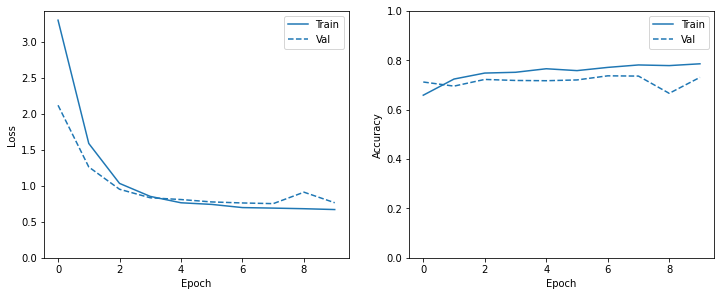

In [ ]:
model1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model1.history)
# print(model.history)

In [ ]:
prediction_prob = model1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 5ms/step
Accuracy of prediction on test set :  0.7541666666666667
              precision    recall  f1-score   support

           0       0.67      0.02      0.05        84
           1       0.74      0.93      0.83       736
           2       0.79      0.58      0.67       380

    accuracy                           0.75      1200
   macro avg       0.73      0.51      0.51      1200
weighted avg       0.75      0.75      0.72      1200



In [ ]:
model1.save('/content/gdrive/MyDrive/BSC-Project/saved_model/cnn1_avg_oov.h5')

# CNN1_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model1_1 = Model(inputs=[tweet_input], outputs=[output])
model1_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 60, 100)      1723100     ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 60, 100)      20100       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 60, 200)      60200       ['embedding_2[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model1_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 5s 33ms/step - loss: 3.1309 - accuracy: 0.6453 - val_loss: 1.9093 - val_accuracy: 0.6958
Epoch 2/10
60/60 [==============================] - 1s 11ms/step - loss: 1.4212 - accuracy: 0.7234 - val_loss: 1.0994 - val_accuracy: 0.7302
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 0.9490 - accuracy: 0.7419 - val_loss: 0.8856 - val_accuracy: 0.7573
Epoch 4/10
60/60 [==============================] - 1s 10ms/step - loss: 0.8062 - accuracy: 0.7531 - val_loss: 0.8317 - val_accuracy: 0.7177
Epoch 5/10
60/60 [==============================] - 1s 11ms/step - loss: 0.7727 - accuracy: 0.7385 - val_loss: 0.7556 - val_accuracy: 0.7417
Epoch 6/10
60/60 [==============================] - 1s 10ms/step - loss: 0.7323 - accuracy: 0.7453 - val_loss: 0.8415 - val_accuracy: 0.6906
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7027 - accuracy: 0.7661 - val_loss: 0.7426 - val_accuracy: 0.7219
Epoch 8/10
60/

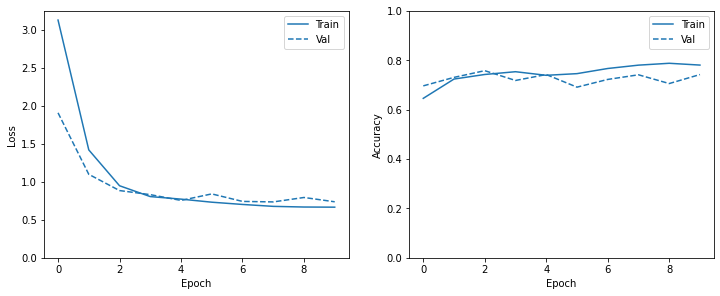

In [ ]:
model1_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model1_1.history)
# print(model.history)

In [ ]:
prediction_prob = model1_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7516666666666667
              precision    recall  f1-score   support

           0       0.56      0.12      0.20        84
           1       0.78      0.87      0.82       736
           2       0.70      0.66      0.68       380

    accuracy                           0.75      1200
   macro avg       0.68      0.55      0.57      1200
weighted avg       0.74      0.75      0.73      1200



# CNN2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(128)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model2 = Model(inputs=[tweet_input], outputs=[output])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 60, 100)      1723100     ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 60, 64)       12864       ['embedding_3[0][0]']            
                                                                                                  
 conv1d_10 (Conv1D)             (None, 60, 64)       19264       ['embedding_3[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 10ms/step - loss: 2.4946 - accuracy: 0.6266 - val_loss: 1.8000 - val_accuracy: 0.7010
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.4685 - accuracy: 0.7052 - val_loss: 1.1984 - val_accuracy: 0.7260
Epoch 3/10
60/60 [==============================] - 1s 9ms/step - loss: 1.0534 - accuracy: 0.7411 - val_loss: 0.9877 - val_accuracy: 0.7208
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8646 - accuracy: 0.7576 - val_loss: 0.8524 - val_accuracy: 0.7406
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7620 - accuracy: 0.7622 - val_loss: 0.8165 - val_accuracy: 0.7250
Epoch 6/10
60/60 [==============================] - 1s 9ms/step - loss: 0.6903 - accuracy: 0.7831 - val_loss: 0.7745 - val_accuracy: 0.7437
Epoch 7/10
60/60 [==============================] - 1s 13ms/step - loss: 0.6521 - accuracy: 0.8005 - val_loss: 0.8860 - val_accuracy: 0.7083
Epoch 8/10
60/60 [

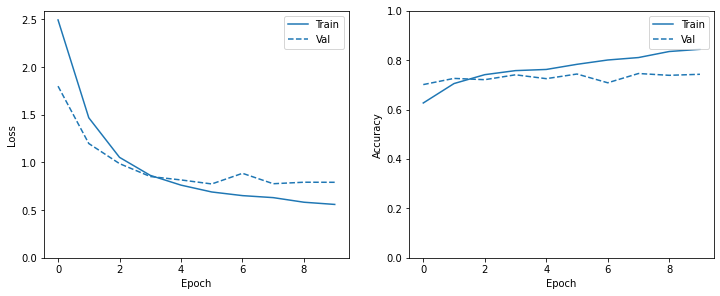

In [ ]:
model2.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model2.history)
# print(model.history)

In [ ]:
prediction_prob = model2.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 7ms/step
Accuracy of prediction on test set :  0.725
              precision    recall  f1-score   support

           0       0.32      0.12      0.17        84
           1       0.79      0.81      0.80       736
           2       0.64      0.69      0.67       380

    accuracy                           0.73      1200
   macro avg       0.58      0.54      0.55      1200
weighted avg       0.71      0.72      0.71      1200



# CNN4

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4 = Model(inputs=[tweet_input], outputs=[output])
model4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 60, 100)      1723100     ['input_6[0][0]']                
                                                                                                  
 conv1d_15 (Conv1D)             (None, 60, 64)       12864       ['embedding_5[0][0]']            
                                                                                                  
 conv1d_16 (Conv1D)             (None, 60, 32)       9632        ['embedding_5[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 9ms/step - loss: 2.1204 - accuracy: 0.6398 - val_loss: 1.7119 - val_accuracy: 0.6781
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.4691 - accuracy: 0.6995 - val_loss: 1.3285 - val_accuracy: 0.6667
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1483 - accuracy: 0.7174 - val_loss: 1.0732 - val_accuracy: 0.7052
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9583 - accuracy: 0.7404 - val_loss: 0.9462 - val_accuracy: 0.7063
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8477 - accuracy: 0.7518 - val_loss: 0.8519 - val_accuracy: 0.7250
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7744 - accuracy: 0.7563 - val_loss: 0.8137 - val_accuracy: 0.7219
Epoch 7/10
60/60 [==============================] - 41s 698ms/step - loss: 0.7267 - accuracy: 0.7695 - val_loss: 0.7674 - val_accuracy: 0.7240
Epoch 8/10
60/60 

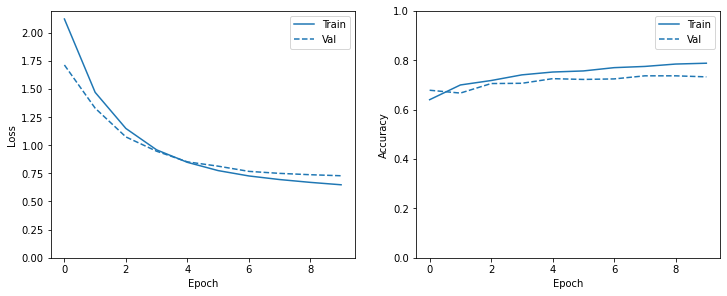

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 2.0243 - accuracy: 0.6497 - val_loss: 1.6149 - val_accuracy: 0.6938
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.3768 - accuracy: 0.7167 - val_loss: 1.1935 - val_accuracy: 0.7292
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0559 - accuracy: 0.7357 - val_loss: 0.9820 - val_accuracy: 0.7396
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8876 - accuracy: 0.7484 - val_loss: 0.8758 - val_accuracy: 0.7271
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7958 - accuracy: 0.7596 - val_loss: 0.8072 - val_accuracy: 0.7240
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7317 - accuracy: 0.7682 - val_loss: 0.7642 - val_accuracy: 0.7271
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.7714 - val_loss: 0.7434 - val_accuracy: 0.7396
Epoch 8/10
60/60 [=

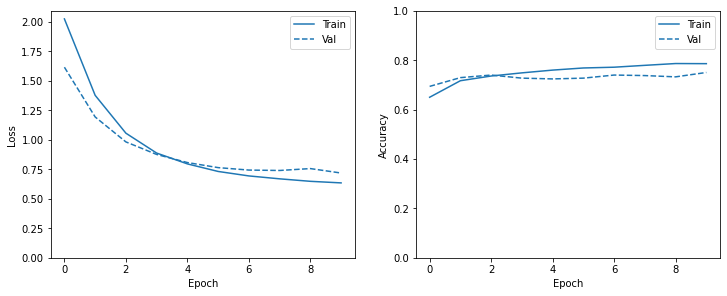

In [ ]:
model4.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4.history)
# print(model.history)

In [ ]:
prediction_prob = model4.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7475
              precision    recall  f1-score   support

           0       0.47      0.10      0.16        84
           1       0.74      0.93      0.82       736
           2       0.79      0.54      0.64       380

    accuracy                           0.75      1200
   macro avg       0.67      0.52      0.54      1200
weighted avg       0.74      0.75      0.72      1200

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7475
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        84
           1       0.75      0.89      0.82       736
           2       0.73      0.63      0.68       380

    accuracy                           0.75      1200
   macro avg       0.66      0.51      0.51      1200
weighted avg       0.73      0.75      0.72      1200



# CNN4_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4_1 = Model(inputs=[tweet_input], outputs=[output])
model4_1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 60, 100)      1723100     ['input_7[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 60, 64)       12864       ['embedding_6[0][0]']            
                                                                                                  
 conv1d_19 (Conv1D)             (None, 60, 32)       9632        ['embedding_6[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 15ms/step - loss: 1.9957 - accuracy: 0.5984 - val_loss: 1.5129 - val_accuracy: 0.6760
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.2646 - accuracy: 0.6987 - val_loss: 1.0704 - val_accuracy: 0.7052
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9536 - accuracy: 0.7198 - val_loss: 0.8788 - val_accuracy: 0.7198
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8161 - accuracy: 0.7312 - val_loss: 0.7874 - val_accuracy: 0.7323
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7398 - accuracy: 0.7458 - val_loss: 0.7491 - val_accuracy: 0.7427
Epoch 6/10
60/60 [==============================] - 1s 8ms/step - loss: 0.6984 - accuracy: 0.7549 - val_loss: 0.7275 - val_accuracy: 0.7437
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6798 - accuracy: 0.7622 - val_loss: 0.7104 - val_accuracy: 0.7333
Epoch 8/10
60/60 [=

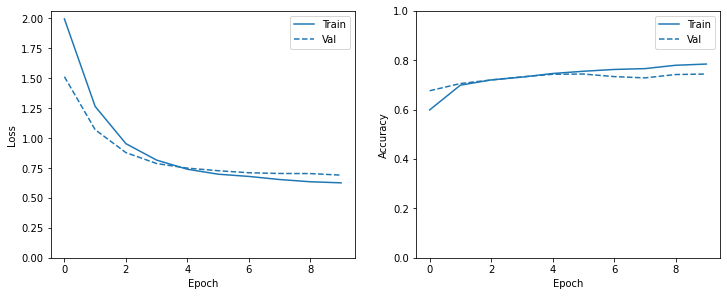

In [ ]:
model4_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4_1.history)
# print(model.history)

In [ ]:
prediction_prob = model4_1.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.745
              precision    recall  f1-score   support

           0       0.57      0.05      0.09        84
           1       0.75      0.90      0.82       736
           2       0.74      0.60      0.66       380

    accuracy                           0.74      1200
   macro avg       0.69      0.52      0.52      1200
weighted avg       0.73      0.74      0.72      1200



# CNN4_2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=16, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model4_2 = Model(inputs=[tweet_input], outputs=[output])
model4_2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 60, 100)      1723100     ['input_8[0][0]']                
                                                                                                  
 conv1d_21 (Conv1D)             (None, 60, 16)       3216        ['embedding_7[0][0]']            
                                                                                                  
 conv1d_22 (Conv1D)             (None, 60, 32)       9632        ['embedding_7[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model4_2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 1.9021 - accuracy: 0.6328 - val_loss: 1.4403 - val_accuracy: 0.7052
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.2043 - accuracy: 0.7141 - val_loss: 1.0399 - val_accuracy: 0.7167
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9166 - accuracy: 0.7359 - val_loss: 0.8679 - val_accuracy: 0.7375
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7908 - accuracy: 0.7500 - val_loss: 0.7842 - val_accuracy: 0.7302
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7269 - accuracy: 0.7622 - val_loss: 0.7491 - val_accuracy: 0.7354
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6782 - accuracy: 0.7781 - val_loss: 0.7255 - val_accuracy: 0.7354
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6568 - accuracy: 0.7789 - val_loss: 0.7338 - val_accuracy: 0.7188
Epoch 8/10
60/60 [=

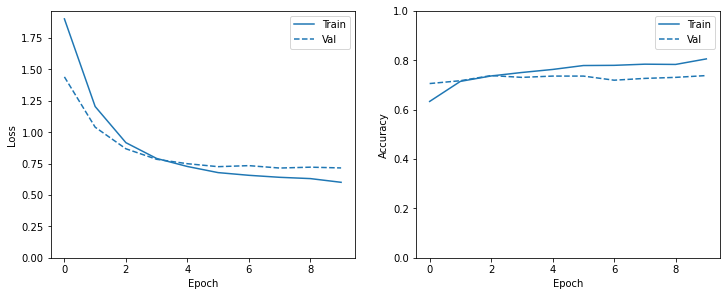

In [ ]:
model4_2.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model4_2.history)
# print(model.history)

In [ ]:
prediction_prob = model4_2.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7416666666666667
              precision    recall  f1-score   support

           0       0.55      0.07      0.13        84
           1       0.73      0.93      0.82       736
           2       0.80      0.52      0.63       380

    accuracy                           0.74      1200
   macro avg       0.69      0.51      0.52      1200
weighted avg       0.74      0.74      0.71      1200



# CNN5

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model5 = Model(inputs=[tweet_input], outputs=[output])
model5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 60, 100)      1723100     ['input_9[0][0]']                
                                                                                                  
 conv1d_24 (Conv1D)             (None, 60, 50)       10050       ['embedding_8[0][0]']            
                                                                                                  
 conv1d_25 (Conv1D)             (None, 60, 100)      30100       ['embedding_8[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model5.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 2.1341 - accuracy: 0.6195 - val_loss: 1.6514 - val_accuracy: 0.7042
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.4269 - accuracy: 0.6958 - val_loss: 1.2240 - val_accuracy: 0.7156
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1018 - accuracy: 0.7242 - val_loss: 1.0069 - val_accuracy: 0.7125
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9221 - accuracy: 0.7333 - val_loss: 0.8790 - val_accuracy: 0.7312
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8230 - accuracy: 0.7422 - val_loss: 0.8111 - val_accuracy: 0.7323
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7510 - accuracy: 0.7602 - val_loss: 0.7720 - val_accuracy: 0.7344
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7186 - accuracy: 0.7570 - val_loss: 0.7565 - val_accuracy: 0.7365
Epoch 8/10
60/60 [=

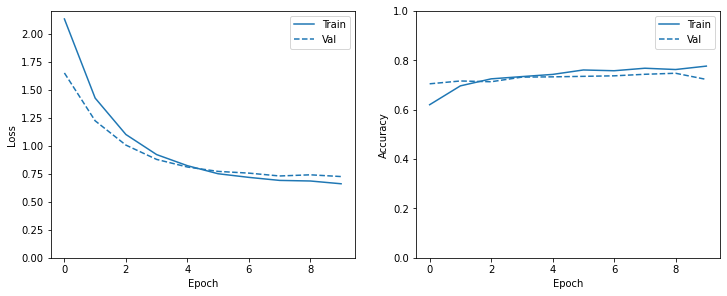

In [ ]:
model5.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model5.history)
# print(model.history)

In [ ]:
prediction_prob = model5.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.72      0.95      0.82       736
           2       0.81      0.50      0.62       380

    accuracy                           0.74      1200
   macro avg       0.51      0.48      0.48      1200
weighted avg       0.70      0.74      0.70      1200



# CNN5_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model5_1 = Model(inputs=[tweet_input], outputs=[output])
model5_1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 60, 100)      1723100     ['input_10[0][0]']               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 60, 50)       10050       ['embedding_9[0][0]']            
                                                                                                  
 conv1d_27 (Conv1D)             (None, 60, 100)      30100       ['embedding_9[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model5_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 2.0943 - accuracy: 0.6221 - val_loss: 1.6102 - val_accuracy: 0.7010
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 1.3755 - accuracy: 0.7008 - val_loss: 1.1840 - val_accuracy: 0.7021
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.0523 - accuracy: 0.7195 - val_loss: 0.9594 - val_accuracy: 0.7094
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8863 - accuracy: 0.7378 - val_loss: 0.8688 - val_accuracy: 0.7135
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7957 - accuracy: 0.7479 - val_loss: 0.7960 - val_accuracy: 0.7385
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7402 - accuracy: 0.7536 - val_loss: 0.7496 - val_accuracy: 0.7365
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7060 - accuracy: 0.7617 - val_loss: 0.7473 - val_accuracy: 0.7479
Epoch 8/10
60/60 [==

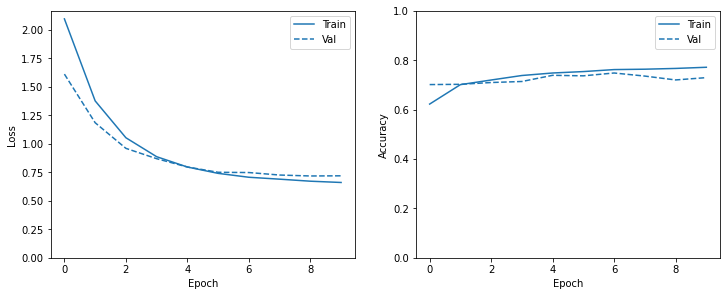

In [ ]:
model5_1.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model5_1.history)
# print(model.history)

In [ ]:
prediction_prob = model5.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.72      0.95      0.82       736
           2       0.81      0.50      0.62       380

    accuracy                           0.74      1200
   macro avg       0.51      0.48      0.48      1200
weighted avg       0.70      0.74      0.70      1200



# CNN6

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=1024, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=1024, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=1024, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model6 = Model(inputs=[tweet_input], outputs=[output])
model6.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 60, 100)      1723100     ['input_11[0][0]']               
                                                                                                  
 conv1d_28 (Conv1D)             (None, 60, 1024)     205824      ['embedding_10[0][0]']           
                                                                                                  
 conv1d_29 (Conv1D)             (None, 60, 1024)     308224      ['embedding_10[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model6.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 4s 22ms/step - loss: 3.1266 - accuracy: 0.6763 - val_loss: 1.4170 - val_accuracy: 0.6604
Epoch 2/10
60/60 [==============================] - 1s 20ms/step - loss: 1.0132 - accuracy: 0.7341 - val_loss: 0.8508 - val_accuracy: 0.7333
Epoch 3/10
60/60 [==============================] - 1s 22ms/step - loss: 0.8005 - accuracy: 0.7404 - val_loss: 0.7935 - val_accuracy: 0.7271
Epoch 4/10
60/60 [==============================] - 1s 20ms/step - loss: 0.7730 - accuracy: 0.7372 - val_loss: 0.7850 - val_accuracy: 0.7323
Epoch 5/10
60/60 [==============================] - 1s 22ms/step - loss: 0.7751 - accuracy: 0.7362 - val_loss: 0.8313 - val_accuracy: 0.7094
Epoch 6/10
60/60 [==============================] - 1s 21ms/step - loss: 0.7449 - accuracy: 0.7427 - val_loss: 0.7691 - val_accuracy: 0.7104
Epoch 7/10
60/60 [==============================] - 1s 19ms/step - loss: 0.7026 - accuracy: 0.7607 - val_loss: 0.7703 - val_accuracy: 0.7385
Epoch 8/10
60

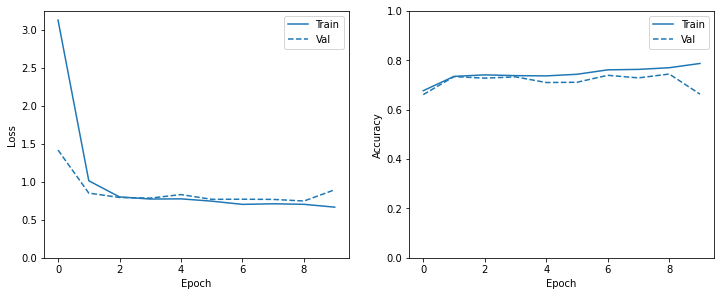

In [ ]:
model6.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model6.history)
# print(model.history)

In [ ]:
prediction_prob = model6.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 10ms/step
Accuracy of prediction on test set :  0.6808333333333333
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        84
           1       0.66      0.99      0.79       736
           2       0.92      0.22      0.36       380

    accuracy                           0.68      1200
   macro avg       0.86      0.41      0.40      1200
weighted avg       0.77      0.68      0.60      1200



# CNN7

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=17231 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=128, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=256, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model7 = Model(inputs=[tweet_input], outputs=[output])
model7.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 60, 100)      1723100     ['input_12[0][0]']               
                                                                                                  
 conv1d_31 (Conv1D)             (None, 60, 64)       12864       ['embedding_11[0][0]']           
                                                                                                  
 conv1d_32 (Conv1D)             (None, 60, 128)      38528       ['embedding_11[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model7.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 14ms/step - loss: 2.6906 - accuracy: 0.6622 - val_loss: 1.6429 - val_accuracy: 0.7323
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.2548 - accuracy: 0.7276 - val_loss: 1.0500 - val_accuracy: 0.6906
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8904 - accuracy: 0.7391 - val_loss: 0.8420 - val_accuracy: 0.7229
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7610 - accuracy: 0.7633 - val_loss: 0.7753 - val_accuracy: 0.7240
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7125 - accuracy: 0.7615 - val_loss: 0.7395 - val_accuracy: 0.7312
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6767 - accuracy: 0.7742 - val_loss: 0.7536 - val_accuracy: 0.7292
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6612 - accuracy: 0.7771 - val_loss: 0.7317 - val_accuracy: 0.7302
Epoch 8/10
60/60 [=

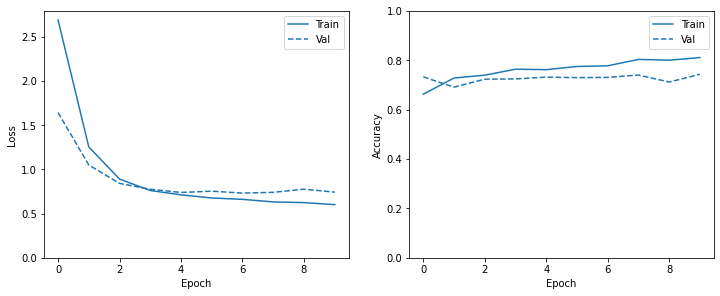

In [ ]:
model7.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model7.history)
# print(model.history)

In [ ]:
prediction_prob = model7.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.745
              precision    recall  f1-score   support

           0       0.42      0.06      0.10        84
           1       0.78      0.85      0.81       736
           2       0.69      0.68      0.69       380

    accuracy                           0.74      1200
   macro avg       0.63      0.53      0.53      1200
weighted avg       0.72      0.74      0.72      1200



# Preprocess With lowercase (Pick Test first)

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')


# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        token = token.lower()
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = token.replace("#", "").replace("_", " ")

        

        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'wb') as fp:
#         pickle.dump(X_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'wb') as fp:
#         pickle.dump(X_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data_train = []
data_test = []

In [ ]:
for x, y in zip(X_train, Y_train):
    
        data_train.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_train[:5]

[(['It',
   'had',
   'partnered',
   'with',
   'the',
   '#Russian',
   'Direct',
   'Investment',
   'Fund',
   '(',
   'RDIF',
   ')',
   'in',
   'September',
   '2020',
   'to',
   'conduct',
   'clinical',
   'trials',
   'for',
   '#SputnikV',
   '.',
   'https://t.co/TAlQlELsoR'],
  1),
 (['A',
   'batch',
   'of',
   'China-donated',
   '#Sinopharm',
   'vaccine',
   'arrived',
   'in',
   'Brazzaville',
   ',',
   'capital',
   'of',
   'the',
   'Republic',
   'of',
   '#Congo',
   ',',
   'on',
   'Wednesday',
   '.',
   'Congolese',
   'health',
   'minister',
   ',',
   'minister',
   'of',
   'foreign',
   'affairs',
   ',',
   'national',
   'defense',
   'minister',
   'and',
   'Chinese',
   'ambassador',
   'to',
   'the',
   'Congo',
   'welcomed',
   'the',
   'vaccine',
   'at',
   'the',
   'airport',
   '.',
   'https://t.co/ltF0ZZ87mx'],
  1),
 (['The',
   'Colombo',
   'Municipal',
   'Council',
   '(',
   'CMC',
   ')',
   'is',
   'to',
   'inoculate',
   '

In [ ]:
for x, y in zip(X_test, Y_test):
    
        data_test.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_test[:5]

[(['Got',
   'to',
   'admit',
   ',',
   '#Moderna',
   'second',
   'round',
   'took',
   'me',
   'for',
   'a',
   'quite',
   'a',
   'ride',
   'there',
   'overnight',
   '.',
   'They',
   'weren',
   '\x92',
   't',
   'messing',
   'around',
   'with',
   'these',
   'vaccines'],
  0),
 (['U',
   '.',
   'S',
   '.',
   '#scientists',
   'doubtful',
   'of',
   '#one-shot',
   'regimen',
   'for',
   '#Pfizer',
   ',',
   '#Moderna',
   '#COVID',
   '#vaccines',
   ':',
   '#WSJ',
   '#reuters',
   'https://t.co/jz0whryYnf',
   '#mrna',
   '#us',
   '#bidenharris',
   '#health',
   '#world',
   '#biotech',
   '#mkt'],
  1),
 (['#COVID19Vaccination',
   'coverage',
   'in',
   'India',
   'as',
   'of',
   '8',
   'AM',
   '|',
   '04.04',
   '.',
   '2021',
   'Total',
   'Beneficiaries',
   'Vaccinated',
   ':',
   '7,59',
   ',',
   '79,651',
   '27,38',
   ',',
   '972',
   'were',
   'vaccinated',
   'in',
   'last',
   '24',
   'hours',
   '.',
   'For',
   '1st',
   'D

[(['Got',
   'to',
   'admit',
   ',',
   '#Moderna',
   'second',
   'round',
   'took',
   'me',
   'for',
   'a',
   'quite',
   'a',
   'ride',
   'there',
   'overnight',
   '.',
   'They',
   'weren',
   '\x92',
   't',
   'messing',
   'around',
   'with',
   'these',
   'vaccines'],
  0),
 (['U',
   '.',
   'S',
   '.',
   '#scientists',
   'doubtful',
   'of',
   '#one-shot',
   'regimen',
   'for',
   '#Pfizer',
   ',',
   '#Moderna',
   '#COVID',
   '#vaccines',
   ':',
   '#WSJ',
   '#reuters',
   'https://t.co/jz0whryYnf',
   '#mrna',
   '#us',
   '#bidenharris',
   '#health',
   '#world',
   '#biotech',
   '#mkt'],
  1),
 (['#COVID19Vaccination',
   'coverage',
   'in',
   'India',
   'as',
   'of',
   '8',
   'AM',
   '|',
   '04.04',
   '.',
   '2021',
   'Total',
   'Beneficiaries',
   'Vaccinated',
   ':',
   '7,59',
   ',',
   '79,651',
   '27,38',
   ',',
   '972',
   'were',
   'vaccinated',
   'in',
   'last',
   '24',
   'hours',
   '.',
   'For',
   '1st',
   'D

In [ ]:
cleaned_tokens_list_train = []

# Removing noise from all the data
for tokens, label in data_train:
    cleaned_tokens_list_train.append((remove_noise5(tokens), label))

In [ ]:
cleaned_tokens_list_test = []

# Removing noise from all the data
for tokens, label in data_test:
    cleaned_tokens_list_test.append((remove_noise5(tokens), label))

In [ ]:
sentences_array_train = [s[0] for s in cleaned_tokens_list_train]
sentences_train = []

for s in sentences_array_train :
  sentence_train = ' '.join(map(str ,s))
  sentences_train.append(sentence_train)

print(len(sentences_train))
print(sentences_train[0])
print(sentences_array_train[0])

4800
it had partnered with the russian direct investment fund rdif in september <NUMBER> to conduct clinical trials for sputnikv
['it', 'had', 'partnered', 'with', 'the', 'russian', 'direct', 'investment', 'fund', 'rdif', 'in', 'september', '<NUMBER>', 'to', 'conduct', 'clinical', 'trials', 'for', 'sputnikv']


In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(257182, 13)

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise5(tokens))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['australia', 'to', 'manufacture', 'covid', '<NUMBER>', 'vaccine', 'and', 'give', 'it', 'to', 'the', 'citizens', 'for', 'free', 'of', 'cost', 'afp', 'quotes', 'prime', 'minister', 'covidvaccine']


In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise5(tokens))

In [ ]:

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'rb') as fp:
        cleaned_tokens_list3 = pickle.load(fp)

sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'a', 'cytokine', 'storm', 'pfizerbiontech']


In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'rb') as fp:
        cleaned_tokens_list4 = pickle.load(fp)

sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['covid', '<NUMBER>', 'denial', 'and', 'inaction', 'from', 'many', 'political', 'world', 'leaders', 'in', '<NUMBER>', 'created', 'this', 'tsunami', 'of', 'anti-vaccine', 'and', 'mask', 'the', 'refusal', 'of', 'many', 'to', 'go', 'into', 'lockdown', 'and', 'to', 'keep', 'their', 'football', 'live', 'made', 'it', 'near', 'impossible', 'to', 'stop', 'variant', 'now', "it's", 'all', 'around', 'me', 'fu', 'k', 'you', 'fox', 'propaganda']


In [ ]:
tweets_df5 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/Corona_tweets.csv' ,  encoding='latin-1')
tweets_df5.shape

(41157, 4)

In [ ]:
tweets_df5.drop(columns=["User_name" , "Time" , "Location"],inplace=True)

In [ ]:
tweets_df5 = tweets_df5.dropna()
tweets_df5.shape

(41157, 1)

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data5 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df5['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data5.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list5 = []

# Removing noise from all the data
for tokens in data5:
    cleaned_tokens_list5.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'wb') as fp:
        pickle.dump(cleaned_tokens_list5, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'rb') as fp:
        cleaned_tokens_list5 = pickle.load(fp)

sentences_array5 = [s for s in cleaned_tokens_list5]
print(sentences_array5[0])

['and', 'and']


In [ ]:
tweets_df6 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid19_tweets.csv')
tweets_df6.shape

(179108, 13)

In [ ]:
tweets_df6.drop(columns=["user_name" , "user_location" , "user_description" , "user_created" , "user_followers" , "user_friends" , "user_favourites" , "user_verified" , "date" , "hashtags" , "source" , "is_retweet"],inplace=True)

In [ ]:
tweets_df6 = tweets_df6.dropna()
tweets_df6.shape

(179108, 1)

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data6 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df6['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data6.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list6 = []

# Removing noise from all the data
for tokens in data6:
    cleaned_tokens_list6.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'wb') as fp:
        pickle.dump(cleaned_tokens_list6, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'rb') as fp:
        cleaned_tokens_list6 = pickle.load(fp)

sentences_array6 = [s for s in cleaned_tokens_list6]
print(sentences_array6[0])

['if', 'i', 'smelled', 'the', 'scent', 'of', 'hand', 'sanitizers', 'today', 'on', 'someone', 'in', 'the', 'past', 'i', 'would', 'think', 'they', 'were', 'so', 'intoxicated', 'that']


In [ ]:
tweets_df7 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/training.1600000.processed.noemoticon.csv' , encoding='latin-1')
tweets_df7.shape

(1599999, 6)

In [ ]:
tweets_df7.rename(columns={"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'text' }, inplace=True)

In [ ]:
tweets_df7.drop(columns=['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY','_TheSpecialOne_'],inplace=True)

In [ ]:
tweets_df7 = tweets_df7.dropna()
tweets_df7.shape

(1599999, 1)

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data7 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df7['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data7.append(tk.tokenize(x))

In [ ]:
cleaned_tokens_list7 = []

# Removing noise from all the data
for tokens in data7:
    cleaned_tokens_list7.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'wb') as fp:
        pickle.dump(cleaned_tokens_list7, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'rb') as fp:
        cleaned_tokens_list7 = pickle.load(fp)

sentences_array7 = [s for s in cleaned_tokens_list7]
print(sentences_array7[0])

['is', 'upset', 'that', 'he', "can't", 'update', 'his', 'facebook', 'by', 'texting', 'it', '...', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah']


In [ ]:
train_data = sentences_array_train  + sentences_array2 + sentences_array3 + sentences_array4 + sentences_array5 + sentences_array6 + sentences_array7
len(train_data)

3068427

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'wb') as fp:
        pickle.dump(train_data, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'rb') as fp:
        train_data = pickle.load(fp)

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=100  , workers=4 ,sg = 1)
w2v_model.build_vocab(train_data)

CPU times: user 2min 39s, sys: 1.87 s, total: 2min 41s
Wall time: 3min 3s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  538876


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 10)

CPU times: user 1h 27min 35s, sys: 11.5 s, total: 1h 27min 46s
Wall time: 47min 8s


(475406088, 602363780)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d_9.model")

# Embedding Matrix


In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')


# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        token = token.lower()
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = token.replace("#", "").replace("_", " ")

        

        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'wb') as fp:
#         pickle.dump(X_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'wb') as fp:
#         pickle.dump(X_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/Xtrain6', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/Xtest6', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytrain6', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytest6', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data_train = []
data_test = []

In [ ]:
for x, y in zip(X_train, Y_train):
    
        data_train.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_train[:5]

[(['It',
   'had',
   'partnered',
   'with',
   'the',
   '#Russian',
   'Direct',
   'Investment',
   'Fund',
   '(',
   'RDIF',
   ')',
   'in',
   'September',
   '2020',
   'to',
   'conduct',
   'clinical',
   'trials',
   'for',
   '#SputnikV',
   '.',
   'https://t.co/TAlQlELsoR'],
  1),
 (['A',
   'batch',
   'of',
   'China-donated',
   '#Sinopharm',
   'vaccine',
   'arrived',
   'in',
   'Brazzaville',
   ',',
   'capital',
   'of',
   'the',
   'Republic',
   'of',
   '#Congo',
   ',',
   'on',
   'Wednesday',
   '.',
   'Congolese',
   'health',
   'minister',
   ',',
   'minister',
   'of',
   'foreign',
   'affairs',
   ',',
   'national',
   'defense',
   'minister',
   'and',
   'Chinese',
   'ambassador',
   'to',
   'the',
   'Congo',
   'welcomed',
   'the',
   'vaccine',
   'at',
   'the',
   'airport',
   '.',
   'https://t.co/ltF0ZZ87mx'],
  1),
 (['The',
   'Colombo',
   'Municipal',
   'Council',
   '(',
   'CMC',
   ')',
   'is',
   'to',
   'inoculate',
   '

In [ ]:
for x, y in zip(X_test, Y_test):
    
        data_test.append((tk.tokenize(x), y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_test[:5]

[(['Got',
   'to',
   'admit',
   ',',
   '#Moderna',
   'second',
   'round',
   'took',
   'me',
   'for',
   'a',
   'quite',
   'a',
   'ride',
   'there',
   'overnight',
   '.',
   'They',
   'weren',
   '\x92',
   't',
   'messing',
   'around',
   'with',
   'these',
   'vaccines'],
  0),
 (['U',
   '.',
   'S',
   '.',
   '#scientists',
   'doubtful',
   'of',
   '#one-shot',
   'regimen',
   'for',
   '#Pfizer',
   ',',
   '#Moderna',
   '#COVID',
   '#vaccines',
   ':',
   '#WSJ',
   '#reuters',
   'https://t.co/jz0whryYnf',
   '#mrna',
   '#us',
   '#bidenharris',
   '#health',
   '#world',
   '#biotech',
   '#mkt'],
  1),
 (['#COVID19Vaccination',
   'coverage',
   'in',
   'India',
   'as',
   'of',
   '8',
   'AM',
   '|',
   '04.04',
   '.',
   '2021',
   'Total',
   'Beneficiaries',
   'Vaccinated',
   ':',
   '7,59',
   ',',
   '79,651',
   '27,38',
   ',',
   '972',
   'were',
   'vaccinated',
   'in',
   'last',
   '24',
   'hours',
   '.',
   'For',
   '1st',
   'D

In [ ]:
cleaned_tokens_list_train = []

# Removing noise from all the data
for tokens, label in data_train:
    cleaned_tokens_list_train.append((remove_noise5(tokens), label))

In [ ]:
cleaned_tokens_list_test = []

# Removing noise from all the data
for tokens, label in data_test:
    cleaned_tokens_list_test.append((remove_noise5(tokens), label))

In [ ]:
sentences_array_train = [s[0] for s in cleaned_tokens_list_train]
sentences_train = []

for s in sentences_array_train :
  sentence_train = ' '.join(map(str ,s))
  sentences_train.append(sentence_train)

print(len(sentences_train))
print(sentences_train[0])
print(sentences_array_train[0])

4800
it had partnered with the russian direct investment fund rdif in september <NUMBER> to conduct clinical trials for sputnikv
['it', 'had', 'partnered', 'with', 'the', 'russian', 'direct', 'investment', 'fund', 'rdif', 'in', 'september', '<NUMBER>', 'to', 'conduct', 'clinical', 'trials', 'for', 'sputnikv']


In [ ]:
all_train_words = []

for s in sentences_array_train:
  for w in s :
    all_train_words.append(w)

print('All train word : {}'.format(len(all_train_words)))

unique_train_word = []

for w in all_train_words:
  if w not in unique_train_word:
    unique_train_word.append(w)
    

print('unique train word : {}'.format(len(unique_train_word)))

All train word : 120561
unique train word : 12298


In [ ]:
sentences_array_test = [s[0] for s in cleaned_tokens_list_test]
sentences_test = []

for s in sentences_array_test :
  sentence_test = ' '.join(map(str ,s))
  sentences_test.append(sentence_test)

print(sentences_test[0])
print(sentences_array_test[0])

got to admit moderna second round took me for a quite a ride there overnight they weren t messing around with these vaccines
['got', 'to', 'admit', 'moderna', 'second', 'round', 'took', 'me', 'for', 'a', 'quite', 'a', 'ride', 'there', 'overnight', 'they', 'weren', 't', 'messing', 'around', 'with', 'these', 'vaccines']


In [ ]:
all_test_words = []

for s in sentences_array_test:
  for w in s :
    all_test_words.append(w)

print('All test word : {}'.format(len(all_test_words)))

unique_test_word = []

for w in all_test_words:
  if w not in unique_test_word:
    unique_test_word.append(w)

print('unique test word : {}'.format(len(unique_test_word)))

All test word : 29912
unique test word : 5283


In [ ]:
all_unique_words = []

for word in unique_train_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

for word in unique_test_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

print("Number of All unique word : {}".format(len(all_unique_words)))

Number of All unique word : 14003


In [ ]:
word_to_index = {}
i = 1

for word in all_unique_words :
  word_to_index[word] = i
  i+=1

word_to_index

{'it': 1,
 'had': 2,
 'partnered': 3,
 'with': 4,
 'the': 5,
 'russian': 6,
 'direct': 7,
 'investment': 8,
 'fund': 9,
 'rdif': 10,
 'in': 11,
 'september': 12,
 '<NUMBER>': 13,
 'to': 14,
 'conduct': 15,
 'clinical': 16,
 'trials': 17,
 'for': 18,
 'sputnikv': 19,
 'a': 20,
 'batch': 21,
 'of': 22,
 'china-donated': 23,
 'sinopharm': 24,
 'vaccine': 25,
 'arrived': 26,
 'brazzaville': 27,
 'capital': 28,
 'republic': 29,
 'congo': 30,
 'on': 31,
 'wednesday': 32,
 'congolese': 33,
 'health': 34,
 'minister': 35,
 'foreign': 36,
 'affairs': 37,
 'national': 38,
 'defense': 39,
 'and': 40,
 'chinese': 41,
 'ambassador': 42,
 'welcomed': 43,
 'at': 44,
 'airport': 45,
 'colombo': 46,
 'municipal': 47,
 'council': 48,
 'cmc': 49,
 'is': 50,
 'inoculate': 51,
 '<NUMBER>,<NUMBER>': 52,
 'nationals': 53,
 'from': 54,
 'monday': 55,
 'using': 56,
 'read': 57,
 'full': 58,
 'story': 59,
 'here': 60,
 'via': 61,
 'srilanka': 62,
 'lka': 63,
 'china': 64,
 'this': 65,
 'one': 66,
 'greatest': 6

In [ ]:
list_len_train = [len(i.split()) for i in sentences_train]
max_len_train = max(list_len_train)
print('max_len:', max_len_train)

max_len: 60


In [ ]:
list_len_test = [len(i.split()) for i in sentences_test]
max_len_test = max(list_len_test)
print('max_len:', max_len_test)

max_len: 54


In [ ]:
Y_test = np.zeros((len(cleaned_tokens_list_test), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list_test):
    tokens, label = tk_lb
    Y_test[i] = label

len(Y_test)

1200

In [ ]:
Y_train = np.zeros((len(cleaned_tokens_list_train), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list_train):
    tokens, label = tk_lb
    Y_train[i] = label

len(Y_train)

4800

In [ ]:
X_sequences_train = []
for s in sentences_array_train:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences_train.append(temp)

len(X_sequences_train)

4800

In [ ]:
X_sequences_test = []
for s in sentences_array_test:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences_test.append(temp)

len(X_sequences_test)

1200

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded_train = pad_sequences(X_sequences_train,maxlen=max_len_train ,padding='post')
X_padded_train = np.array(X_padded_train)
len(X_padded_train)

4800

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded_test = pad_sequences(X_sequences_test,maxlen=max_len_train ,padding='post')
X_padded_test = np.array(X_padded_test)
len(X_padded_test)

1200

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec9', 'wb') as fp:
#         pickle.dump(X_padded_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec9', 'wb') as fp:
#         pickle.dump(X_padded_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec9', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec9', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec9', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/XtestVec9', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec9', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec9', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_9.model")

In [ ]:
EMBEDDING_DIM=100

UNK = 0



for word  in unique_train_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
        

print('OOV Train : {}'.format(UNK))

OOV Train : 0


In [ ]:
EMBEDDING_DIM=100

UNK = 0


for word in unique_test_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
       
         
print('OOV Test: {}'.format(UNK)) 

OOV Test: 149


In [ ]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((len(word_to_index), EMBEDDING_DIM))
UNK = 0

i = 0
for word,i in word_to_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
        UNK += 1
        
        
print('Number of all unique train word = {}'.format(len(word_to_index)))       
print('Number of OOV  = {}'.format(UNK))    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix13', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

Number of all unique train word = 14003
Number of OOV  = 150
(14003, 100)
[-0.00769202  0.98039567 -0.28448108  0.11566883  0.64366978  0.13823709
  0.35232738  0.10309906 -0.07563683 -0.42463118 -0.10324331  0.00963263
 -0.52526873 -0.65844488  0.3213093  -0.93223029 -0.72362334 -0.3738364
 -0.41827187  0.02511269 -0.240383   -0.04962351  0.61925626 -0.25591755
  0.12531771 -0.90188652 -0.05673215 -0.13463369 -0.17231846 -0.83757293
 -0.0589645  -0.31872582  0.0298082  -0.35887724 -0.62930548  0.31625196
 -0.82618648 -0.38978225 -0.8786962   0.37376577  0.1559087  -0.0175184
 -0.82222027 -0.3165383  -0.24140561  0.19995178  0.09654128 -0.22353125
 -0.57585627  0.06355727  0.31192708  0.1071441  -0.36806744  0.4863548
  0.7108025  -0.48830086 -0.04212385  0.2018052  -0.26705885 -0.14232707
 -0.31157199 -0.25131571 -0.02133294  0.098519    0.86286789  0.6916939
  0.02249717  0.18580122  0.2487725  -0.00364228  0.53979635 -0.80248839
  0.73627597 -1.07884967 -0.31633392 -0.17131957 -0.34

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix13', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

# CNN1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 60, 100)      1400300     ['input_16[0][0]']               
                                                                                                  
 conv1d_43 (Conv1D)             (None, 60, 100)      20100       ['embedding_15[0][0]']           
                                                                                                  
 conv1d_44 (Conv1D)             (None, 60, 200)      60200       ['embedding_15[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 15ms/step - loss: 3.2516 - accuracy: 0.6167 - val_loss: 2.1480 - val_accuracy: 0.6313
Epoch 2/10
60/60 [==============================] - 1s 9ms/step - loss: 1.6020 - accuracy: 0.6797 - val_loss: 1.3067 - val_accuracy: 0.6594
Epoch 3/10
60/60 [==============================] - 1s 10ms/step - loss: 1.0960 - accuracy: 0.6966 - val_loss: 1.0622 - val_accuracy: 0.6792
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.9253 - accuracy: 0.7039 - val_loss: 0.9437 - val_accuracy: 0.6646
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8573 - accuracy: 0.7128 - val_loss: 0.9291 - val_accuracy: 0.6719
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8288 - accuracy: 0.7057 - val_loss: 0.9065 - val_accuracy: 0.6854
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7996 - accuracy: 0.7294 - val_loss: 0.8829 - val_accuracy: 0.6740
Epoch 8/10
60/60 [

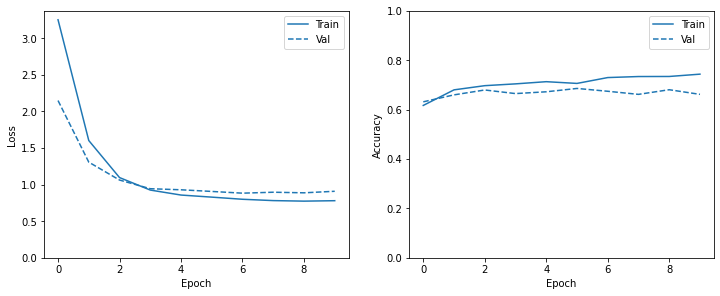

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.6825
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.67      0.96      0.79       736
           2       0.76      0.29      0.42       380

    accuracy                           0.68      1200
   macro avg       0.48      0.42      0.40      1200
weighted avg       0.65      0.68      0.62      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN1_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 60, 100)      1400300     ['input_17[0][0]']               
                                                                                                  
 conv1d_46 (Conv1D)             (None, 60, 100)      20100       ['embedding_16[0][0]']           
                                                                                                  
 conv1d_47 (Conv1D)             (None, 60, 200)      60200       ['embedding_16[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 17ms/step - loss: 3.0945 - accuracy: 0.6237 - val_loss: 1.9269 - val_accuracy: 0.6635
Epoch 2/10
60/60 [==============================] - 1s 10ms/step - loss: 1.4448 - accuracy: 0.6703 - val_loss: 1.1826 - val_accuracy: 0.6469
Epoch 3/10
60/60 [==============================] - 1s 8ms/step - loss: 1.0317 - accuracy: 0.6826 - val_loss: 1.0074 - val_accuracy: 0.6438
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8960 - accuracy: 0.6995 - val_loss: 0.9117 - val_accuracy: 0.6625
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8288 - accuracy: 0.7148 - val_loss: 0.8967 - val_accuracy: 0.6562
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8048 - accuracy: 0.7198 - val_loss: 0.8857 - val_accuracy: 0.6625
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8057 - accuracy: 0.7156 - val_loss: 0.8819 - val_accuracy: 0.6677
Epoch 8/10
60/60 [

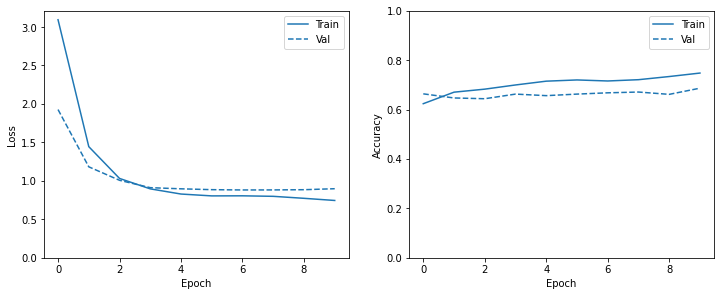

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7116666666666667
              precision    recall  f1-score   support

           0       0.17      0.01      0.02        84
           1       0.74      0.88      0.80       736
           2       0.66      0.54      0.59       380

    accuracy                           0.71      1200
   macro avg       0.52      0.48      0.47      1200
weighted avg       0.67      0.71      0.68      1200



# CNN2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(128)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 60, 100)      1400300     ['input_18[0][0]']               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 60, 64)       12864       ['embedding_17[0][0]']           
                                                                                                  
 conv1d_50 (Conv1D)             (None, 60, 64)       19264       ['embedding_17[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 2.5503 - accuracy: 0.5951 - val_loss: 1.8711 - val_accuracy: 0.6677
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.5312 - accuracy: 0.6430 - val_loss: 1.2771 - val_accuracy: 0.6385
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1196 - accuracy: 0.6732 - val_loss: 1.0456 - val_accuracy: 0.6417
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9378 - accuracy: 0.6898 - val_loss: 0.9540 - val_accuracy: 0.6698
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8375 - accuracy: 0.7185 - val_loss: 0.9425 - val_accuracy: 0.6510
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7844 - accuracy: 0.7409 - val_loss: 0.8911 - val_accuracy: 0.6833
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7361 - accuracy: 0.7609 - val_loss: 0.9236 - val_accuracy: 0.6750
Epoch 8/10
60/60 [=

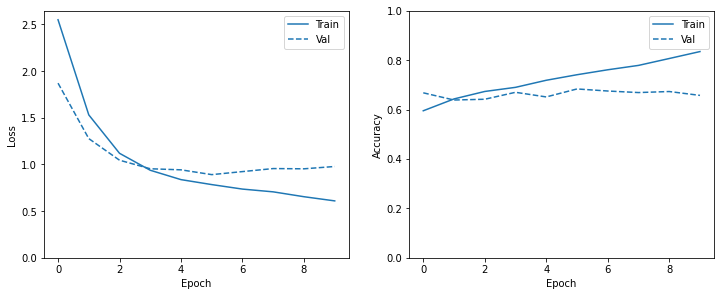

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.685
              precision    recall  f1-score   support

           0       0.19      0.06      0.09        84
           1       0.77      0.77      0.77       736
           2       0.57      0.67      0.61       380

    accuracy                           0.69      1200
   macro avg       0.51      0.50      0.49      1200
weighted avg       0.67      0.69      0.67      1200



# CNN4

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 60, 100)      1400300     ['input_19[0][0]']               
                                                                                                  
 conv1d_52 (Conv1D)             (None, 60, 64)       12864       ['embedding_18[0][0]']           
                                                                                                  
 conv1d_53 (Conv1D)             (None, 60, 32)       9632        ['embedding_18[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 2.0072 - accuracy: 0.6250 - val_loss: 1.6493 - val_accuracy: 0.6302
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.3969 - accuracy: 0.6669 - val_loss: 1.2561 - val_accuracy: 0.6531
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1028 - accuracy: 0.6766 - val_loss: 1.0765 - val_accuracy: 0.6427
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9527 - accuracy: 0.6919 - val_loss: 0.9698 - val_accuracy: 0.6698
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8733 - accuracy: 0.6953 - val_loss: 0.9111 - val_accuracy: 0.6625
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8265 - accuracy: 0.7070 - val_loss: 0.8862 - val_accuracy: 0.6771
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7907 - accuracy: 0.7130 - val_loss: 0.8740 - val_accuracy: 0.6500
Epoch 8/10
60/60 [=

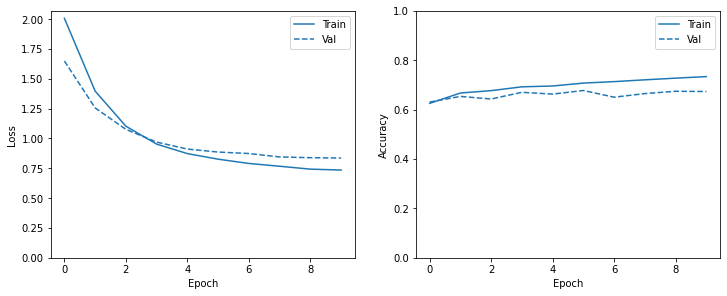

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.6958333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.70      0.93      0.79       736
           2       0.70      0.40      0.51       380

    accuracy                           0.70      1200
   macro avg       0.46      0.44      0.43      1200
weighted avg       0.65      0.70      0.65      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 60, 100)      1400300     ['input_20[0][0]']               
                                                                                                  
 conv1d_55 (Conv1D)             (None, 60, 64)       12864       ['embedding_19[0][0]']           
                                                                                                  
 conv1d_56 (Conv1D)             (None, 60, 32)       9632        ['embedding_19[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 13ms/step - loss: 1.9383 - accuracy: 0.6159 - val_loss: 1.5357 - val_accuracy: 0.6156
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.2795 - accuracy: 0.6674 - val_loss: 1.1442 - val_accuracy: 0.6396
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 1.0079 - accuracy: 0.6786 - val_loss: 0.9841 - val_accuracy: 0.6573
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8875 - accuracy: 0.6911 - val_loss: 0.9100 - val_accuracy: 0.6510
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.8283 - accuracy: 0.6982 - val_loss: 0.8886 - val_accuracy: 0.6656
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7892 - accuracy: 0.7081 - val_loss: 0.8610 - val_accuracy: 0.6604
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7693 - accuracy: 0.7201 - val_loss: 0.8555 - val_accuracy: 0.6719
Epoch 8/10
60/60 [=

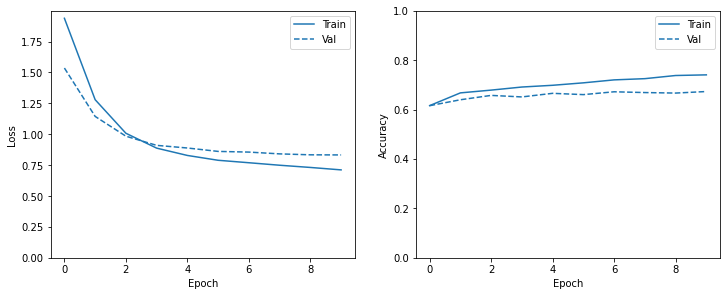

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.6975
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.69      0.95      0.80       736
           2       0.74      0.36      0.49       380

    accuracy                           0.70      1200
   macro avg       0.48      0.44      0.43      1200
weighted avg       0.66      0.70      0.64      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN4_2

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=16, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 60, 100)      1400300     ['input_21[0][0]']               
                                                                                                  
 conv1d_58 (Conv1D)             (None, 60, 16)       3216        ['embedding_20[0][0]']           
                                                                                                  
 conv1d_59 (Conv1D)             (None, 60, 32)       9632        ['embedding_20[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 7ms/step - loss: 1.9415 - accuracy: 0.6227 - val_loss: 1.5107 - val_accuracy: 0.6469
Epoch 2/10
60/60 [==============================] - 0s 4ms/step - loss: 1.2737 - accuracy: 0.6701 - val_loss: 1.1430 - val_accuracy: 0.6406
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.0019 - accuracy: 0.6836 - val_loss: 0.9840 - val_accuracy: 0.6521
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8824 - accuracy: 0.6958 - val_loss: 0.9233 - val_accuracy: 0.6458
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8256 - accuracy: 0.7008 - val_loss: 0.8799 - val_accuracy: 0.6583
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.7840 - accuracy: 0.7201 - val_loss: 0.8662 - val_accuracy: 0.6656
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7590 - accuracy: 0.7271 - val_loss: 0.8772 - val_accuracy: 0.6417
Epoch 8/10
60/60 [==

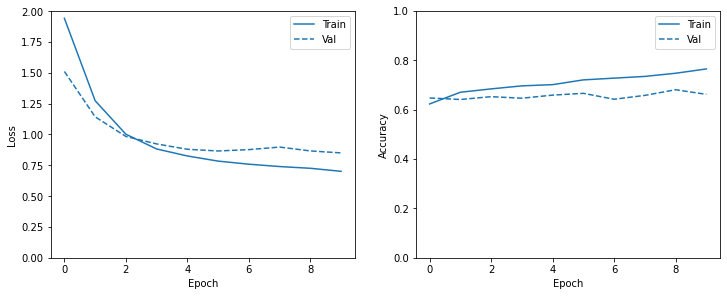

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.6791666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.68      0.92      0.79       736
           2       0.66      0.36      0.47       380

    accuracy                           0.68      1200
   macro avg       0.45      0.43      0.42      1200
weighted avg       0.63      0.68      0.63      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN5

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 60, 100)      1400300     ['input_22[0][0]']               
                                                                                                  
 conv1d_61 (Conv1D)             (None, 60, 50)       10050       ['embedding_21[0][0]']           
                                                                                                  
 conv1d_62 (Conv1D)             (None, 60, 100)      30100       ['embedding_21[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


Epoch 1/10
60/60 [==============================] - 1s 7ms/step - loss: 2.2999 - accuracy: 0.5693 - val_loss: 1.8270 - val_accuracy: 0.6417
Epoch 2/10
60/60 [==============================] - 0s 4ms/step - loss: 1.5801 - accuracy: 0.6570 - val_loss: 1.3831 - val_accuracy: 0.6458
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 1.2227 - accuracy: 0.6698 - val_loss: 1.1546 - val_accuracy: 0.6406
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - loss: 1.0382 - accuracy: 0.6836 - val_loss: 1.0196 - val_accuracy: 0.6469
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.9303 - accuracy: 0.6859 - val_loss: 0.9482 - val_accuracy: 0.6604
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8626 - accuracy: 0.6997 - val_loss: 0.9125 - val_accuracy: 0.6438
Epoch 7/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8263 - accuracy: 0.7055 - val_loss: 0.8769 - val_accuracy: 0.6604
Epoch 8/10
60/60 [==

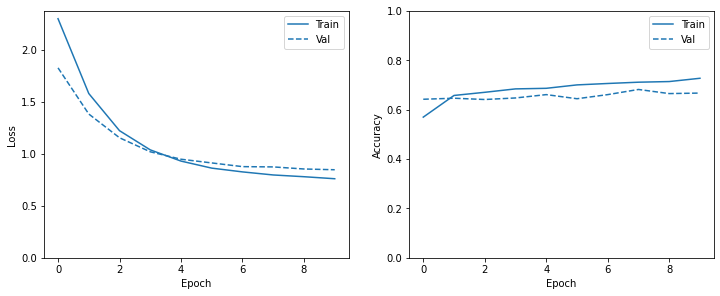

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.6908333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.69      0.94      0.79       736
           2       0.70      0.37      0.48       380

    accuracy                           0.69      1200
   macro avg       0.46      0.43      0.42      1200
weighted avg       0.64      0.69      0.64      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN5_1

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 60, 100)      1400300     ['input_23[0][0]']               
                                                                                                  
 conv1d_63 (Conv1D)             (None, 60, 50)       10050       ['embedding_22[0][0]']           
                                                                                                  
 conv1d_64 (Conv1D)             (None, 60, 100)      30100       ['embedding_22[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 7ms/step - loss: 2.2157 - accuracy: 0.5862 - val_loss: 1.7708 - val_accuracy: 0.6292
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.6560 - val_loss: 1.3439 - val_accuracy: 0.6531
Epoch 3/10
60/60 [==============================] - 0s 4ms/step - loss: 1.1910 - accuracy: 0.6732 - val_loss: 1.1423 - val_accuracy: 0.6646
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 1.0203 - accuracy: 0.6828 - val_loss: 1.0085 - val_accuracy: 0.6573
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.9138 - accuracy: 0.6927 - val_loss: 0.9418 - val_accuracy: 0.6719
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8553 - accuracy: 0.7036 - val_loss: 0.8972 - val_accuracy: 0.6646
Epoch 7/10
60/60 [==============================] - 0s 4ms/step - loss: 0.8181 - accuracy: 0.7036 - val_loss: 0.8773 - val_accuracy: 0.6510
Epoch 8/10
60/60 [==

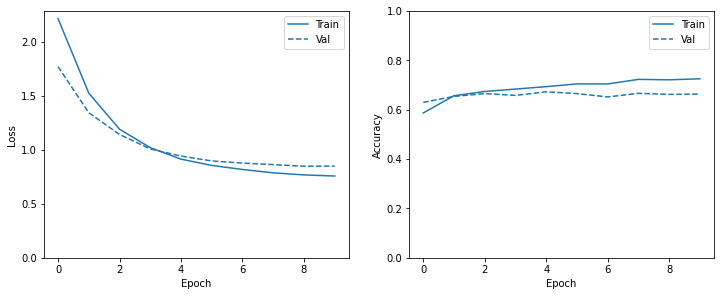

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.6933333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.69      0.93      0.79       736
           2       0.70      0.39      0.50       380

    accuracy                           0.69      1200
   macro avg       0.46      0.44      0.43      1200
weighted avg       0.65      0.69      0.64      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN6

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=1024, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=1024, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=1024, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 60, 100)      1400300     ['input_24[0][0]']               
                                                                                                  
 conv1d_65 (Conv1D)             (None, 60, 1024)     205824      ['embedding_23[0][0]']           
                                                                                                  
 conv1d_66 (Conv1D)             (None, 60, 1024)     308224      ['embedding_23[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 19ms/step - loss: 2.9940 - accuracy: 0.6401 - val_loss: 1.3856 - val_accuracy: 0.6333
Epoch 2/10
60/60 [==============================] - 1s 13ms/step - loss: 1.0557 - accuracy: 0.6721 - val_loss: 0.9565 - val_accuracy: 0.6375
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 0.8858 - accuracy: 0.6865 - val_loss: 0.9067 - val_accuracy: 0.6854
Epoch 4/10
60/60 [==============================] - 1s 14ms/step - loss: 0.8525 - accuracy: 0.6953 - val_loss: 0.9062 - val_accuracy: 0.6521
Epoch 5/10
60/60 [==============================] - 1s 14ms/step - loss: 0.8533 - accuracy: 0.6930 - val_loss: 0.9050 - val_accuracy: 0.6417
Epoch 6/10
60/60 [==============================] - 1s 13ms/step - loss: 0.8195 - accuracy: 0.7172 - val_loss: 0.9389 - val_accuracy: 0.6510
Epoch 7/10
60/60 [==============================] - 1s 13ms/step - loss: 0.7999 - accuracy: 0.7273 - val_loss: 0.8987 - val_accuracy: 0.6917
Epoch 8/10
60

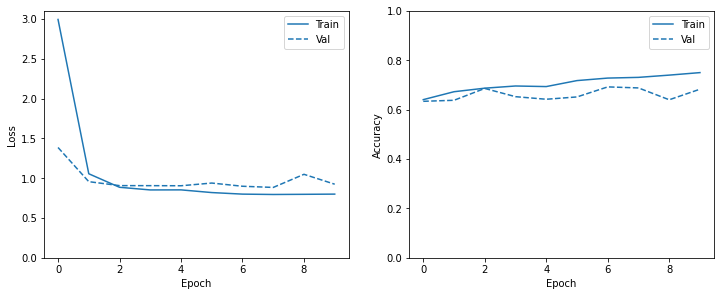

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7141666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.73      0.89      0.80       736
           2       0.66      0.54      0.59       380

    accuracy                           0.71      1200
   macro avg       0.46      0.47      0.46      1200
weighted avg       0.66      0.71      0.68      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN7

In [ ]:
tweet_input = Input(shape=(60,), dtype='int32')

tweet_encoder = Embedding(input_dim=14003 ,output_dim=100,weights=[embedding_matrix],input_length=60,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=128, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=256, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 60, 100)      1400300     ['input_25[0][0]']               
                                                                                                  
 conv1d_68 (Conv1D)             (None, 60, 64)       12864       ['embedding_24[0][0]']           
                                                                                                  
 conv1d_69 (Conv1D)             (None, 60, 128)      38528       ['embedding_24[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 2.7956 - accuracy: 0.6370 - val_loss: 1.7931 - val_accuracy: 0.6385
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.3377 - accuracy: 0.6805 - val_loss: 1.1397 - val_accuracy: 0.6698
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 0.9598 - accuracy: 0.7055 - val_loss: 0.9447 - val_accuracy: 0.6583
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8410 - accuracy: 0.7039 - val_loss: 0.8930 - val_accuracy: 0.6760
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.8027 - accuracy: 0.7169 - val_loss: 0.8693 - val_accuracy: 0.6646
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7585 - accuracy: 0.7383 - val_loss: 0.8645 - val_accuracy: 0.6719
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7419 - accuracy: 0.7500 - val_loss: 0.9140 - val_accuracy: 0.6469
Epoch 8/10
60/60 [==

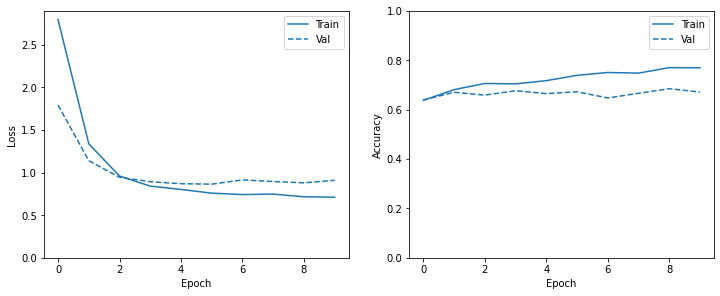

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7016666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.70      0.94      0.80       736
           2       0.72      0.40      0.52       380

    accuracy                           0.70      1200
   macro avg       0.47      0.45      0.44      1200
weighted avg       0.66      0.70      0.65      1200



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BPE

In [ ]:
pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 6.2 MB/s 


In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE())

In [ ]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train(['/content/gdrive/MyDrive/BPE_train.txt'], trainer=trainer)

In [ ]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
print(output.tokens)

['Hell', 'o, ', "y'", 'all', '! ', 'How ', 'are ', 'you', '  ', '?']


# Write data to file for learning BPE

In [ ]:
tweets_df1 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding='unicode_escape')
tweets_df1.shape

(6000, 3)

In [ ]:
tweets_df1.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.drop(columns=["tweet_id" ],inplace=True)

In [ ]:
tweets_df1 = tweets_df1.dropna()

In [ ]:
tweets_df1.head()

label                                         tweet_text
0      1  4,000 a day dying from the so called Covid-19 ...
1      2  Pranam message for today manifested in Dhyan b...
2      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3      1  Confirmation that Chinese #vaccines "dont hav...
4      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.loc[tweets_df1['label'] == 1, 'label'] = 0
tweets_df1.loc[tweets_df1['label'] == 2, 'label'] = 1
tweets_df1.loc[tweets_df1['label'] == 3, 'label'] = 2

In [ ]:
X_1 = tweets_df1['tweet_text'].tolist()

In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2.head()

user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(395683, 1)

In [ ]:
tweets_df2.head()

text
0  Australia to Manufacture Covid-19 Vaccine and ...
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...
2  Deaths due to COVID-19 in Affected Countries\n...
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...
4  @michellegrattan @ConversationEDU This is what...

In [ ]:
X_2 = tweets_df2['text'].tolist()

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

In [ ]:
tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

In [ ]:
X_3 = tweets_df3['text'].tolist()

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

In [ ]:
X_4 = tweets_df4['tweet_content'].tolist()

In [ ]:
tweets_df5 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/Corona_tweets.csv' ,  encoding='latin-1')
tweets_df5.shape

(41157, 4)

In [ ]:
tweets_df5.head()

User_name        Time   Location  \
0          1  16-03-2020     London   
1          2  16-03-2020         UK   
2          3  16-03-2020  Vagabonds   
3          4  16-03-2020        NaN   
4          5  16-03-2020        NaN   

                                                text  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...  
1  advice Talk to your neighbours family to excha...  
2  Coronavirus Australia: Woolworths to give elde...  
3  My food stock is not the only one which is emp...  
4  Me, ready to go at supermarket during the #COV...

In [ ]:
tweets_df5.drop(columns=["User_name" , "Time" , "Location"],inplace=True)

In [ ]:
tweets_df5 = tweets_df5.dropna()
tweets_df5.shape

(41157, 1)

In [ ]:
tweets_df5.head()

text
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1  advice Talk to your neighbours family to excha...
2  Coronavirus Australia: Woolworths to give elde...
3  My food stock is not the only one which is emp...
4  Me, ready to go at supermarket during the #COV...

In [ ]:
X_5 = tweets_df5['text'].tolist()

In [ ]:
tweets_df6 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid19_tweets.csv')
tweets_df6.shape

(179108, 13)

In [ ]:
tweets_df6.head()

user_name         user_location  \
0           ᏉᎥ☻լꂅϮ            astroworld   
1    Tom Basile 🇺🇸          New York, NY   
2  Time4fisticuffs      Pewee Valley, KY   
3      ethel mertz  Stuck in the Middle    
4         DIPR-J&K     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified  \
0             624           950            18775          False   
1            2253          1677               24           True   
2            9275          9525             7254          False   
3             197           987             1488          False   
4          101009           168              101          False   

                  date                                               text  \
0  2020-07-25 12:27:21  If I smelled the scent of hand sanitizers toda...   
1  2020-07-25 12:27:17  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  2020-07-25 12:27:14  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  2020-07-25 12:27:10  @brookbanktv The one gift #COVID19 has give me...   
4  2020-07-25 12:27:08  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  
0                                NaN   Twitter for iPhone       False  
1                                NaN  Twitter for Android       False  
2                        ['COVID19']  Twitter for Android       False  
3                        ['COVID19']   Twitter for iPhone       False  
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False

In [ ]:
tweets_df6.drop(columns=["user_name" , "user_location" , "user_description" , "user_created" , "user_followers" , "user_friends" , "user_favourites" , "user_verified" , "date" , "hashtags" , "source" , "is_retweet"],inplace=True)

In [ ]:
tweets_df6 = tweets_df6.dropna()
tweets_df6.shape

(179108, 1)

In [ ]:
tweets_df6.head()

text
0  If I smelled the scent of hand sanitizers toda...
1  Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2  @diane3443 @wdunlap @realDonaldTrump Trump nev...
3  @brookbanktv The one gift #COVID19 has give me...
4  25 July : Media Bulletin on Novel #CoronaVirus...

In [ ]:
X_6 = tweets_df6['text'].tolist()

In [ ]:
tweets_df7 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/training.1600000.processed.noemoticon.csv' , encoding='latin-1')
tweets_df7.shape

(1599999, 6)

In [ ]:
tweets_df7.rename(columns={"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'text' }, inplace=True)

In [ ]:
tweets_df7.drop(columns=['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY','_TheSpecialOne_'],inplace=True)

In [ ]:
tweets_df7 = tweets_df7.dropna()
tweets_df7.shape

(1599999, 1)

In [ ]:
tweets_df7.head()

text
0  is upset that he can't update his Facebook by ...
1  @Kenichan I dived many times for the ball. Man...
2    my whole body feels itchy and like its on fire 
3  @nationwideclass no, it's not behaving at all....
4                      @Kwesidei not the whole crew

In [ ]:
X_7 = tweets_df7['text'].tolist()

In [ ]:
BPE_train_data = X_1 

In [ ]:
with open('/content/gdrive/MyDrive/BPE_train.txt', 'w') as f:
    for line in BPE_train_data:
        f.write(f"{line}\n")

# Learn BPE

In [ ]:
pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE(min_frequency = 2))

In [ ]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer()
tokenizer.train(['/content/gdrive/MyDrive/BPE_train.txt'], trainer=trainer)

In [ ]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
print(output.tokens)

['Hell', 'o, ', "y'", 'all', '! ', 'How ', 'are ', 'you', '  ', '?']


In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')


# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = re.sub(r' ','', token)
        token = re.sub(r'\n','', token)
        token = token.replace("#", "").replace("_", " ")
        token = token.replace("\n", "")

        

        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

# Load dataset1

In [ ]:
tweets_df1 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding='unicode_escape')
tweets_df1.shape

(6000, 3)

In [ ]:
tweets_df1.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.drop(columns=["tweet_id" ],inplace=True)

In [ ]:
tweets_df1 = tweets_df1.dropna()

In [ ]:
tweets_df1.head()

label                                         tweet_text
0      1  4,000 a day dying from the so called Covid-19 ...
1      2  Pranam message for today manifested in Dhyan b...
2      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3      1  Confirmation that Chinese #vaccines "dont hav...
4      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df1.loc[tweets_df1['label'] == 1, 'label'] = 0
tweets_df1.loc[tweets_df1['label'] == 2, 'label'] = 1
tweets_df1.loc[tweets_df1['label'] == 3, 'label'] = 2

# Preprocess Dataset1

In [ ]:
start_time = time()



data1 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df1['tweet_text'].tolist()
Y = tweets_df1['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
        
    
        data1.append((tokenizer.encode(x).tokens, y))

In [ ]:
cleaned_tokens_list1 = []

# Removing noise from all the data
for tokens, label in data1:
    cleaned_tokens_list1.append((remove_noise5(tokens), label))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'wb') as fp:
        pickle.dump(cleaned_tokens_list1, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'rb') as fp:
        cleaned_tokens_list1 = pickle.load(fp)

sentences_array1 = [s[0] for s in cleaned_tokens_list1]
print(sentences_array1[0])

['<NUMBER>,<NUMBER>', 'aday', 'dying', 'fromthe', 'socalled', 'Covid-<NUMBER>', 'vaccine', 'aily', 'Beast', 'reports.', 'vaccine', 'PfizerVaccine', 'Moderna', '<NUMBER>nQ', 'WW', 'Z', 'pk', '<NUMBER>']


# Load dataset2

In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2.head()

user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(395683, 1)

In [ ]:
tweets_df2.head()

text
0  Australia to Manufacture Covid-19 Vaccine and ...
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...
2  Deaths due to COVID-19 in Affected Countries\n...
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...
4  @michellegrattan @ConversationEDU This is what...

In [ ]:
start_time = time()



data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise5(tokens))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['Australia', 'to', 'Man', 'ufact', 'ure', 'Covid-<NUMBER>Vaccine', 'and', 'giveit', 'tothe', 'Citizen', 'sfor', 'fre', 'eof', 'cost', 'AFP', 'quot', 'es', 'Prime', 'Minist', 'er', 'Covid', 'Vaccine']


# Load dataset3

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

# Preprocess Dataset3

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'rb') as fp:
        cleaned_tokens_list3 = pickle.load(fp)

sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['Same', 'folks', 'said', 'd', 'aik', 'on', 'past', 'e', 'could', 'tre', 'ata', 'cy', 'to', 'kine', 'stor', 'm', 'PfizerBioNTech', 'eH', 'h', 'IM', 'g', '<NUMBER>k', 'F']


# Load dataset4

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

# Preprocrss Dataset4

In [ ]:
start_time = time()


data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tokenizer.encode(x).tokens) 

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'rb') as fp:
        cleaned_tokens_list4 = pickle.load(fp)

sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['Covid-<NUMBER>', 'den', 'ial', 'and', 'in', 'action', 'from', 'many', 'political', 'World', 'lead', 'ersin', '<NUMBER>', 'c', 're', 'ated', 'this', 'ts', 'un', 'am', 'iof', 'anti-', 'vaccineand', 'mask', '.The', 'refus', 'al', 'ofman', 'yto', 'go', 'into', 'lockdown', 'and', 'tokeep', 'their', 'football', 'live', 'madeit', 'near', 'im', 'possible', 'tostop', 'variant.', 'Now', ",it's", 'all', 'around', 'me.', 'Fu', 'k', 'you', 'FO', 'X', 'propagand', 'a']


# Load Dataset5

In [ ]:
tweets_df5 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/Corona_tweets.csv' ,  encoding='latin-1')
tweets_df5.shape

(41157, 4)

In [ ]:
tweets_df5.head()

User_name        Time   Location  \
0          1  16-03-2020     London   
1          2  16-03-2020         UK   
2          3  16-03-2020  Vagabonds   
3          4  16-03-2020        NaN   
4          5  16-03-2020        NaN   

                                                text  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...  
1  advice Talk to your neighbours family to excha...  
2  Coronavirus Australia: Woolworths to give elde...  
3  My food stock is not the only one which is emp...  
4  Me, ready to go at supermarket during the #COV...

In [ ]:
tweets_df5.drop(columns=["User_name" , "Time" , "Location"],inplace=True)

In [ ]:
tweets_df5 = tweets_df5.dropna()
tweets_df5.shape

(41157, 1)

In [ ]:
tweets_df5.head()

text
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1  advice Talk to your neighbours family to excha...
2  Coronavirus Australia: Woolworths to give elde...
3  My food stock is not the only one which is emp...
4  Me, ready to go at supermarket during the #COV...

# Preprocess Dataset5

In [ ]:
start_time = time()



data5 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df5['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data5.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list5 = []

# Removing noise from all the data
for tokens in data5:
    cleaned_tokens_list5.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'wb') as fp:
        pickle.dump(cleaned_tokens_list5, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'rb') as fp:
        cleaned_tokens_list5 = pickle.load(fp)

sentences_array5 = [s for s in cleaned_tokens_list5]
print(sentences_array5[0])

['eN', 'yr', 'bi', 'e@', 'Phil', ' G', 'ah', 'an@', 'Chris', 'it', 'v', 'iF', 'z<NUMBER>', 'F', 'An', '<NUMBER>', 'P', 'aand', 'X', '<NUMBER>', 'gh', 'G', 'F', 'z', 'CC', 'and', 'I<NUMBER>', 'Nl', 'zd', 'x', 'No', '<NUMBER>']


# Load Dataset6

In [ ]:
tweets_df6 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid19_tweets.csv')
tweets_df6.shape

(179108, 13)

In [ ]:
tweets_df6.head()

user_name         user_location  \
0           ᏉᎥ☻լꂅϮ            astroworld   
1    Tom Basile 🇺🇸          New York, NY   
2  Time4fisticuffs      Pewee Valley, KY   
3      ethel mertz  Stuck in the Middle    
4         DIPR-J&K     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified  \
0             624           950            18775          False   
1            2253          1677               24           True   
2            9275          9525             7254          False   
3             197           987             1488          False   
4          101009           168              101          False   

                  date                                               text  \
0  2020-07-25 12:27:21  If I smelled the scent of hand sanitizers toda...   
1  2020-07-25 12:27:17  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  2020-07-25 12:27:14  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  2020-07-25 12:27:10  @brookbanktv The one gift #COVID19 has give me...   
4  2020-07-25 12:27:08  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  
0                                NaN   Twitter for iPhone       False  
1                                NaN  Twitter for Android       False  
2                        ['COVID19']  Twitter for Android       False  
3                        ['COVID19']   Twitter for iPhone       False  
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False

In [ ]:
tweets_df6.drop(columns=["user_name" , "user_location" , "user_description" , "user_created" , "user_followers" , "user_friends" , "user_favourites" , "user_verified" , "date" , "hashtags" , "source" , "is_retweet"],inplace=True)

In [ ]:
tweets_df6 = tweets_df6.dropna()
tweets_df6.shape

(179108, 1)

In [ ]:
tweets_df6.head()

text
0  If I smelled the scent of hand sanitizers toda...
1  Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2  @diane3443 @wdunlap @realDonaldTrump Trump nev...
3  @brookbanktv The one gift #COVID19 has give me...
4  25 July : Media Bulletin on Novel #CoronaVirus...

# Preprocess Dataset6

In [ ]:
start_time = time()



data6 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df6['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data6.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list6 = []

# Removing noise from all the data
for tokens in data6:
    cleaned_tokens_list6.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'wb') as fp:
        pickle.dump(cleaned_tokens_list6, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'rb') as fp:
        cleaned_tokens_list6 = pickle.load(fp)

sentences_array6 = [s for s in cleaned_tokens_list6]
print(sentences_array6[0])

['If', 'I', 'sm', 'ell', 'edthe', 'sc', 'ent', 'of', 'hand', 'san', 'itiz', 'ers', 'today', 'on', 'someone', 'inthe', 'past', ',Iwould', 'think', 'theywere', 'so', 'into', 'x', 'ic', 'ated', 'that', 'Z', 'vY', 'br', 'O', 'gb', '<NUMBER>']


# Load Dataset7

In [ ]:
tweets_df7 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/training.1600000.processed.noemoticon.csv' , encoding='latin-1')
tweets_df7.shape

(1599999, 6)

In [ ]:
tweets_df7.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [ ]:
tweets_df7.rename(columns={"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'text' }, inplace=True)

In [ ]:
tweets_df7.drop(columns=['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY','_TheSpecialOne_'],inplace=True)

In [ ]:
tweets_df7 = tweets_df7.dropna()
tweets_df7.shape

(1599999, 1)

In [ ]:
tweets_df7.head()

text
0  is upset that he can't update his Facebook by ...
1  @Kenichan I dived many times for the ball. Man...
2    my whole body feels itchy and like its on fire 
3  @nationwideclass no, it's not behaving at all....
4                      @Kwesidei not the whole crew

# Preprocess Dataset7

In [ ]:
start_time = time()



data7 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df7['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data7.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list7 = []

# Removing noise from all the data
for tokens in data7:
    cleaned_tokens_list7.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'wb') as fp:
        pickle.dump(cleaned_tokens_list7, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'rb') as fp:
        cleaned_tokens_list7 = pickle.load(fp)

sentences_array7 = [s for s in cleaned_tokens_list7]
print(sentences_array7[0])

['is', 'upset', 'thathe', "can't", 'update', 'his', 'Fac', 'ebook', 'by', 't', 'ext', 'ing', 'it.', '..', 'and', 'might', 'cr', 'y', 'asaresult', 'S', 'ch', 'ool', 'today', 'also', 'Bl', 'ah']


# Combine Dataset

In [ ]:
train_data = sentences_array1 + sentences_array2 + sentences_array3 + sentences_array4 + sentences_array7  
len(train_data)

NameError: ignored

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'wb') as fp:
        pickle.dump(train_data, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'rb') as fp:
        train_data = pickle.load(fp)

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=100  , workers=4 ,sg = 1)
w2v_model.build_vocab(train_data)

CPU times: user 19.7 s, sys: 77.7 ms, total: 19.8 s
Wall time: 20.8 s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  21060


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 10)

CPU times: user 2h 4min 47s, sys: 18 s, total: 2h 5min 5s
Wall time: 1h 6min 21s


(848553885, 907674930)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d_6.model")

# Prepare Train and Test

In [ ]:
tweets_df = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df.shape

(6000, 3)

In [ ]:
tweets_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df.drop(columns=["tweet_id"],inplace=True)

In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.loc[tweets_df['label'] == 1, 'label'] = 0
tweets_df.loc[tweets_df['label'] == 2, 'label'] = 1
tweets_df.loc[tweets_df['label'] == 3, 'label'] = 2

In [ ]:
start_time = time()



data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df['tweet_text'].tolist()
Y = tweets_df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    
        data.append((tokenizer.encode(x).tokens, y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 0.5473151206970215


[(['4,000 ',
   'a day ',
   'dying ',
   'from the ',
   'so called ',
   'Covid-19 ',
   '\x93',
   'vaccine',
   '\x94',
   ' @D',
   'aily',
   'Beast ',
   'reports. #',
   'vaccine #',
   'PfizerVaccine #',
   'Moderna \n',
   '\n',
   'https://t.co/p',
   '1nQ',
   'WW',
   'Z',
   'pk',
   '4'],
  0),
 (['Pr',
   'anam',
   ' message ',
   'for ',
   'today ',
   'manif',
   'est',
   'ed in ',
   'D',
   'hy',
   'an ',
   'by @',
   'meen',
   'apr',
   'anam',
   ' #',
   'truth',
   ' #',
   'love #',
   'k',
   'arm',
   ' #l',
   'ight',
   ' #n',
   'ature #',
   'consc',
   'ious',
   'ness #',
   'Friday',
   'Though',
   'ts #',
   'friday',
   'morning',
   ' #CoronavirusIndia',
   ' #COVID19India #',
   '?????_',
   '????????',
   ' #nav',
   'rat',
   'ri',
   ' #',
   'Than',
   'e #',
   'AmbedkarJayanti',
   '2021',
   ' #Modi',
   'Ji',
   ' #NarendraModi',
   ' #SecondCOVIDWave #',
   'Covaxin ',
   'https://t.co/b',
   'Q',
   'No',
   'MV',
   'ow',
   'J',


In [ ]:
cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise5(tokens), label))

In [ ]:
sentences_array = [s[0] for s in cleaned_tokens_list]
sentences = []

for s in sentences_array :
  sentence = ' '.join(map(str ,s))
  sentences.append(sentence)

print(sentences[0])
print(sentences_array[0])

<NUMBER>,<NUMBER> aday dying fromthe socalled Covid-<NUMBER> vaccine aily Beast reports. vaccine PfizerVaccine Moderna <NUMBER>nQ WW Z pk <NUMBER>
['<NUMBER>,<NUMBER>', 'aday', 'dying', 'fromthe', 'socalled', 'Covid-<NUMBER>', 'vaccine', 'aily', 'Beast', 'reports.', 'vaccine', 'PfizerVaccine', 'Moderna', '<NUMBER>nQ', 'WW', 'Z', 'pk', '<NUMBER>']


In [ ]:
all_train_words = []

for s in sentences_array:
  for w in s :
    all_train_words.append(w)

print('All train word : {}'.format(len(all_train_words)))

unique_train_word = []

for w in all_train_words:
  if w not in unique_train_word:
    unique_train_word.append(w)
    

print('unique train word : {}'.format(len(unique_train_word)))

All train word : 174384
unique train word : 19818


In [ ]:
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

max_len: 261


In [ ]:
Y = np.zeros((len(cleaned_tokens_list), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    Y[i] = label

In [ ]:
word_to_index = {}
i = 1

for word in unique_train_word :
  word_to_index[word] = i
  i+=1

word_to_index

{'<NUMBER>,<NUMBER>': 1,
 'aday': 2,
 'dying': 3,
 'fromthe': 4,
 'socalled': 5,
 'Covid-<NUMBER>': 6,
 'vaccine': 7,
 'aily': 8,
 'Beast': 9,
 'reports.': 10,
 'PfizerVaccine': 11,
 'Moderna': 12,
 '<NUMBER>nQ': 13,
 'WW': 14,
 'Z': 15,
 'pk': 16,
 '<NUMBER>': 17,
 'Pr': 18,
 'anam': 19,
 'message': 20,
 'for': 21,
 'today': 22,
 'manif': 23,
 'est': 24,
 'edin': 25,
 'D': 26,
 'hy': 27,
 'an': 28,
 'by@': 29,
 'meen': 30,
 'apr': 31,
 'truth': 32,
 'love': 33,
 'k': 34,
 'arm': 35,
 'l': 36,
 'ight': 37,
 'n': 38,
 'ature': 39,
 'consc': 40,
 'ious': 41,
 'ness': 42,
 'Friday': 43,
 'Though': 44,
 'ts': 45,
 'friday': 46,
 'morning': 47,
 'CoronavirusIndia': 48,
 'COVID<NUMBER>India': 49,
 '????? ': 50,
 '????????': 51,
 'nav': 52,
 'rat': 53,
 'ri': 54,
 'Than': 55,
 'e': 56,
 'AmbedkarJayanti': 57,
 'Modi': 58,
 'Ji': 59,
 'NarendraModi': 60,
 'SecondCOVIDWave': 61,
 'Covaxin': 62,
 'Q': 63,
 'No': 64,
 'MV': 65,
 'ow': 66,
 'J': 67,
 'g': 68,
 'Hyderabad': 69,
 '-based': 70,
 'has

In [ ]:
X_sequences = []
for s in sentences_array:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences.append(temp)

len(X_sequences)

6000

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X_sequences,maxlen=max_len ,padding='post')
X_padded = np.array(X_padded)
X_padded[2]

array([69, 70, 71, 72, 73, 74,  4, 75, 76, 77, 78, 79, 62, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 17,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train.shape)
print(Y_train.shape)

(4800, 261)
(4800,)


In [ ]:
# Python program to store list to file using pickle module
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec7', 'wb') as fp:
        pickle.dump(X_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtestVec7', 'wb') as fp:
        pickle.dump(X_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec7', 'wb') as fp:
        pickle.dump(Y_train, fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec7', 'wb') as fp:
        pickle.dump(Y_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec7', 'rb') as fp:
#         X_train =  pickle.load(fp)
         
# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec7', 'rb') as fp:
#         X_test =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec7', 'rb') as fp:
#         Y_train =  pickle.load(fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec7', 'rb') as fp:
#         Y_test =  pickle.load(fp)

# Make Embedding Matrix

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_6.model")

In [ ]:
EMBEDDING_DIM=100

UNK = 0



for word  in unique_train_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
        

print('OOV Train : {}'.format(UNK))

OOV Train : 0


In [ ]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((len(word_to_index), EMBEDDING_DIM))
UNK = 0

i = 0
for word,i in word_to_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
        UNK += 1
        
        
print('Number of all unique train word = {}'.format(len(word_to_index)))       
print('Number of OOV Train = {}'.format(UNK))    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix7', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

Number of all unique train word = 19818
Number of OOV Train = 1
(19818, 100)
[-0.08908312  0.16334854 -0.09123489 -0.02981914  0.09848608  0.12383417
  0.05658173  0.10133506  0.15346488 -0.26167163 -0.01340074  0.27565745
 -0.31300852  0.24836341 -0.04010492 -0.04615509 -0.24408989 -0.24318843
 -0.19249019 -0.49668223  0.17536193  0.20525935 -0.18968013  0.02657728
 -0.15629286 -0.28557056  0.29111123  0.15785383  0.06903618 -0.20808041
 -0.46311525 -0.1612522  -0.44740123  0.07493569  0.21669592 -0.05218735
  0.24425021 -0.0042924  -0.03222473 -0.10979236 -0.16563646  0.17228383
  0.02668992 -0.09169638  0.2008778  -0.19815104 -0.21731108 -0.39141193
 -0.00507815 -0.07536655  0.1304436  -0.06995279  0.24723583 -0.06757455
 -0.05231665 -0.15148708  0.23140186 -0.16042705 -0.16389136  0.1650382
  0.54996502  0.10715598  0.2475215  -0.31858626  0.13236748  0.19581771
 -0.07655356  0.24926074  0.05746119 -0.08915266 -0.07649639  0.08668093
  0.3363696  -0.5673489   0.11195502  0.09066422

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix7', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

# CNN1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 261)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 261, 100)     1981800     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 261, 100)     20100       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 261, 200)     60200       ['embedding[0][0]']              
                                                                                              

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 14s 29ms/step - loss: 3.1388 - accuracy: 0.6318 - val_loss: 1.8991 - val_accuracy: 0.7188
Epoch 2/10
60/60 [==============================] - 1s 20ms/step - loss: 1.4110 - accuracy: 0.7104 - val_loss: 1.1101 - val_accuracy: 0.7042
Epoch 3/10
60/60 [==============================] - 1s 20ms/step - loss: 0.9415 - accuracy: 0.7307 - val_loss: 0.8950 - val_accuracy: 0.7281
Epoch 4/10
60/60 [==============================] - 1s 18ms/step - loss: 0.8053 - accuracy: 0.7443 - val_loss: 0.8155 - val_accuracy: 0.7229
Epoch 5/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7556 - accuracy: 0.7453 - val_loss: 0.7974 - val_accuracy: 0.7271
Epoch 6/10
60/60 [==============================] - 1s 19ms/step - loss: 0.7302 - accuracy: 0.7497 - val_loss: 0.7888 - val_accuracy: 0.7188
Epoch 7/10
60/60 [==============================] - 1s 20ms/step - loss: 0.7319 - accuracy: 0.7464 - val_loss: 0.8092 - val_accuracy: 0.7000
Epoch 8/10
6

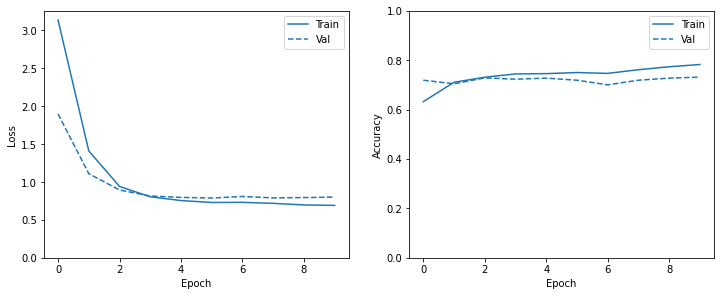

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 5ms/step
Accuracy of prediction on test set :  0.7458333333333333
              precision    recall  f1-score   support

           0       0.36      0.10      0.15        84
           1       0.78      0.87      0.82       736
           2       0.68      0.66      0.67       380

    accuracy                           0.75      1200
   macro avg       0.61      0.54      0.55      1200
weighted avg       0.72      0.75      0.73      1200



# CNN1_1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 261)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 261, 100)     1981800     ['input_3[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 261, 100)     20100       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 261, 200)     60200       ['embedding_2[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 21ms/step - loss: 3.0772 - accuracy: 0.6242 - val_loss: 1.7946 - val_accuracy: 0.7177
Epoch 2/10
60/60 [==============================] - 1s 13ms/step - loss: 1.3370 - accuracy: 0.7005 - val_loss: 1.0603 - val_accuracy: 0.6865
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 0.9119 - accuracy: 0.7203 - val_loss: 0.8729 - val_accuracy: 0.6917
Epoch 4/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7924 - accuracy: 0.7312 - val_loss: 0.7949 - val_accuracy: 0.7281
Epoch 5/10
60/60 [==============================] - 1s 15ms/step - loss: 0.7512 - accuracy: 0.7440 - val_loss: 0.7797 - val_accuracy: 0.7302
Epoch 6/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7323 - accuracy: 0.7471 - val_loss: 0.7793 - val_accuracy: 0.7167
Epoch 7/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7257 - accuracy: 0.7500 - val_loss: 0.8063 - val_accuracy: 0.7052
Epoch 8/10
60

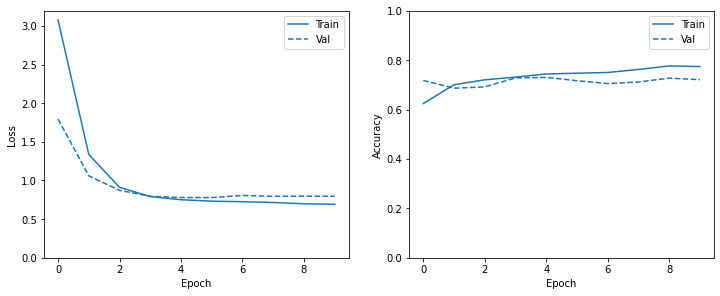

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7241666666666666
              precision    recall  f1-score   support

           0       0.38      0.10      0.15        84
           1       0.72      0.93      0.81       736
           2       0.79      0.46      0.58       380

    accuracy                           0.72      1200
   macro avg       0.63      0.50      0.51      1200
weighted avg       0.72      0.72      0.69      1200



# CNN2

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(128)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 261)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 261, 100)     1981800     ['input_5[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 261, 64)      12864       ['embedding_4[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 261, 64)      19264       ['embedding_4[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 20ms/step - loss: 2.3889 - accuracy: 0.6258 - val_loss: 1.6778 - val_accuracy: 0.6427
Epoch 2/10
60/60 [==============================] - 1s 12ms/step - loss: 1.3396 - accuracy: 0.6878 - val_loss: 1.0963 - val_accuracy: 0.6958
Epoch 3/10
60/60 [==============================] - 1s 9ms/step - loss: 0.9427 - accuracy: 0.7268 - val_loss: 0.8963 - val_accuracy: 0.7156
Epoch 4/10
60/60 [==============================] - 1s 10ms/step - loss: 0.7946 - accuracy: 0.7497 - val_loss: 0.8194 - val_accuracy: 0.7250
Epoch 5/10
60/60 [==============================] - 1s 10ms/step - loss: 0.7091 - accuracy: 0.7690 - val_loss: 0.7917 - val_accuracy: 0.7437
Epoch 6/10
60/60 [==============================] - 1s 10ms/step - loss: 0.6416 - accuracy: 0.8049 - val_loss: 0.8005 - val_accuracy: 0.7427
Epoch 7/10
60/60 [==============================] - 1s 10ms/step - loss: 0.5957 - accuracy: 0.8281 - val_loss: 0.8253 - val_accuracy: 0.7292
Epoch 8/10
60/

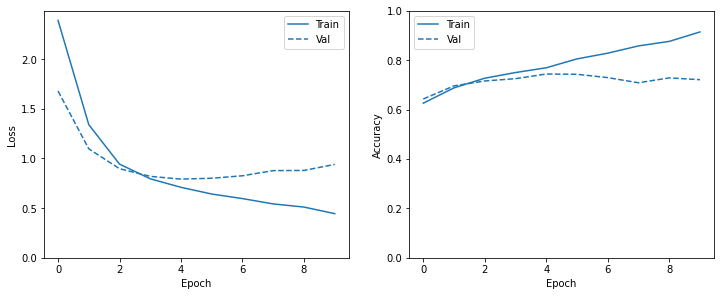

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7266666666666667
              precision    recall  f1-score   support

           0       0.50      0.14      0.22        84
           1       0.73      0.92      0.81       736
           2       0.75      0.48      0.59       380

    accuracy                           0.73      1200
   macro avg       0.66      0.51      0.54      1200
weighted avg       0.72      0.73      0.70      1200



# CNN4

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 261)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 261, 100)     1981800     ['input_6[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 261, 64)      12864       ['embedding_5[0][0]']            
                                                                                                  
 conv1d_10 (Conv1D)             (None, 261, 32)      9632        ['embedding_5[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 13ms/step - loss: 1.9597 - accuracy: 0.6313 - val_loss: 1.5433 - val_accuracy: 0.6823
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.2998 - accuracy: 0.6896 - val_loss: 1.1330 - val_accuracy: 0.6979
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9993 - accuracy: 0.7109 - val_loss: 0.9462 - val_accuracy: 0.7219
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8494 - accuracy: 0.7286 - val_loss: 0.8508 - val_accuracy: 0.7219
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7744 - accuracy: 0.7417 - val_loss: 0.7998 - val_accuracy: 0.7177
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7310 - accuracy: 0.7461 - val_loss: 0.7726 - val_accuracy: 0.7198
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7015 - accuracy: 0.7576 - val_loss: 0.7594 - val_accuracy: 0.7208
Epoch 8/10
60/60 [=

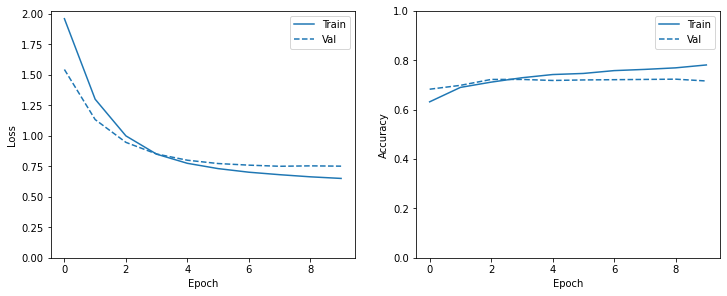

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7266666666666667
              precision    recall  f1-score   support

           0       0.37      0.12      0.18        84
           1       0.73      0.92      0.81       736
           2       0.75      0.49      0.59       380

    accuracy                           0.73      1200
   macro avg       0.62      0.51      0.53      1200
weighted avg       0.71      0.73      0.70      1200



# CNN4_1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 261)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 261, 100)     1981800     ['input_8[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 261, 64)      12864       ['embedding_7[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)             (None, 261, 32)      9632        ['embedding_7[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 14ms/step - loss: 1.8701 - accuracy: 0.6417 - val_loss: 1.4221 - val_accuracy: 0.6479
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.1851 - accuracy: 0.6833 - val_loss: 1.0233 - val_accuracy: 0.6917
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9133 - accuracy: 0.7068 - val_loss: 0.8670 - val_accuracy: 0.7146
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7951 - accuracy: 0.7232 - val_loss: 0.7988 - val_accuracy: 0.7188
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7414 - accuracy: 0.7336 - val_loss: 0.7644 - val_accuracy: 0.7198
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7108 - accuracy: 0.7372 - val_loss: 0.7525 - val_accuracy: 0.7240
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6866 - accuracy: 0.7531 - val_loss: 0.7411 - val_accuracy: 0.7240
Epoch 8/10
60/60 [=

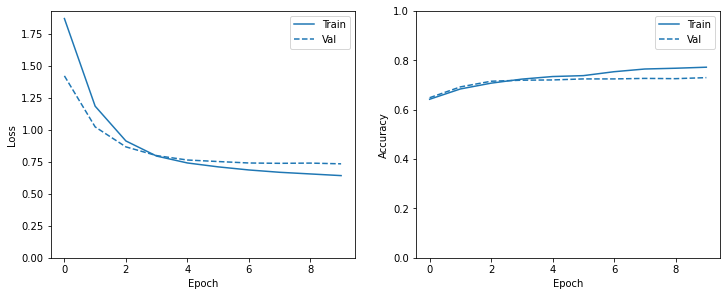

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7408333333333333
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        84
           1       0.75      0.91      0.82       736
           2       0.73      0.56      0.63       380

    accuracy                           0.74      1200
   macro avg       0.66      0.52      0.53      1200
weighted avg       0.72      0.74      0.71      1200



# CNN4_2

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=16, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 261)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 261, 100)     1981800     ['input_9[0][0]']                
                                                                                                  
 conv1d_15 (Conv1D)             (None, 261, 16)      3216        ['embedding_8[0][0]']            
                                                                                                  
 conv1d_16 (Conv1D)             (None, 261, 32)      9632        ['embedding_8[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 19ms/step - loss: 1.9371 - accuracy: 0.6138 - val_loss: 1.4344 - val_accuracy: 0.6729
Epoch 2/10
60/60 [==============================] - 1s 10ms/step - loss: 1.1942 - accuracy: 0.6862 - val_loss: 1.0283 - val_accuracy: 0.6677
Epoch 3/10
60/60 [==============================] - 1s 9ms/step - loss: 0.9086 - accuracy: 0.7154 - val_loss: 0.8622 - val_accuracy: 0.7135
Epoch 4/10
60/60 [==============================] - 1s 8ms/step - loss: 0.7892 - accuracy: 0.7263 - val_loss: 0.7937 - val_accuracy: 0.7240
Epoch 5/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7341 - accuracy: 0.7375 - val_loss: 0.7689 - val_accuracy: 0.7271
Epoch 6/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7040 - accuracy: 0.7487 - val_loss: 0.7498 - val_accuracy: 0.7260
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.6800 - accuracy: 0.7617 - val_loss: 0.7571 - val_accuracy: 0.7271
Epoch 8/10
60/60 [

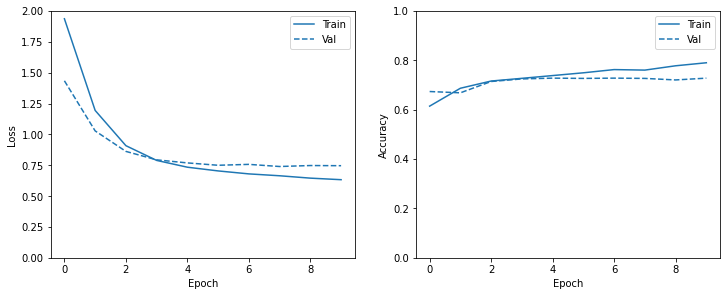

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.7333333333333333
              precision    recall  f1-score   support

           0       0.40      0.05      0.09        84
           1       0.74      0.90      0.81       736
           2       0.72      0.56      0.63       380

    accuracy                           0.73      1200
   macro avg       0.62      0.50      0.51      1200
weighted avg       0.71      0.73      0.70      1200



# CNN5

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 261, 100)     1981800     ['input_10[0][0]']               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 261, 50)      10050       ['embedding_9[0][0]']            
                                                                                                  
 conv1d_19 (Conv1D)             (None, 261, 100)     30100       ['embedding_9[0][0]']            
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 12ms/step - loss: 2.0457 - accuracy: 0.6099 - val_loss: 1.5324 - val_accuracy: 0.6771
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.3096 - accuracy: 0.6836 - val_loss: 1.1092 - val_accuracy: 0.6990
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0021 - accuracy: 0.6995 - val_loss: 0.9246 - val_accuracy: 0.7000
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8587 - accuracy: 0.7117 - val_loss: 0.8350 - val_accuracy: 0.7135
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7863 - accuracy: 0.7253 - val_loss: 0.7960 - val_accuracy: 0.7250
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7476 - accuracy: 0.7341 - val_loss: 0.7669 - val_accuracy: 0.7167
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7300 - accuracy: 0.7292 - val_loss: 0.7550 - val_accuracy: 0.7208
Epoch 8/10
60/60 [=

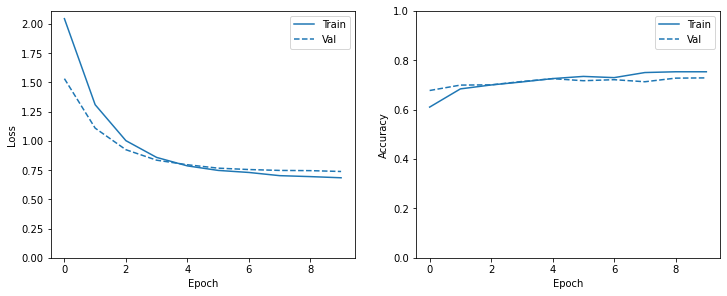

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7358333333333333
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        84
           1       0.73      0.93      0.82       736
           2       0.75      0.52      0.61       380

    accuracy                           0.74      1200
   macro avg       0.66      0.50      0.51      1200
weighted avg       0.72      0.74      0.70      1200



#CNN5_1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 261, 100)     1981800     ['input_11[0][0]']               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 261, 50)      10050       ['embedding_10[0][0]']           
                                                                                                  
 conv1d_21 (Conv1D)             (None, 261, 100)     30100       ['embedding_10[0][0]']           
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 1s 12ms/step - loss: 2.0358 - accuracy: 0.6195 - val_loss: 1.5221 - val_accuracy: 0.6896
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.2965 - accuracy: 0.6836 - val_loss: 1.1022 - val_accuracy: 0.6781
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.9931 - accuracy: 0.7018 - val_loss: 0.9167 - val_accuracy: 0.7292
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8498 - accuracy: 0.7148 - val_loss: 0.8306 - val_accuracy: 0.7188
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7854 - accuracy: 0.7229 - val_loss: 0.7867 - val_accuracy: 0.7177
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7465 - accuracy: 0.7294 - val_loss: 0.7652 - val_accuracy: 0.7167
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7260 - accuracy: 0.7307 - val_loss: 0.7545 - val_accuracy: 0.7208
Epoch 8/10
60/60 [=

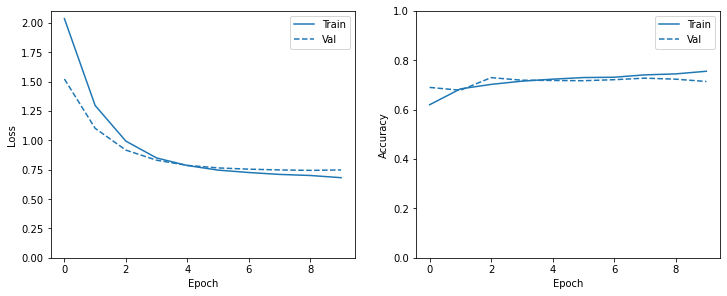

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 2ms/step
Accuracy of prediction on test set :  0.7216666666666667
              precision    recall  f1-score   support

           0       0.50      0.02      0.05        84
           1       0.71      0.94      0.81       736
           2       0.79      0.44      0.57       380

    accuracy                           0.72      1200
   macro avg       0.66      0.47      0.47      1200
weighted avg       0.72      0.72      0.68      1200



# CNN6

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=1024, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=1024, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=1024, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 261, 100)     1981800     ['input_12[0][0]']               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 261, 1024)    205824      ['embedding_11[0][0]']           
                                                                                                  
 conv1d_23 (Conv1D)             (None, 261, 1024)    308224      ['embedding_11[0][0]']           
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 5s 55ms/step - loss: 2.7479 - accuracy: 0.6461 - val_loss: 1.1071 - val_accuracy: 0.7229
Epoch 2/10
60/60 [==============================] - 3s 49ms/step - loss: 0.8967 - accuracy: 0.7206 - val_loss: 0.8275 - val_accuracy: 0.7000
Epoch 3/10
60/60 [==============================] - 3s 50ms/step - loss: 0.8077 - accuracy: 0.7172 - val_loss: 0.7985 - val_accuracy: 0.7188
Epoch 4/10
60/60 [==============================] - 3s 51ms/step - loss: 0.7819 - accuracy: 0.7206 - val_loss: 0.7890 - val_accuracy: 0.7135
Epoch 5/10
60/60 [==============================] - 3s 49ms/step - loss: 0.7986 - accuracy: 0.7234 - val_loss: 0.7923 - val_accuracy: 0.7208
Epoch 6/10
60/60 [==============================] - 3s 49ms/step - loss: 0.7638 - accuracy: 0.7391 - val_loss: 0.8058 - val_accuracy: 0.7073
Epoch 7/10
60/60 [==============================] - 3s 51ms/step - loss: 0.7640 - accuracy: 0.7401 - val_loss: 0.8098 - val_accuracy: 0.7250
Epoch 8/10
60

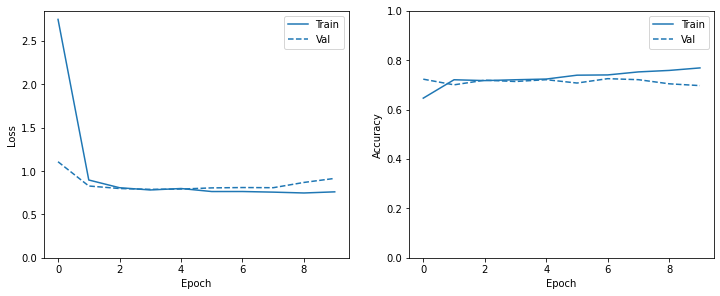

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 12ms/step
Accuracy of prediction on test set :  0.6933333333333334
              precision    recall  f1-score   support

           0       0.44      0.05      0.09        84
           1       0.67      0.98      0.80       736
           2       0.88      0.28      0.43       380

    accuracy                           0.69      1200
   macro avg       0.67      0.44      0.44      1200
weighted avg       0.72      0.69      0.63      1200



# CNN7

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=128, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=256, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 261, 100)     1981800     ['input_13[0][0]']               
                                                                                                  
 conv1d_25 (Conv1D)             (None, 261, 64)      12864       ['embedding_12[0][0]']           
                                                                                                  
 conv1d_26 (Conv1D)             (None, 261, 128)     38528       ['embedding_12[0][0]']           
                                                                                            

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 16ms/step - loss: 2.6595 - accuracy: 0.6523 - val_loss: 1.5789 - val_accuracy: 0.6771
Epoch 2/10
60/60 [==============================] - 1s 11ms/step - loss: 1.1868 - accuracy: 0.7159 - val_loss: 0.9934 - val_accuracy: 0.7000
Epoch 3/10
60/60 [==============================] - 1s 11ms/step - loss: 0.8409 - accuracy: 0.7427 - val_loss: 0.8123 - val_accuracy: 0.7240
Epoch 4/10
60/60 [==============================] - 1s 11ms/step - loss: 0.7456 - accuracy: 0.7456 - val_loss: 0.7738 - val_accuracy: 0.7281
Epoch 5/10
60/60 [==============================] - 1s 11ms/step - loss: 0.7114 - accuracy: 0.7560 - val_loss: 0.7752 - val_accuracy: 0.7260
Epoch 6/10
60/60 [==============================] - 1s 11ms/step - loss: 0.6945 - accuracy: 0.7667 - val_loss: 0.7854 - val_accuracy: 0.7063
Epoch 7/10
60/60 [==============================] - 1s 11ms/step - loss: 0.6917 - accuracy: 0.7635 - val_loss: 0.8042 - val_accuracy: 0.7094
Epoch 8/10
60

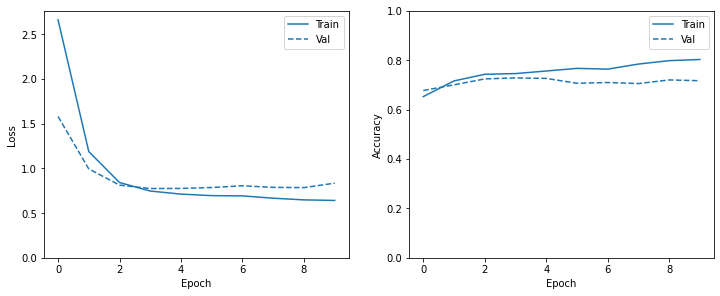

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7008333333333333
              precision    recall  f1-score   support

           0       0.33      0.21      0.26        84
           1       0.81      0.74      0.78       736
           2       0.58      0.73      0.65       380

    accuracy                           0.70      1200
   macro avg       0.58      0.56      0.56      1200
weighted avg       0.71      0.70      0.70      1200



# BPE pick test first

In [ ]:
pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE())

In [ ]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train(['/content/gdrive/MyDrive/BPE_train.txt'], trainer=trainer)

In [ ]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
print(output.tokens)

['Gy', 'next', 'xd\n', 'act', 'm ', 'itizen', 'ap', 'oron', 'vaccine #', '8']


In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')



# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words.
#       Including many minimally present cases would negatively impact the performance. 



# This function will be our all-in-one noise removal function
def remove_noise5(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        token = re.sub(r'[0-9]+', '<NUMBER>', token)
        token = re.sub(r'[^\x00-\x7F]+','', token)
        token = re.sub(r' ','', token)
        token = re.sub(r'\n','', token)
        token = token.replace("#", "").replace("_", " ")
        token = token.replace("\n", "")

        

        
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if token not in string.punctuation :
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [ ]:
tweets_df = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid-19_vaccine_tweets_with_sentiment.csv' ,encoding= 'unicode_escape')
tweets_df.shape

(6000, 3)

In [ ]:
tweets_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [ ]:
tweets_df.drop(columns=["tweet_id"],inplace=True)

In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.loc[tweets_df['label'] == 1, 'label'] = 0
tweets_df.loc[tweets_df['label'] == 2, 'label'] = 1
tweets_df.loc[tweets_df['label'] == 3, 'label'] = 2

In [ ]:
start_time = time()

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df['tweet_text'].tolist()
Y = tweets_df['label'].tolist()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train[0])
print(Y_train[0])

It had partnered with the #Russian Direct Investment Fund (RDIF) in September 2020 to conduct clinical trials for #SputnikV. https://t.co/TAlQlELsoR
1


In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/Xtrain8', 'wb') as fp:
#         pickle.dump(X_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Xtest8', 'wb') as fp:
#         pickle.dump(X_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytrain8', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Ytest8', 'wb') as fp:
#         pickle.dump(Y_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/Xtrain8', 'rb') as fp:
#         X_train =  pickle.load(fp)
         
# with open('/content/gdrive/MyDrive/BSC-Project/Xtest8', 'rb') as fp:
#         X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytrain8', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/Ytest8', 'rb') as fp:
        Y_test =  pickle.load(fp)

In [ ]:
data_train = []
data_test = []

In [ ]:
for x, y in zip(X_train, Y_train):
    
        data_train.append((tokenizer.encode(x).tokens, y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_train[:5]

[(['It ',
   'had ',
   'partner',
   'ed with ',
   'the #',
   'Russian Direct Investment Fund ',
   '(RDIF) ',
   'in Sept',
   'ember ',
   '2020 ',
   'to ',
   'conduct ',
   'clinical trials ',
   'for #SputnikV',
   '. https://t.co/T',
   'Al',
   'Ql',
   'EL',
   'so',
   'R'],
  1),
 (['A batch of China-donated #Sinopharm vaccine arrived in Brazzaville, capital of the Republic of #Congo, on Wednesday. Congolese health minister, minister of foreign affairs, national defense minister and Chinese ambassador to the Congo welcomed the vaccine at the airport. https://t.co/',
   'lt',
   'F0',
   'ZZ',
   '87',
   'mx'],
  1),
 (['The ',
   'Colomb',
   'o ',
   'Mun',
   'icip',
   'al ',
   'Council ',
   '(C',
   'MC',
   ') ',
   'is to ',
   'inoculate ',
   '4,000 ',
   'Chinese nationals ',
   'from ',
   'Monday ',
   'using the ',
   'Sinopharm vaccine. ',
   'Read the full story here ',
   '\n',
   'https://t.co/o',
   'F',
   'K0',
   'O',
   'Ih',
   'N',
   'xX',
   ' 

In [ ]:
for x, y in zip(X_test, Y_test):
    
        data_test.append((tokenizer.encode(x).tokens, y))
           
# Printing the CPU time and the first 5 elements of our 'data' list
data_test[:5]

[(['Got ',
   'to ',
   'adm',
   'it',
   ', #Moderna ',
   'second round ',
   'took ',
   'me ',
   'for a ',
   'quite ',
   'a r',
   'ide ',
   'there ',
   'overn',
   'ight. ',
   'They ',
   'weren',
   '\x92t ',
   'mess',
   'ing ',
   'around ',
   'with ',
   'these ',
   'vaccines'],
  0),
 (['U.S',
   '. #',
   'scientists doubtful ',
   'of #',
   'one-shot regimen ',
   'for #Pfizer',
   ', #Moderna',
   ' #COVID',
   ' #vaccine',
   's:',
   ' #W',
   'SJ',
   ' #re',
   'ut',
   'ers ',
   'https://t.co/j',
   'z0',
   'wh',
   'ry',
   'Y',
   'nf',
   ' #m',
   'rn',
   'a #',
   'us',
   ' #bid',
   'en',
   'har',
   'ris #',
   'health #',
   'world',
   ' #',
   'biotech',
   ' #m',
   'kt'],
  1),
 (['#COVID19Vaccination coverage in India as of 8 AM | ',
   '04.',
   '04.',
   '2021 \n',
   '\n',
   'Total Beneficiaries Vaccinated: ',
   '7,',
   '59',
   ',79',
   ',65',
   '1\n',
   '\n',
   '27',
   ',',
   '38',
   ',',
   '97',
   '2 were vaccinated in la

In [ ]:
cleaned_tokens_list_train = []

# Removing noise from all the data
for tokens, label in data_train:
    cleaned_tokens_list_train.append((remove_noise5(tokens), label))

In [ ]:
cleaned_tokens_list_test = []

# Removing noise from all the data
for tokens, label in data_test:
    cleaned_tokens_list_test.append((remove_noise5(tokens), label))

In [ ]:
sentences_array_train = [s[0] for s in cleaned_tokens_list_train]
sentences_train = []

for s in sentences_array_train :
  sentence_train = ' '.join(map(str ,s))
  sentences_train.append(sentence_train)

print(sentences_train[0])
print(sentences_array_train[0])

It had partner edwith the RussianDirectInvestmentFund (RDIF) inSept ember <NUMBER> to conduct clinicaltrials forSputnikV Al Ql EL so R
['It', 'had', 'partner', 'edwith', 'the', 'RussianDirectInvestmentFund', '(RDIF)', 'inSept', 'ember', '<NUMBER>', 'to', 'conduct', 'clinicaltrials', 'forSputnikV', 'Al', 'Ql', 'EL', 'so', 'R']


In [ ]:
all_train_words = []

for s in sentences_array_train:
  for w in s :
    all_train_words.append(w)

print('All train word : {}'.format(len(all_train_words)))

unique_train_word = []

for w in all_train_words:
  if w not in unique_train_word:
    unique_train_word.append(w)
    

print('unique train word : {}'.format(len(unique_train_word)))

All train word : 139841
unique train word : 19294


In [ ]:
sentences_array_test = [s[0] for s in cleaned_tokens_list_test]
sentences_test = []

for s in sentences_array_test :
  sentence_test = ' '.join(map(str ,s))
  sentences_test.append(sentence_test)

print(sentences_test[0])
print(sentences_array_test[0])

Got to adm it ,Moderna secondround took me fora quite ar ide there overn ight. They weren t mess ing around with these vaccines
['Got', 'to', 'adm', 'it', ',Moderna', 'secondround', 'took', 'me', 'fora', 'quite', 'ar', 'ide', 'there', 'overn', 'ight.', 'They', 'weren', 't', 'mess', 'ing', 'around', 'with', 'these', 'vaccines']


In [ ]:
all_test_words = []

for s in sentences_array_test:
  for w in s :
    all_test_words.append(w)

print('All test word : {}'.format(len(all_test_words)))

unique_test_word = []

for w in all_test_words:
  if w not in unique_test_word:
    unique_test_word.append(w)

print('unique train word : {}'.format(len(unique_test_word)))

All test word : 34543
unique train word : 11081


In [ ]:
list_len_train = [len(i) for i, j in cleaned_tokens_list_train]
max_len_train = max(list_len_train)
print('max_len:', max_len_train)

max_len: 261


In [ ]:
list_len_test = [len(i) for i, j in cleaned_tokens_list_test]
max_len_test = max(list_len_test)
print('max_len:', max_len_test)

max_len: 202


In [ ]:
Y_train = np.zeros((len(cleaned_tokens_list_train), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list_train):
    tokens, label = tk_lb
    Y_train[i] = label

In [ ]:
Y_test = np.zeros((len(cleaned_tokens_list_test), ),dtype = int)
for i, tk_lb in enumerate(cleaned_tokens_list_test):
    tokens, label = tk_lb
    Y_test[i] = label

In [ ]:
all_unique_words = []

for word in unique_train_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

for word in unique_test_word:
  if word not in all_unique_words :
    all_unique_words.append(word)

print("Number of All unique word : {}".format(len(all_unique_words)))

Number of All unique word : 19818


In [ ]:
X_sequences_train = []
for s in sentences_array_train:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences_train.append(temp)

len(X_sequences_train)

4800

In [ ]:
X_sequences_test = []
for s in sentences_array_test:
  temp = []
  for w in s :
    temp.append(word_to_index[w])
  X_sequences_test.append(temp)

len(X_sequences_test)

1200

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded_train = pad_sequences(X_sequences_train,maxlen=max_len_train ,padding='post')
X_padded_train = np.array(X_padded_train)
X_padded_train[2]

array([  974, 17575,   114,  7689,  2576,   755,  8583,  6839,    92,
       10916, 16148,     1, 18058,   238,  3056,  6462,  1691, 16968,
         407,   246,  1380, 13982,   612,  4974,  1961, 18396, 18397,
         303,    92,   106,   297,  6066,  5468,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_padded_test = pad_sequences(X_sequences_test,maxlen=max_len_train ,padding='post')
X_padded_test = np.array(X_padded_test)
X_padded_test[2]

array([10896,  1002,  1002,    17, 10897,  1323,    17,  1894,  1894,
          17,    17,    17,    17, 10898, 10899,    17,  1894,    17,
          17, 10900,  1323,    17,    17,    17,   681,  2630, 10901,
          62,    84,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
# Python program to store list to file using pickle module
import pickle

# with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec8', 'wb') as fp:
#         pickle.dump(X_padded_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/XtestVec8', 'wb') as fp:
#         pickle.dump(X_padded_test, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec8', 'wb') as fp:
#         pickle.dump(Y_train, fp)

# with open('/content/gdrive/MyDrive/BSC-Project/YtestVec8', 'wb') as fp:
#         pickle.dump(Y_test, fp)

with open('/content/gdrive/MyDrive/BSC-Project/XtrainVec8', 'rb') as fp:
        X_train =  pickle.load(fp)
         
with open('/content/gdrive/MyDrive/BSC-Project/XtestVec8', 'rb') as fp:
        X_test =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtrainVec8', 'rb') as fp:
        Y_train =  pickle.load(fp)

with open('/content/gdrive/MyDrive/BSC-Project/YtestVec8', 'rb') as fp:
        Y_test =  pickle.load(fp)

# Preprocess Dataset1

In [ ]:
data1 = []

for x, y in zip(X_train, Y_train):
    
        data1.append((tokenizer.encode(x).tokens, y))

In [ ]:
cleaned_tokens_list1 = []

# Removing noise from all the data
for tokens, label in data1:
    cleaned_tokens_list1.append((remove_noise5(tokens), label))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'wb') as fp:
        pickle.dump(cleaned_tokens_list1, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list1', 'rb') as fp:
        cleaned_tokens_list1 = pickle.load(fp)

sentences_array1 = [s[0] for s in cleaned_tokens_list1]
print(sentences_array1[0])

['It', 'had', 'partner', 'edwith', 'the', 'RussianDirectInvestmentFund', '(RDIF)', 'inSept', 'ember', '<NUMBER>', 'to', 'conduct', 'clinicaltrials', 'forSputnikV', 'Al', 'Ql', 'EL', 'so', 'R']


# Load Dataset2

In [ ]:
tweets_df2 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covidvaccine.csv')
tweets_df2.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(395731, 13)

In [ ]:
tweets_df2.head()

user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [ ]:
tweets_df2.drop(columns=["user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date"	,	"hashtags" ,	"source" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df2 = tweets_df2.dropna()
tweets_df2.shape

(395683, 1)

In [ ]:
tweets_df2.head()

text
0  Australia to Manufacture Covid-19 Vaccine and ...
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...
2  Deaths due to COVID-19 in Affected Countries\n...
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...
4  @michellegrattan @ConversationEDU This is what...

# Preprocess Dataset2

In [ ]:
start_time = time()



data2 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df2['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data2.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list2 = []

# Removing noise from all the data
for tokens in data2:
    cleaned_tokens_list2.append(remove_noise5(tokens))

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'wb') as fp:
        pickle.dump(cleaned_tokens_list2, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list2', 'rb') as fp:
        cleaned_tokens_list2 =  pickle.load(fp)

sentences_array2 = [s for s in cleaned_tokens_list2]
print(sentences_array2[0])

['Australia', 'to', 'Man', 'ufact', 'ure', 'Covid-<NUMBER>Vaccine', 'and', 'giveit', 'tothe', 'Citizen', 'sfor', 'fre', 'eof', 'cost', 'AFP', 'quot', 'es', 'Prime', 'Minist', 'er', 'Covid', 'Vaccine']


# Load Dataset3

In [ ]:
tweets_df3 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccination_all_tweets.csv')
tweets_df3.shape

(228207, 16)

In [ ]:
tweets_df3.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [ ]:
tweets_df3.drop(columns=["id" ,	"user_name" ,	"user_location" ,	"user_description" ,	"user_created" ,	"user_followers" ,	"user_friends" ,	"user_favourites" ,	"user_verified" ,	"date" , "hashtags"	 , "source" ,	"retweets" ,	"favorites" ,	"is_retweet"],inplace=True)

In [ ]:
tweets_df3 = tweets_df3.dropna()
tweets_df3.shape

(228207, 1)

In [ ]:
tweets_df3.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

# Preprocess Dataset3

In [ ]:
start_time = time()


data3 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df3['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data3.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list3 = []

# Removing noise from all the data
for tokens in data3:
    cleaned_tokens_list3.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'wb') as fp:
        pickle.dump(cleaned_tokens_list3, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list3', 'rb') as fp:
        cleaned_tokens_list3 = pickle.load(fp)

sentences_array3 = [s for s in cleaned_tokens_list3]
sentences3 = []
print(sentences_array3[0])

['Same', 'folks', 'said', 'd', 'aik', 'on', 'past', 'e', 'could', 'tre', 'ata', 'cy', 'to', 'kine', 'stor', 'm', 'PfizerBioNTech', 'eH', 'h', 'IM', 'g', '<NUMBER>k', 'F']


# Load Dataset4

In [ ]:
tweets_df4 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/vaccine_tweets.csv')
tweets_df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(861233, 19)

In [ ]:
tweets_df4.head()

username user_display_name  \
0     JosephRLeduc       _|®$€¶H 🤪🇨🇦   
1   MartinesPrisci   prisci martines   
2      SamerItani9          أبو عيسى   
3  HisLilSecretSHY         Shawnaaaa   
4        MattM5001        Steve Howe   

                                    user_description  \
0  I'm fully vaccinated and even wear a mask!\nWh...   
1                                                NaN   
2                                                NaN   
3                         IG:_SimplySW SC: Simply_SW   
4                           Awake but not Woke🇺🇸🇺🇸🇺🇸   

                 user_location user_verified user_protected  \
0                          🇨🇦          False          False   
1                un mundo raro         False          False   
2  Dubai, United Arab Emirates         False          False   
3    Me; Myselff &&' Shy ;* :)         False          False   
4         Bowleys Quarters, MD         False          False   

   user_followers_count user_friends_count user_statuses_count  \
0                4108.0               4771               21924   
1                2795.0               3538              361761   
2                  83.0                326                 409   
3                 708.0                159               49095   
4                1215.0               2741               29427   

  user_favourites_count                                      tweet_content  \
0                 22908  Covid-19 denial and inaction from many politic...   
1                 44778  Most of the World's Vaccines Likely Won't Prev...   
2                  3977  @ibn_Haile_ Vaccines, contagion, epidemics are...   
3                 15864  ..Your body is still acceptable to the virus t...   
4                111327  @DavidBaker2263 And….?   They never report the...   

  tweet_language  tweet_retweet_count  tweet_quote_count  tweet_reply_count  \
0             en                  0.0                0.0                0.0   
1             en                  0.0                0.0                0.0   
2             en                  0.0                0.0                0.0   
3             en                  0.0                0.0                0.0   
4             en                  0.0                0.0                0.0   

  tweet_like_count             tweet_id  \
0                0  1476898137860018179   
1                0  1476898058667450368   
2                0  1476898049444229121   
3                0  1476898030695686147   
4                0  1476898005282394112   

                                           tweet_url  \
0  https://twitter.com/JosephRLeduc/status/147689...   
1  https://twitter.com/MartinesPrisci/status/1476...   
2  https://twitter.com/SamerItani9/status/1476898...   
3  https://twitter.com/HisLilSecretSHY/status/147...   
4  https://twitter.com/MattM5001/status/147689800...   

                  tweet_date  
0  2021-12-31 12:48:50+00:00  
1  2021-12-31 12:48:31+00:00  
2  2021-12-31 12:48:29+00:00  
3  2021-12-31 12:48:24+00:00  
4  2021-12-31 12:48:18+00:00

In [ ]:
tweets_df4.drop(columns=["username" ,	"user_display_name" ,	"user_description" ,	"user_location" ,	"user_verified" ,	"user_protected" ,	"user_followers_count" ,	"user_friends_count" ,	"user_statuses_count" ,	"user_favourites_count" ,		"tweet_language" ,	"tweet_retweet_count" ,	"tweet_quote_count" ,	"tweet_reply_count" ,	"tweet_like_count" ,	"tweet_id" ,	"tweet_url" ,	"tweet_date"],inplace=True)

In [ ]:
tweets_df4 = tweets_df4.dropna()
tweets_df4.shape

(757974, 1)

In [ ]:
tweets_df4.head()

tweet_content
0  Covid-19 denial and inaction from many politic...
1  Most of the World's Vaccines Likely Won't Prev...
2  @ibn_Haile_ Vaccines, contagion, epidemics are...
3  ..Your body is still acceptable to the virus t...
4  @DavidBaker2263 And….?   They never report the...

# Preprocess Dataset4

In [ ]:
start_time = time()


data4 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df4['tweet_content'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data4.append(tokenizer.encode(x).tokens) 

In [ ]:
cleaned_tokens_list4 = []

# Removing noise from all the data
for tokens in data4:
    cleaned_tokens_list4.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'wb') as fp:
        pickle.dump(cleaned_tokens_list4, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list4', 'rb') as fp:
        cleaned_tokens_list4 = pickle.load(fp)

sentences_array4 = [s for s in cleaned_tokens_list4]
print(sentences_array4[0])

['Covid-<NUMBER>', 'den', 'ial', 'and', 'in', 'action', 'from', 'many', 'political', 'World', 'lead', 'ersin', '<NUMBER>', 'c', 're', 'ated', 'this', 'ts', 'un', 'am', 'iof', 'anti-', 'vaccineand', 'mask', '.The', 'refus', 'al', 'ofman', 'yto', 'go', 'into', 'lockdown', 'and', 'tokeep', 'their', 'football', 'live', 'madeit', 'near', 'im', 'possible', 'tostop', 'variant.', 'Now', ",it's", 'all', 'around', 'me.', 'Fu', 'k', 'you', 'FO', 'X', 'propagand', 'a']


# Load Dataset5

In [ ]:
tweets_df5 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/Corona_tweets.csv' ,  encoding='latin-1')
tweets_df5.shape

(41157, 4)

In [ ]:
tweets_df5.head()

In [ ]:
tweets_df5.drop(columns=["User_name" , "Time" , "Location"],inplace=True)

In [ ]:
tweets_df5 = tweets_df5.dropna()
tweets_df5.shape

(41157, 1)

In [ ]:
tweets_df5.head()

# Preprocess Dataset5

In [ ]:
start_time = time()



data5 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df5['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data5.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list5 = []

# Removing noise from all the data
for tokens in data5:
    cleaned_tokens_list5.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'wb') as fp:
        pickle.dump(cleaned_tokens_list5, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list5', 'rb') as fp:
        cleaned_tokens_list5 = pickle.load(fp)

sentences_array5 = [s for s in cleaned_tokens_list5]
print(sentences_array5[0])

['eN', 'yr', 'bi', 'e@', 'Phil', ' G', 'ah', 'an@', 'Chris', 'it', 'v', 'iF', 'z<NUMBER>', 'F', 'An', '<NUMBER>', 'P', 'aand', 'X', '<NUMBER>', 'gh', 'G', 'F', 'z', 'CC', 'and', 'I<NUMBER>', 'Nl', 'zd', 'x', 'No', '<NUMBER>']


# Load Dataset6

In [ ]:
tweets_df6 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/covid19_tweets.csv')
tweets_df6.shape

(179108, 13)

In [ ]:
tweets_df6.head()

user_name         user_location  \
0           ᏉᎥ☻լꂅϮ            astroworld   
1    Tom Basile 🇺🇸          New York, NY   
2  Time4fisticuffs      Pewee Valley, KY   
3      ethel mertz  Stuck in the Middle    
4         DIPR-J&K     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified  \
0             624           950            18775          False   
1            2253          1677               24           True   
2            9275          9525             7254          False   
3             197           987             1488          False   
4          101009           168              101          False   

                  date                                               text  \
0  2020-07-25 12:27:21  If I smelled the scent of hand sanitizers toda...   
1  2020-07-25 12:27:17  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  2020-07-25 12:27:14  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  2020-07-25 12:27:10  @brookbanktv The one gift #COVID19 has give me...   
4  2020-07-25 12:27:08  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  
0                                NaN   Twitter for iPhone       False  
1                                NaN  Twitter for Android       False  
2                        ['COVID19']  Twitter for Android       False  
3                        ['COVID19']   Twitter for iPhone       False  
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False

In [ ]:
tweets_df6.drop(columns=["user_name" , "user_location" , "user_description" , "user_created" , "user_followers" , "user_friends" , "user_favourites" , "user_verified" , "date" , "hashtags" , "source" , "is_retweet"],inplace=True)

In [ ]:
tweets_df6 = tweets_df6.dropna()
tweets_df6.shape

(179108, 1)

In [ ]:
tweets_df6.head()

text
0  If I smelled the scent of hand sanitizers toda...
1  Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2  @diane3443 @wdunlap @realDonaldTrump Trump nev...
3  @brookbanktv The one gift #COVID19 has give me...
4  25 July : Media Bulletin on Novel #CoronaVirus...

# Preprocess Dataset6

In [ ]:
start_time = time()



data6 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df6['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data6.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list6 = []

# Removing noise from all the data
for tokens in data6:
    cleaned_tokens_list6.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'wb') as fp:
        pickle.dump(cleaned_tokens_list6, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list6', 'rb') as fp:
        cleaned_tokens_list6 = pickle.load(fp)

sentences_array6 = [s for s in cleaned_tokens_list6]
print(sentences_array6[0])

['If', 'I', 'sm', 'ell', 'edthe', 'sc', 'ent', 'of', 'hand', 'san', 'itiz', 'ers', 'today', 'on', 'someone', 'inthe', 'past', ',Iwould', 'think', 'theywere', 'so', 'into', 'x', 'ic', 'ated', 'that', 'Z', 'vY', 'br', 'O', 'gb', '<NUMBER>']


# Load Dataset7

In [ ]:
tweets_df7 = pd.read_csv('/content/gdrive/MyDrive/BSC-Project/datasets/training.1600000.processed.noemoticon.csv' , encoding='latin-1')
tweets_df7.shape

(1599999, 6)

In [ ]:
tweets_df7.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [ ]:
tweets_df7.rename(columns={"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'text' }, inplace=True)

In [ ]:
tweets_df7.drop(columns=['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY','_TheSpecialOne_'],inplace=True)

In [ ]:
tweets_df7 = tweets_df7.dropna()
tweets_df7.shape

(1599999, 1)

In [ ]:
tweets_df7.head()

text
0  is upset that he can't update his Facebook by ...
1  @Kenichan I dived many times for the ball. Man...
2    my whole body feels itchy and like its on fire 
3  @nationwideclass no, it's not behaving at all....
4                      @Kwesidei not the whole crew

# Preprocess Dataset7

In [ ]:
start_time = time()



data7 = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = tweets_df7['text'].tolist()


# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x in X:
    
        data7.append(tokenizer.encode(x).tokens)

In [ ]:
cleaned_tokens_list7 = []

# Removing noise from all the data
for tokens in data7:
    cleaned_tokens_list7.append(remove_noise5(tokens))

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'wb') as fp:
        pickle.dump(cleaned_tokens_list7, fp)

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/cleaned_tokens_list7', 'rb') as fp:
        cleaned_tokens_list7 = pickle.load(fp)

sentences_array7 = [s for s in cleaned_tokens_list7]
print(sentences_array7[0])

['is', 'upset', 'thathe', "can't", 'update', 'his', 'Fac', 'ebook', 'by', 't', 'ext', 'ing', 'it.', '..', 'and', 'might', 'cr', 'y', 'asaresult', 'S', 'ch', 'ool', 'today', 'also', 'Bl', 'ah']


# Combine Datasets

In [ ]:
train_data = sentences_array1 + sentences_array2 + sentences_array3 + sentences_array4 + sentences_array7 + sentences_array5 + sentences_array6
len(train_data)

3206928

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'wb') as fp:
        pickle.dump(train_data, fp)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/BSC-Project/train_data_word2vec_1', 'rb') as fp:
        train_data = pickle.load(fp)
len(train_data)

3206928

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
%%time
w2v_model = Word2Vec(min_count=1 , window=5 , size=100  , workers=4 ,sg = 1)
w2v_model.build_vocab(train_data)

CPU times: user 39.9 s, sys: 193 ms, total: 40.1 s
Wall time: 43.7 s


In [ ]:
w2v_model_vocab_size = len(w2v_model.wv.vocab)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  21048


In [ ]:
%%time
w2v_model.train(train_data , total_examples=w2v_model.corpus_count , epochs= 10)

CPU times: user 2h 38min 58s, sys: 20.8 s, total: 2h 39min 19s
Wall time: 1h 25min 28s


(865163525, 925215760)

In [ ]:
w2v_model.save("/content/gdrive/MyDrive/BSC-Project/w2v_300d_8.model")

# Make Embedding Matrix

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("/content/gdrive/MyDrive/BSC-Project/w2v_300d_8.model")

In [ ]:
EMBEDDING_DIM=100

UNK = 0



for word  in unique_train_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
        

print('OOV Train : {}'.format(UNK))

OOV Train : 0


In [ ]:
EMBEDDING_DIM=100

UNK = 0



for word  in unique_test_word:

      try:
           embedding_vector = w2v_model.wv[word]
           
      except :
        UNK += 1
        
        

print('OOV Train : {}'.format(UNK))

OOV Train : 15


In [ ]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((len(word_to_index), EMBEDDING_DIM))
UNK = 0

i = 0
for word,i in word_to_index.items():

      try:
           embedding_vector = w2v_model.wv[word]
           embedding_matrix[i] = embedding_vector
      except :
        UNK += 1
        
        
print('Number of all unique train word = {}'.format(len(word_to_index)))   
print('Number of OOV Train = {}'.format(UNK))    
print(embedding_matrix.shape)
print(embedding_matrix[21])

with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix8', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)

Number of all unique train word = 19818
Number of OOV Train = 16
(19818, 100)
[ 0.15841304  0.24219115  0.25413918  0.26885161  0.18165147 -0.18864414
  0.32899162  0.08733886 -0.09268044 -0.13851492 -0.17150424  0.46198681
  0.02224888 -0.12989677  0.53131777 -0.02763711 -0.41997582  0.06456544
  0.00848032  0.10139763  0.45479423  0.19135351  0.22938479 -0.28638768
 -0.02870637  0.10872356  0.27538925 -0.12423959  0.05517909  0.00326273
  0.20033219  0.05474724 -0.03009627 -0.32748857 -0.13272907  0.11503194
 -0.15583886  0.09541148  0.19346713  0.22528258  0.12282783  0.0967278
 -0.15197201 -0.13927227  0.22341658  0.03686961  0.13538025  0.12105517
  0.14591923 -0.04952594  0.12584472 -0.05622749 -0.30100501 -0.17671891
  0.21150753 -0.27598408 -0.00111511 -0.12677391 -0.33485687  0.14881817
  0.05744722  0.10448055  0.01359177 -0.09316888  0.42742947 -0.00602202
  0.1622556  -0.16370782  0.21095689  0.42056814  0.09146197 -0.17184973
 -0.11321241 -0.07975315 -0.07638239 -0.0110556

In [ ]:
with open('/content/gdrive/MyDrive/BSC-Project/embedMatrix8', 'rb') as fp:
        embedding_matrix = pickle.load(fp)

# CNN1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 261, 100)     1981800     ['input_16[0][0]']               
                                                                                                  
 conv1d_34 (Conv1D)             (None, 261, 100)     20100       ['embedding_15[0][0]']           
                                                                                                  
 conv1d_35 (Conv1D)             (None, 261, 200)     60200       ['embedding_15[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 21ms/step - loss: 3.0560 - accuracy: 0.6406 - val_loss: 1.8030 - val_accuracy: 0.6885
Epoch 2/10
60/60 [==============================] - 1s 16ms/step - loss: 1.3334 - accuracy: 0.7172 - val_loss: 1.0561 - val_accuracy: 0.6990
Epoch 3/10
60/60 [==============================] - 1s 15ms/step - loss: 0.9106 - accuracy: 0.7260 - val_loss: 0.8550 - val_accuracy: 0.7146
Epoch 4/10
60/60 [==============================] - 1s 15ms/step - loss: 0.7892 - accuracy: 0.7443 - val_loss: 0.8025 - val_accuracy: 0.7229
Epoch 5/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7486 - accuracy: 0.7503 - val_loss: 0.7825 - val_accuracy: 0.7271
Epoch 6/10
60/60 [==============================] - 1s 22ms/step - loss: 0.7352 - accuracy: 0.7589 - val_loss: 0.7792 - val_accuracy: 0.7188
Epoch 7/10
60/60 [==============================] - 1s 15ms/step - loss: 0.7184 - accuracy: 0.7656 - val_loss: 0.7819 - val_accuracy: 0.7219
Epoch 8/10
60

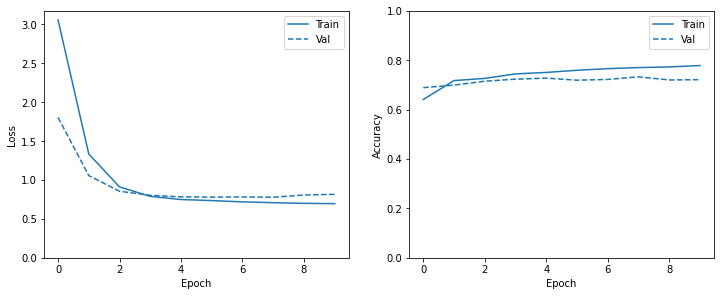

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.7158333333333333
              precision    recall  f1-score   support

           0       0.41      0.11      0.17        84
           1       0.79      0.79      0.79       736
           2       0.61      0.70      0.65       380

    accuracy                           0.72      1200
   macro avg       0.60      0.53      0.54      1200
weighted avg       0.70      0.72      0.70      1200



# CNN1_1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=200, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=300, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 261, 100)     1981800     ['input_17[0][0]']               
                                                                                                  
 conv1d_37 (Conv1D)             (None, 261, 100)     20100       ['embedding_16[0][0]']           
                                                                                                  
 conv1d_38 (Conv1D)             (None, 261, 200)     60200       ['embedding_16[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 21ms/step - loss: 3.0001 - accuracy: 0.6331 - val_loss: 1.7281 - val_accuracy: 0.6885
Epoch 2/10
60/60 [==============================] - 1s 14ms/step - loss: 1.2848 - accuracy: 0.7055 - val_loss: 1.0121 - val_accuracy: 0.7208
Epoch 3/10
60/60 [==============================] - 1s 15ms/step - loss: 0.8815 - accuracy: 0.7305 - val_loss: 0.8575 - val_accuracy: 0.7021
Epoch 4/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7758 - accuracy: 0.7357 - val_loss: 0.7897 - val_accuracy: 0.7365
Epoch 5/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7419 - accuracy: 0.7464 - val_loss: 0.7815 - val_accuracy: 0.7208
Epoch 6/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7283 - accuracy: 0.7534 - val_loss: 0.7744 - val_accuracy: 0.7240
Epoch 7/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7193 - accuracy: 0.7596 - val_loss: 0.7866 - val_accuracy: 0.7167
Epoch 8/10
60

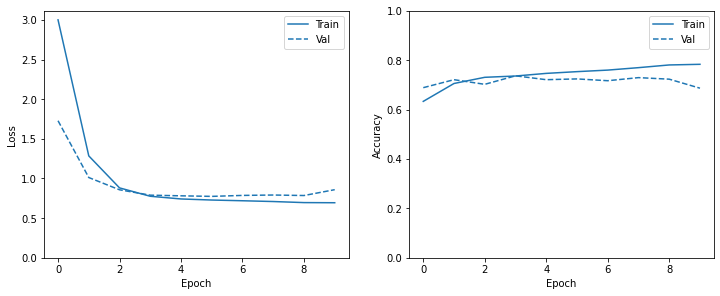

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7125
              precision    recall  f1-score   support

           0       0.40      0.02      0.04        84
           1       0.69      0.98      0.81       736
           2       0.91      0.34      0.50       380

    accuracy                           0.71      1200
   macro avg       0.67      0.45      0.45      1200
weighted avg       0.74      0.71      0.66      1200



# CNN2

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(128)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 261, 100)     1981800     ['input_18[0][0]']               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 261, 64)      12864       ['embedding_17[0][0]']           
                                                                                                  
 conv1d_41 (Conv1D)             (None, 261, 64)      19264       ['embedding_17[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 5s 33ms/step - loss: 2.4164 - accuracy: 0.6135 - val_loss: 1.6892 - val_accuracy: 0.7073
Epoch 2/10
60/60 [==============================] - 1s 19ms/step - loss: 1.3537 - accuracy: 0.6799 - val_loss: 1.0997 - val_accuracy: 0.7031
Epoch 3/10
60/60 [==============================] - 1s 18ms/step - loss: 0.9577 - accuracy: 0.7214 - val_loss: 0.8855 - val_accuracy: 0.7323
Epoch 4/10
60/60 [==============================] - 1s 15ms/step - loss: 0.7960 - accuracy: 0.7508 - val_loss: 0.8285 - val_accuracy: 0.7146
Epoch 5/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7131 - accuracy: 0.7656 - val_loss: 0.7831 - val_accuracy: 0.7365
Epoch 6/10
60/60 [==============================] - 1s 14ms/step - loss: 0.6525 - accuracy: 0.7974 - val_loss: 0.7792 - val_accuracy: 0.7240
Epoch 7/10
60/60 [==============================] - 1s 19ms/step - loss: 0.5973 - accuracy: 0.8273 - val_loss: 0.7995 - val_accuracy: 0.7240
Epoch 8/10
60

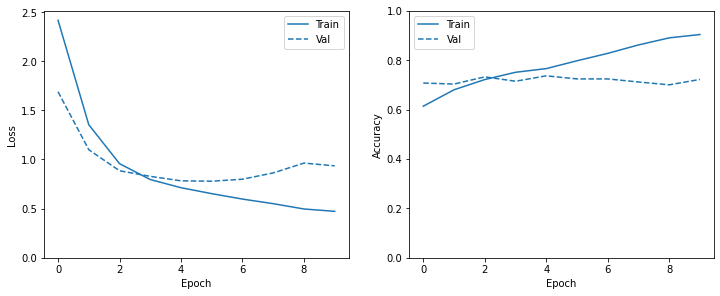

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7325
              precision    recall  f1-score   support

           0       0.46      0.07      0.12        84
           1       0.73      0.93      0.82       736
           2       0.75      0.50      0.60       380

    accuracy                           0.73      1200
   macro avg       0.65      0.50      0.51      1200
weighted avg       0.72      0.73      0.70      1200



# CNN4

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 261, 100)     1981800     ['input_19[0][0]']               
                                                                                                  
 conv1d_43 (Conv1D)             (None, 261, 64)      12864       ['embedding_18[0][0]']           
                                                                                                  
 conv1d_44 (Conv1D)             (None, 261, 32)      9632        ['embedding_18[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 2s 13ms/step - loss: 1.9072 - accuracy: 0.6362 - val_loss: 1.4816 - val_accuracy: 0.6719
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 1.2419 - accuracy: 0.6958 - val_loss: 1.0802 - val_accuracy: 0.6833
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 0.9528 - accuracy: 0.7125 - val_loss: 0.8984 - val_accuracy: 0.7063
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8217 - accuracy: 0.7276 - val_loss: 0.8217 - val_accuracy: 0.7344
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.7566 - accuracy: 0.7367 - val_loss: 0.7752 - val_accuracy: 0.7302
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7189 - accuracy: 0.7451 - val_loss: 0.7520 - val_accuracy: 0.7271
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.6947 - accuracy: 0.7513 - val_loss: 0.7386 - val_accuracy: 0.7229
Epoch 8/10
60/60 [=

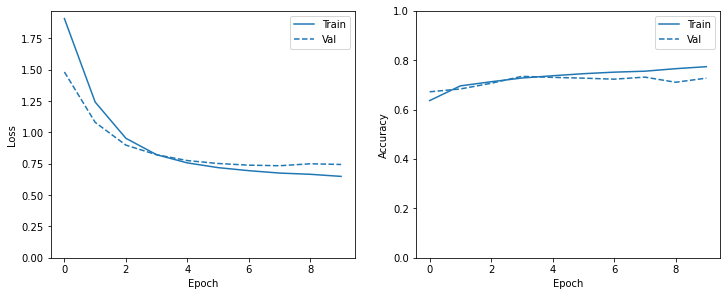

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7466666666666667
              precision    recall  f1-score   support

           0       0.45      0.06      0.11        84
           1       0.78      0.87      0.82       736
           2       0.68      0.66      0.67       380

    accuracy                           0.75      1200
   macro avg       0.64      0.53      0.53      1200
weighted avg       0.73      0.75      0.72      1200



# CNN4_1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=16, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 261, 100)     1981800     ['input_20[0][0]']               
                                                                                                  
 conv1d_46 (Conv1D)             (None, 261, 64)      12864       ['embedding_19[0][0]']           
                                                                                                  
 conv1d_47 (Conv1D)             (None, 261, 32)      9632        ['embedding_19[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 4s 30ms/step - loss: 1.9319 - accuracy: 0.6169 - val_loss: 1.4696 - val_accuracy: 0.6917
Epoch 2/10
60/60 [==============================] - 1s 16ms/step - loss: 1.2301 - accuracy: 0.6839 - val_loss: 1.0514 - val_accuracy: 0.6812
Epoch 3/10
60/60 [==============================] - 1s 17ms/step - loss: 0.9394 - accuracy: 0.7130 - val_loss: 0.8789 - val_accuracy: 0.7208
Epoch 4/10
60/60 [==============================] - 1s 16ms/step - loss: 0.8108 - accuracy: 0.7255 - val_loss: 0.8017 - val_accuracy: 0.7167
Epoch 5/10
60/60 [==============================] - 1s 14ms/step - loss: 0.7497 - accuracy: 0.7411 - val_loss: 0.7662 - val_accuracy: 0.7146
Epoch 6/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7180 - accuracy: 0.7432 - val_loss: 0.7578 - val_accuracy: 0.7240
Epoch 7/10
60/60 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.7523 - val_loss: 0.7415 - val_accuracy: 0.7312
Epoch 8/10
60

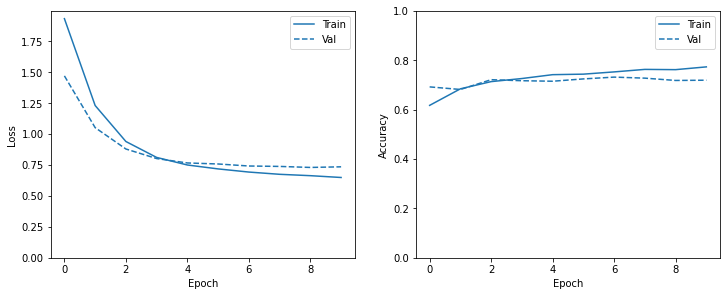

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.7266666666666667
              precision    recall  f1-score   support

           0       0.50      0.02      0.05        84
           1       0.72      0.95      0.81       736
           2       0.78      0.46      0.58       380

    accuracy                           0.73      1200
   macro avg       0.67      0.48      0.48      1200
weighted avg       0.72      0.73      0.69      1200



# CNN4_2

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=16, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 261, 100)     1981800     ['input_21[0][0]']               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 261, 16)      3216        ['embedding_20[0][0]']           
                                                                                                  
 conv1d_50 (Conv1D)             (None, 261, 32)      9632        ['embedding_20[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 4s 29ms/step - loss: 1.8278 - accuracy: 0.6375 - val_loss: 1.3918 - val_accuracy: 0.6542
Epoch 2/10
60/60 [==============================] - 2s 27ms/step - loss: 1.1467 - accuracy: 0.6914 - val_loss: 1.0014 - val_accuracy: 0.6885
Epoch 3/10
60/60 [==============================] - 1s 20ms/step - loss: 0.8866 - accuracy: 0.7224 - val_loss: 0.8526 - val_accuracy: 0.7104
Epoch 4/10
60/60 [==============================] - 1s 19ms/step - loss: 0.7759 - accuracy: 0.7349 - val_loss: 0.8003 - val_accuracy: 0.7094
Epoch 5/10
60/60 [==============================] - 1s 19ms/step - loss: 0.7197 - accuracy: 0.7516 - val_loss: 0.7637 - val_accuracy: 0.7156
Epoch 6/10
60/60 [==============================] - 1s 20ms/step - loss: 0.6882 - accuracy: 0.7555 - val_loss: 0.7495 - val_accuracy: 0.7146
Epoch 7/10
60/60 [==============================] - 1s 20ms/step - loss: 0.6640 - accuracy: 0.7693 - val_loss: 0.7401 - val_accuracy: 0.7115
Epoch 8/10
60

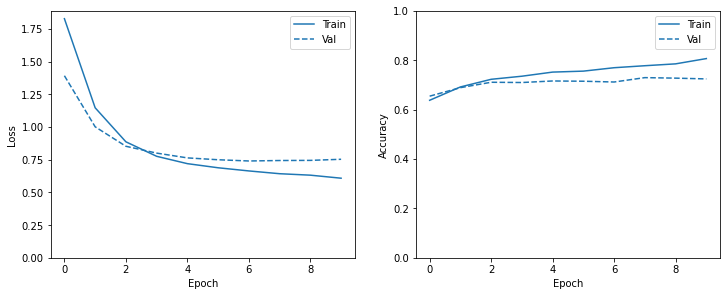

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.74
              precision    recall  f1-score   support

           0       0.25      0.01      0.02        84
           1       0.76      0.88      0.82       736
           2       0.69      0.63      0.66       380

    accuracy                           0.74      1200
   macro avg       0.57      0.51      0.50      1200
weighted avg       0.70      0.74      0.71      1200



# CNN5

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 261, 100)     1981800     ['input_22[0][0]']               
                                                                                                  
 conv1d_52 (Conv1D)             (None, 261, 50)      10050       ['embedding_21[0][0]']           
                                                                                                  
 conv1d_53 (Conv1D)             (None, 261, 100)     30100       ['embedding_21[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 25ms/step - loss: 2.2184 - accuracy: 0.5755 - val_loss: 1.6862 - val_accuracy: 0.6583
Epoch 2/10
60/60 [==============================] - 1s 16ms/step - loss: 1.4577 - accuracy: 0.6664 - val_loss: 1.2269 - val_accuracy: 0.6854
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 1.0985 - accuracy: 0.6997 - val_loss: 0.9966 - val_accuracy: 0.7031
Epoch 4/10
60/60 [==============================] - 1s 13ms/step - loss: 0.9170 - accuracy: 0.7156 - val_loss: 0.8825 - val_accuracy: 0.7219
Epoch 5/10
60/60 [==============================] - 1s 13ms/step - loss: 0.8225 - accuracy: 0.7216 - val_loss: 0.8165 - val_accuracy: 0.7156
Epoch 6/10
60/60 [==============================] - 1s 10ms/step - loss: 0.7669 - accuracy: 0.7349 - val_loss: 0.7830 - val_accuracy: 0.7156
Epoch 7/10
60/60 [==============================] - 1s 12ms/step - loss: 0.7356 - accuracy: 0.7417 - val_loss: 0.7659 - val_accuracy: 0.7229
Epoch 8/10
60

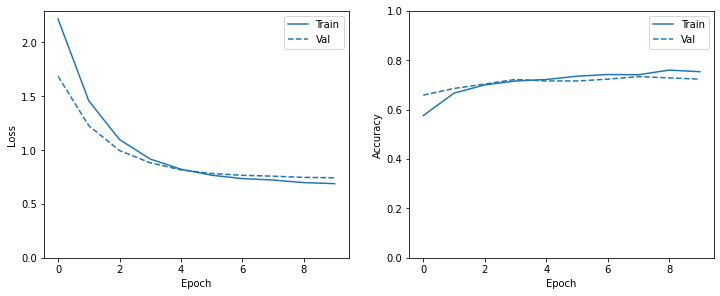

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 5ms/step
Accuracy of prediction on test set :  0.735
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        84
           1       0.73      0.93      0.82       736
           2       0.76      0.52      0.61       380

    accuracy                           0.73      1200
   macro avg       0.66      0.49      0.49      1200
weighted avg       0.72      0.73      0.70      1200



# CNN5_1

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=50, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

merged = concatenate([bigram_branch, trigram_branch], axis=1)

merged = Dropout(0.3)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 261, 100)     1981800     ['input_23[0][0]']               
                                                                                                  
 conv1d_54 (Conv1D)             (None, 261, 50)      10050       ['embedding_22[0][0]']           
                                                                                                  
 conv1d_55 (Conv1D)             (None, 261, 100)     30100       ['embedding_22[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 27ms/step - loss: 2.0984 - accuracy: 0.6172 - val_loss: 1.6012 - val_accuracy: 0.6667
Epoch 2/10
60/60 [==============================] - 1s 14ms/step - loss: 1.3703 - accuracy: 0.6755 - val_loss: 1.1595 - val_accuracy: 0.6958
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 1.0356 - accuracy: 0.7047 - val_loss: 0.9590 - val_accuracy: 0.6990
Epoch 4/10
60/60 [==============================] - 1s 14ms/step - loss: 0.8739 - accuracy: 0.7193 - val_loss: 0.8727 - val_accuracy: 0.7312
Epoch 5/10
60/60 [==============================] - 1s 12ms/step - loss: 0.8056 - accuracy: 0.7279 - val_loss: 0.8008 - val_accuracy: 0.7208
Epoch 6/10
60/60 [==============================] - 1s 11ms/step - loss: 0.7518 - accuracy: 0.7349 - val_loss: 0.7723 - val_accuracy: 0.7135
Epoch 7/10
60/60 [==============================] - 1s 10ms/step - loss: 0.7187 - accuracy: 0.7505 - val_loss: 0.7569 - val_accuracy: 0.7177
Epoch 8/10
60

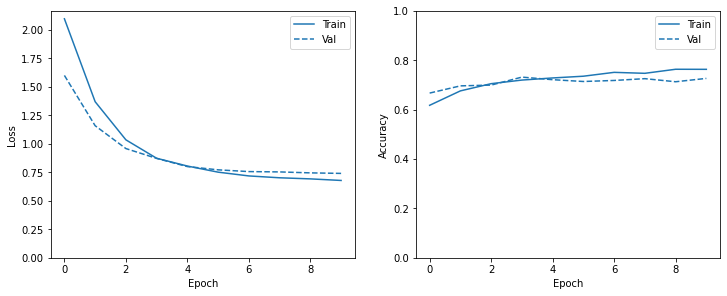

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 3ms/step
Accuracy of prediction on test set :  0.7283333333333334
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        84
           1       0.72      0.94      0.81       736
           2       0.78      0.48      0.59       380

    accuracy                           0.73      1200
   macro avg       0.61      0.48      0.49      1200
weighted avg       0.71      0.73      0.69      1200



# CNN6

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=1024, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=1024, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=1024, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 261, 100)     1981800     ['input_24[0][0]']               
                                                                                                  
 conv1d_56 (Conv1D)             (None, 261, 1024)    205824      ['embedding_23[0][0]']           
                                                                                                  
 conv1d_57 (Conv1D)             (None, 261, 1024)    308224      ['embedding_23[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 4s 50ms/step - loss: 2.5815 - accuracy: 0.6721 - val_loss: 0.9815 - val_accuracy: 0.7240
Epoch 2/10
60/60 [==============================] - 3s 47ms/step - loss: 0.8525 - accuracy: 0.7193 - val_loss: 0.8086 - val_accuracy: 0.7167
Epoch 3/10
60/60 [==============================] - 3s 46ms/step - loss: 0.7923 - accuracy: 0.7237 - val_loss: 0.7904 - val_accuracy: 0.7229
Epoch 4/10
60/60 [==============================] - 3s 48ms/step - loss: 0.7830 - accuracy: 0.7292 - val_loss: 0.7947 - val_accuracy: 0.7281
Epoch 5/10
60/60 [==============================] - 3s 49ms/step - loss: 0.7674 - accuracy: 0.7432 - val_loss: 0.8166 - val_accuracy: 0.7125
Epoch 6/10
60/60 [==============================] - 3s 46ms/step - loss: 0.7650 - accuracy: 0.7555 - val_loss: 0.8253 - val_accuracy: 0.7250
Epoch 7/10
60/60 [==============================] - 3s 48ms/step - loss: 0.7737 - accuracy: 0.7510 - val_loss: 0.8669 - val_accuracy: 0.7063
Epoch 8/10
60

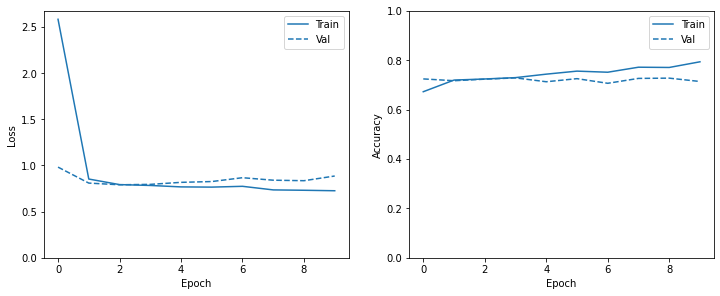

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 1s 13ms/step
Accuracy of prediction on test set :  0.7241666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.71      0.95      0.81       736
           2       0.80      0.45      0.58       380

    accuracy                           0.72      1200
   macro avg       0.50      0.47      0.46      1200
weighted avg       0.69      0.72      0.68      1200



# CNN7

In [ ]:
tweet_input = Input(shape=(261,), dtype='int32')

tweet_encoder = Embedding(input_dim=19818 ,output_dim=100,weights=[embedding_matrix],input_length=261,trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=128, kernel_size=3, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=256, kernel_size=4, padding='same', activation='tanh', kernel_regularizer=l2(0.01))(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)


merged = Dense(3)(merged)
output = Activation('softmax')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 261)]        0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 261, 100)     1981800     ['input_25[0][0]']               
                                                                                                  
 conv1d_59 (Conv1D)             (None, 261, 64)      12864       ['embedding_24[0][0]']           
                                                                                                  
 conv1d_60 (Conv1D)             (None, 261, 128)     38528       ['embedding_24[0][0]']           
                                                                                           

In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/10
60/60 [==============================] - 3s 28ms/step - loss: 2.6241 - accuracy: 0.6638 - val_loss: 1.5495 - val_accuracy: 0.7146
Epoch 2/10
60/60 [==============================] - 1s 15ms/step - loss: 1.1586 - accuracy: 0.7182 - val_loss: 0.9520 - val_accuracy: 0.7198
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 0.8305 - accuracy: 0.7378 - val_loss: 0.8181 - val_accuracy: 0.7260
Epoch 4/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7400 - accuracy: 0.7503 - val_loss: 0.7784 - val_accuracy: 0.7146
Epoch 5/10
60/60 [==============================] - 1s 16ms/step - loss: 0.7216 - accuracy: 0.7487 - val_loss: 0.7791 - val_accuracy: 0.7135
Epoch 6/10
60/60 [==============================] - 1s 17ms/step - loss: 0.6908 - accuracy: 0.7740 - val_loss: 0.7978 - val_accuracy: 0.7052
Epoch 7/10
60/60 [==============================] - 1s 16ms/step - loss: 0.6734 - accuracy: 0.7750 - val_loss: 0.7651 - val_accuracy: 0.7292
Epoch 8/10
60

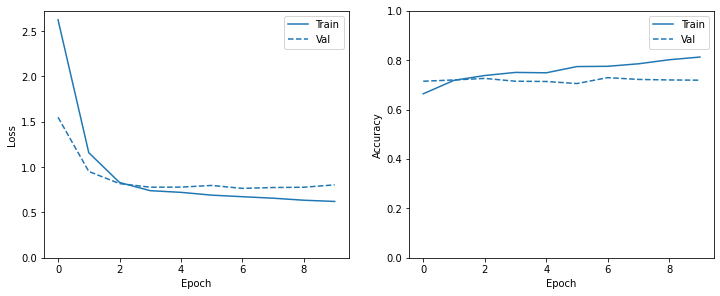

In [ ]:
model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10 , batch_size = 64 )

# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)
# print(model.history)

In [ ]:
prediction_prob = model.predict(X_test)
y_pred = np.argmax(prediction_prob, axis=1)

print("Accuracy of prediction on test set : ", accuracy_score(Y_test,y_pred))
print(classification_report(Y_test, y_pred, labels=[0, 1, 2]))

38/38 [==============================] - 0s 4ms/step
Accuracy of prediction on test set :  0.73
              precision    recall  f1-score   support

           0       0.30      0.25      0.27        84
           1       0.75      0.89      0.81       736
           2       0.77      0.53      0.63       380

    accuracy                           0.73      1200
   macro avg       0.61      0.56      0.57      1200
weighted avg       0.73      0.73      0.72      1200

